In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

In [2]:
POOL = 'WETH-USDT-3000'
MAX_DATE = '2022-01-28'
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_RETURNS = f'./saved-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [3]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [4]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159300 entries, 0 to 159299
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype              
---  ------                          --------------   -----              
 0   swap_time                       159300 non-null  datetime64[ns, UTC]
 1   tx_hash                         159300 non-null  string             
 2   token_0_amount                  159300 non-null  float64            
 3   token_1_amount                  159300 non-null  float64            
 4   pool_address                    159300 non-null  string             
 5   price_tick                      159300 non-null  int64              
 6   price_tick_adjusted             159300 non-null  float64            
 7   contract_address_token_0        159300 non-null  string             
 8   contract_name_token_0           159300 non-null  string             
 9   contract_ticker_symbol_token_0  159300 non-null  string             
 

swap_time  \
0 2022-01-29 19:38:25+00:00   
1 2022-01-29 19:34:12+00:00   
2 2022-01-29 19:33:47+00:00   
3 2022-01-29 19:03:52+00:00   
4 2022-01-29 18:56:20+00:00   

                                             tx_hash  token_0_amount  \
0  0xb58884e3560cee63ddd0c39e2a696e11e7063eae7343...        1.300000   
1  0x57c4af9974e06df4a4c4e2a6ce8bf5dc02b7acb6ba3d...        0.900000   
2  0x4c1d78307666a4c4539167cac29ff357e58ec811668b...      -54.511652   
3  0xc37a76b1d1159e67379d07c6e4a7a83cfb01aed84bec...       -0.270085   
4  0x2d66d97aff5d1191ba9dd8afe50077fcfbcb18c7f8fe...       -1.305730   

   token_1_amount                                pool_address  price_tick  \
0    -3365.995893  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36     -197700   
1    -2330.387545  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36     -197699   
2   141875.800000  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36     -197699   
3      702.320627  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36     -197717   
4     3395.289643  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36     -197717   

   price_tick_adjusted                    contract_address_token_0  \
0            2596.7334  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
1            2596.9931  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
2            2596.9931  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
3            2592.3229  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
4            2592.3229  0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

  contract_name_token_0 contract_ticker_symbol_token_0  \
0         Wrapped Ether                           WETH   
1         Wrapped Ether                           WETH   
2         Wrapped Ether                           WETH   
3         Wrapped Ether                           WETH   
4         Wrapped Ether                           WETH   

   contract_decimals_token_0                    contract_address_token_1  \
0                         18  0xdac17f958d2ee523a2206206994597c13d831ec7   
1                         18  0xdac17f958d2ee523a2206206994597c13d831ec7   
2                         18  0xdac17f958d2ee523a2206206994597c13d831ec7   
3                         18  0xdac17f958d2ee523a2206206994597c13d831ec7   
4                         18  0xdac17f958d2ee523a2206206994597c13d831ec7   

  contract_name_token_1 contract_ticker_symbol_token_1  \
0            Tether USD                           USDT   
1            Tether USD                           USDT   
2            Tether USD                           USDT   
3            Tether USD                           USDT   
4            Tether USD                           USDT   

   contract_decimals_token_1  pool_fee  pool_tick_spacing  \
0                          6      3000                 60   
1                          6      3000                 60   
2                          6      3000                 60   
3                          6      3000                 60   
4                          6      3000                 60   

           pool_deploy_time  
0 2021-05-05 16:37:08+00:00  
1 2021-05-05 16:37:08+00:00  
2 2021-05-05 16:37:08+00:00  
3 2021-05-05 16:37:08+00:00  
4 2021-05-05 16:37:08+00:00

In [5]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29092 entries, 0 to 29091
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        29092 non-null  datetime64[ns, UTC]
 1   tx_hash                         29092 non-null  string             
 2   token_0_amount                  29092 non-null  float64            
 3   token_1_amount                  29092 non-null  float64            
 4   pool_address                    29092 non-null  string             
 5   liquidity_event                 29092 non-null  string             
 6   price_tick_lower                29092 non-null  int64              
 7   price_tick_upper                29092 non-null  int64              
 8   price_tick_lower_adjusted       29092 non-null  float64            
 9   price_tick_upper_adjusted       29092 non-null  float64            
 10  contract_a

txn_time  \
0 2022-01-29 19:14:38+00:00   
1 2022-01-29 16:56:03+00:00   
2 2022-01-29 08:51:07+00:00   
3 2022-01-29 08:51:07+00:00   
4 2022-01-29 08:51:07+00:00   

                                             tx_hash  token_0_amount  \
0  0xd5287c2dadd3363992d6231f55fde4fca58312ba486d...       18.345197   
1  0xea8f49e7247e0545b92a799d12c781716300551d2cbf...        2.300000   
2  0xad915470dd7474035687edc1c33fcf895058fffb2b35...        6.780760   
3  0xad915470dd7474035687edc1c33fcf895058fffb2b35...        0.000000   
4  0xad915470dd7474035687edc1c33fcf895058fffb2b35...        6.374256   

   token_1_amount                                pool_address  \
0        0.000000  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   
1     1875.738450  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   
2    27165.445673  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   
3        0.000000  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   
4    26882.504474  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   

    liquidity_event  price_tick_lower  price_tick_upper  \
0  REMOVE_LIQUIDITY           -195840           -192660   
1     ADD_LIQUIDITY           -198720           -195240   
2     ADD_LIQUIDITY           -204240           -193980   
3  REMOVE_LIQUIDITY           -197340           -191160   
4  REMOVE_LIQUIDITY           -210420           -191160   

   price_tick_lower_adjusted  price_tick_upper_adjusted  ...  \
0                  3127.5344                  4298.3407  ...   
1                  2344.9390                  3320.9204  ...   
2                  1350.2462                  3766.8371  ...   
3                  2691.9140                  4993.9220  ...   
4                   727.8341                  4993.9220  ...   

  contract_decimals_token_0                    contract_address_token_1  \
0                        18  0xdac17f958d2ee523a2206206994597c13d831ec7   
1                        18  0xdac17f958d2ee523a2206206994597c13d831ec7   
2                        18  0xdac17f958d2ee523a2206206994597c13d831ec7   
3                        18  0xdac17f958d2ee523a2206206994597c13d831ec7   
4                        18  0xdac17f958d2ee523a2206206994597c13d831ec7   

  contract_name_token_1  contract_ticker_symbol_token_1  \
0            Tether USD                            USDT   
1            Tether USD                            USDT   
2            Tether USD                            USDT   
3            Tether USD                            USDT   
4            Tether USD                            USDT   

  contract_decimals_token_1         event_name pool_fee  pool_tick_spacing  \
0                         6  DecreaseLiquidity     3000                 60   
1                         6               Mint     3000                 60   
2                         6               Mint     3000                 60   
3                         6               Burn     3000                 60   
4                         6               Burn     3000                 60   

           pool_deploy_time  liquidity  
0 2021-05-05 16:37:08+00:00  -0.006979  
1 2021-05-05 16:37:08+00:00   0.000930  
2 2021-05-05 16:37:08+00:00   0.001958  
3 2021-05-05 16:37:08+00:00  -0.000000  
4 2021-05-05 16:37:08+00:00  -0.001137  

[5 rows x 23 columns]

In [6]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

txn_time  \
0 2021-05-05 16:37:08+00:00   
1 2021-05-05 17:20:08+00:00   
2 2021-05-05 17:26:26+00:00   
3 2021-05-05 17:29:37+00:00   
4 2021-05-05 17:29:37+00:00   

                                             tx_hash  token_0_amount  \
0  0x2e07c690f149223e4f290986277304ea6a05c6ee47ba...    1.242324e+01   
1  0x85a3f0ed4fc14085609e95e7366364566b89d7569e62...    1.000000e-03   
2  0x0fde2929c1fa5dd5dc9a0fcfbf8adccdeefbc398aa36...    9.995372e-08   
3  0x34ca11f7f1c6a4d8d17cabf14c6d0ffa5116a693508c...    9.999750e-06   
4  0x9ece74425a9b5b937b51e14d4fbb9eb7aa6f6ae415d5...    9.999750e-06   

   token_1_amount                                pool_address liquidity_event  \
0    50500.280094  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   ADD_LIQUIDITY   
1        0.000000  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   ADD_LIQUIDITY   
2        0.000274  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   ADD_LIQUIDITY   
3        0.027412  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   ADD_LIQUIDITY   
4        0.027412  0x4e68ccd3e89f51c3074ca5072bbac773960dfa36   ADD_LIQUIDITY   

   price_tick_lower  price_tick_upper  price_tick_lower_adjusted  \
0           -197400           -193320                  2675.8117   
1           -195120           -195060                  3361.0095   
2           -195180           -195120                  3340.9048   
3           -195180           -195120                  3340.9048   
4           -195180           -195120                  3340.9048   

   price_tick_upper_adjusted  ... contract_decimals_token_0  \
0                  4023.8227  ...                        18   
1                  3381.2352  ...                        18   
2                  3361.0095  ...                        18   
3                  3361.0095  ...                        18   
4                  3361.0095  ...                        18   

                     contract_address_token_1 contract_name_token_1  \
0  0xdac17f958d2ee523a2206206994597c13d831ec7            Tether USD   
1  0xdac17f958d2ee523a2206206994597c13d831ec7            Tether USD   
2  0xdac17f958d2ee523a2206206994597c13d831ec7            Tether USD   
3  0xdac17f958d2ee523a2206206994597c13d831ec7            Tether USD   
4  0xdac17f958d2ee523a2206206994597c13d831ec7            Tether USD   

   contract_ticker_symbol_token_1 contract_decimals_token_1 event_name  \
0                            USDT                         6       Mint   
1                            USDT                         6       Mint   
2                            USDT                         6       Mint   
3                            USDT                         6       Mint   
4                            USDT                         6       Mint   

  pool_fee  pool_tick_spacing          pool_deploy_time     liquidity  
0     3000                 60 2021-05-05 16:37:08+00:00  8.210905e-03  
1     3000                 60 2021-05-05 16:37:08+00:00  1.935471e-05  
2     3000                 60 2021-05-05 16:37:08+00:00  3.509242e-09  
3     3000                 60 2021-05-05 16:37:08+00:00  3.510779e-07  
4     3000                 60 2021-05-05 16:37:08+00:00  3.510779e-07  

[5 rows x 23 columns]

In [7]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0x2e07c690f149223e4f290986277304ea6a05c6ee47ba303732166bc1b15cbafb


In [8]:
# from https://etherscan.io/tx/0x2e07c690f149223e4f290986277304ea6a05c6ee47ba303732166bc1b15cbafb#eventlog
liquidity_delta = amount_to_float('8210904713296766', 18)  # belive all liquidity amounts use 18 decimals
assert liquidity_delta == adds.at[0, 'liquidity']

token0 = adds.at[0, 'token_0_amount']
token1 = adds.at[0, 'token_1_amount']
tick_lower = adds.at[0, 'price_tick_lower']
tick_upper = adds.at[0, 'price_tick_upper']
token0_decimals = adds.at[0, 'contract_decimals_token_0']
token1_decimals = adds.at[0, 'contract_decimals_token_1']

init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
                             token0_decimals, token1_decimals)

token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

Pool initial price (USDT/WETH): 3.349936990661e-09
Pool initial price (WETH/USDT): 2.985130773468e+08


In [9]:
sqrt_price_x96 = 4585618311359384700632587
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Calculated initial price: 3.349936990661e-09
Price per Etherscan:      3.349936990655e-09


In [10]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

orig_idx                                            tx_hash  \
0          29091  0x2e07c690f149223e4f290986277304ea6a05c6ee47ba...   
1          29090  0x85a3f0ed4fc14085609e95e7366364566b89d7569e62...   
2          29089  0x0fde2929c1fa5dd5dc9a0fcfbf8adccdeefbc398aa36...   
3          29087  0x9ece74425a9b5b937b51e14d4fbb9eb7aa6f6ae415d5...   
4          29088  0x34ca11f7f1c6a4d8d17cabf14c6d0ffa5116a693508c...   
...          ...                                                ...   
187847       506  0x8d6b8fc0cc35de23f1696879496061a12455d1f87d20...   
187848       505  0x45bb3bd5f066b7ad266fd8101afa85e02a063526084d...   
187849       504  0x3342198d04071b69d2958709f3bbc717165968ee0690...   
187850       503  0xb5810b58be9ee79c2bd67f9627b9be3b5d26f7a6182d...   
187851       502  0x0e212fc022f17737315fd4d264600bcf5250394ce146...   

                        txn_time          event  
0      2021-05-05 16:37:08+00:00  ADD_LIQUIDITY  
1      2021-05-05 17:20:08+00:00  ADD_LIQUIDITY  
2      2021-05-05 17:26:26+00:00  ADD_LIQUIDITY  
3      2021-05-05 17:29:37+00:00  ADD_LIQUIDITY  
4      2021-05-05 17:29:37+00:00  ADD_LIQUIDITY  
...                          ...            ...  
187847 2022-01-27 23:49:16+00:00           SWAP  
187848 2022-01-27 23:52:48+00:00           SWAP  
187849 2022-01-27 23:53:22+00:00           SWAP  
187850 2022-01-27 23:53:59+00:00           SWAP  
187851 2022-01-27 23:59:47+00:00           SWAP  

[187852 rows x 4 columns]

In [11]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
TOKEN1_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [12]:
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

Pool(price=3,349.9370, liquidity=0.00, fee=0.30%)
Completed transaction 0.
Completed transaction 1.
Completed transaction 2.
Completed transaction 3.
Completed transaction 4.
Completed transaction 5.
Completed transaction 6.
Completed transaction 7.
Completed transaction 8.
Completed transaction 9.
Completed transaction 10.
Completed transaction 11.
Completed transaction 12.
Completed transaction 13.
Completed transaction 14.
Completed transaction 15.
Completed transaction 16.
Completed transaction 17.
Completed transaction 18.
Completed transaction 19.
Completed transaction 20.
Completed transaction 21.
Completed transaction 22.
Completed transaction 23.
Completed transaction 24.
Completed transaction 25.
Completed transaction 26.
Completed transaction 27.
Completed transaction 28.
Completed transaction 29.
Completed transaction 30.
Completed transaction 31.
Completed transaction 32.
Completed transaction 33.
Completed transaction 34.
Completed transaction 35.
Completed transaction 36

Completed transaction 543.
Completed transaction 544.
Completed transaction 545.
Completed transaction 546.
Completed transaction 547.
Completed transaction 548.
Completed transaction 549.
Completed transaction 550.
Completed transaction 551.
Completed transaction 552.
Completed transaction 553.
Completed transaction 554.
Completed transaction 555.
Completed transaction 556.
Completed transaction 557.
Completed transaction 558.
Completed transaction 559.
Completed transaction 560.
Completed transaction 561.
Completed transaction 562.
Completed transaction 563.
Completed transaction 564.
Completed transaction 565.
Completed transaction 566.
Completed transaction 567.
Completed transaction 568.
Completed transaction 569.
Completed transaction 570.
Completed transaction 571.
Completed transaction 572.
Completed transaction 573.
Completed transaction 574.
Completed transaction 575.
Completed transaction 576.
Completed transaction 577.
Completed transaction 578.
Completed transaction 579.
C

Completed transaction 995.
Completed transaction 996.
Completed transaction 997.
Completed transaction 998.
Completed transaction 999.
Completed transaction 1000.
Completed transaction 1001.
Completed transaction 1002.
Completed transaction 1003.
Completed transaction 1004.
Completed transaction 1005.
Completed transaction 1006.
Completed transaction 1007.
Completed transaction 1008.
Completed transaction 1009.
Completed transaction 1010.
Completed transaction 1011.
Completed transaction 1012.
Completed transaction 1013.
Completed transaction 1014.
Completed transaction 1015.
Completed transaction 1016.
Completed transaction 1017.
Completed transaction 1018.
Completed transaction 1019.
Completed transaction 1020.
Completed transaction 1021.
Completed transaction 1022.
Completed transaction 1023.
Completed transaction 1024.
Completed transaction 1025.
Completed transaction 1026.
Completed transaction 1027.
Completed transaction 1028.
Completed transaction 1029.
Completed transaction 103

Completed transaction 1470.
Completed transaction 1471.
Completed transaction 1472.
Completed transaction 1473.
Completed transaction 1474.
Completed transaction 1475.
Completed transaction 1476.
Completed transaction 1477.
Completed transaction 1478.
Completed transaction 1479.
Completed transaction 1480.
Completed transaction 1481.
Completed transaction 1482.
Completed transaction 1483.
Completed transaction 1484.
Completed transaction 1485.
Completed transaction 1486.
Completed transaction 1487.
Completed transaction 1488.
Completed transaction 1489.
Completed transaction 1490.
Completed transaction 1491.
Completed transaction 1492.
Completed transaction 1493.
Completed transaction 1494.
Completed transaction 1495.
Completed transaction 1496.
Completed transaction 1497.
Completed transaction 1498.
Completed transaction 1499.
Completed transaction 1500.
Completed transaction 1501.
Completed transaction 1502.
Completed transaction 1503.
Completed transaction 1504.
Completed transactio

Completed transaction 1957.
Completed transaction 1958.
Completed transaction 1959.
Completed transaction 1960.
Completed transaction 1961.
Completed transaction 1962.
Completed transaction 1963.
Completed transaction 1964.
Completed transaction 1965.
Completed transaction 1966.
Completed transaction 1967.
Completed transaction 1968.
Completed transaction 1969.
Completed transaction 1970.
Completed transaction 1971.
Completed transaction 1972.
Completed transaction 1973.
Completed transaction 1974.
Completed transaction 1975.
Completed transaction 1976.
Completed transaction 1977.
Completed transaction 1978.
Completed transaction 1979.
Completed transaction 1980.
Completed transaction 1981.
Completed transaction 1982.
Completed transaction 1983.
Completed transaction 1984.
Completed transaction 1985.
Completed transaction 1986.
Completed transaction 1987.
Completed transaction 1988.
Completed transaction 1989.
Completed transaction 1990.
Completed transaction 1991.
Completed transactio

Completed transaction 2496.
Completed transaction 2497.
Completed transaction 2498.
Completed transaction 2499.
Completed transaction 2500.
Completed transaction 2501.
Completed transaction 2502.
Completed transaction 2503.
Completed transaction 2504.
Completed transaction 2505.
Completed transaction 2506.
Completed transaction 2507.
Completed transaction 2508.
Completed transaction 2509.
Completed transaction 2510.
Completed transaction 2511.
Completed transaction 2512.
Completed transaction 2513.
Completed transaction 2514.
Completed transaction 2515.
Completed transaction 2516.
Completed transaction 2517.
Completed transaction 2518.
Completed transaction 2519.
Completed transaction 2520.
Completed transaction 2521.
Completed transaction 2522.
Completed transaction 2523.
Completed transaction 2524.
Completed transaction 2525.
Completed transaction 2526.
Completed transaction 2527.
Completed transaction 2528.
Completed transaction 2529.
Completed transaction 2530.
Completed transactio

Completed transaction 3013.
Completed transaction 3014.
Completed transaction 3015.
Completed transaction 3016.
Completed transaction 3017.
Completed transaction 3018.
Completed transaction 3019.
Completed transaction 3020.
Completed transaction 3021.
Completed transaction 3022.
Completed transaction 3023.
Completed transaction 3024.
Completed transaction 3025.
Completed transaction 3026.
Completed transaction 3027.
Completed transaction 3028.
Completed transaction 3029.
Completed transaction 3030.
Completed transaction 3031.
Completed transaction 3032.
Completed transaction 3033.
Completed transaction 3034.
Completed transaction 3035.
Completed transaction 3036.
Completed transaction 3037.
Completed transaction 3038.
Completed transaction 3039.
Completed transaction 3040.
Completed transaction 3041.
Completed transaction 3042.
Completed transaction 3043.
Completed transaction 3044.
Completed transaction 3045.
Completed transaction 3046.
Completed transaction 3047.
Completed transactio

Completed transaction 3508.
Completed transaction 3509.
Completed transaction 3510.
Completed transaction 3511.
Completed transaction 3512.
Completed transaction 3513.
Completed transaction 3514.
Completed transaction 3515.
Completed transaction 3516.
Completed transaction 3517.
Completed transaction 3518.
Completed transaction 3519.
Completed transaction 3520.
Completed transaction 3521.
Completed transaction 3522.
Completed transaction 3523.
Completed transaction 3524.
Completed transaction 3525.
Completed transaction 3526.
Completed transaction 3527.
Completed transaction 3528.
Completed transaction 3529.
Completed transaction 3530.
Completed transaction 3531.
Completed transaction 3532.
Completed transaction 3533.
Completed transaction 3534.
Completed transaction 3535.
Completed transaction 3536.
Completed transaction 3537.
Completed transaction 3538.
Completed transaction 3539.
Completed transaction 3540.
Completed transaction 3541.
Completed transaction 3542.
Completed transactio

Completed transaction 3991.
Completed transaction 3992.
Completed transaction 3993.
Completed transaction 3994.
Completed transaction 3995.
Completed transaction 3996.
Completed transaction 3997.
Completed transaction 3998.
Completed transaction 3999.
Completed transaction 4000.
Completed transaction 4001.
Completed transaction 4002.
Completed transaction 4003.
Completed transaction 4004.
Completed transaction 4005.
Completed transaction 4006.
Completed transaction 4007.
Completed transaction 4008.
Completed transaction 4009.
Completed transaction 4010.
Completed transaction 4011.
Completed transaction 4012.
Completed transaction 4013.
Completed transaction 4014.
Completed transaction 4015.
Completed transaction 4016.
Completed transaction 4017.
Completed transaction 4018.
Completed transaction 4019.
Completed transaction 4020.
Completed transaction 4021.
Completed transaction 4022.
Completed transaction 4023.
Completed transaction 4024.
Completed transaction 4025.
Completed transactio

Completed transaction 4528.
Completed transaction 4529.
Completed transaction 4530.
Completed transaction 4531.
Completed transaction 4532.
Completed transaction 4533.
Completed transaction 4534.
Completed transaction 4535.
Completed transaction 4536.
Completed transaction 4537.
Completed transaction 4538.
Completed transaction 4539.
Completed transaction 4540.
Completed transaction 4541.
Completed transaction 4542.
Completed transaction 4543.
Completed transaction 4544.
Completed transaction 4545.
Completed transaction 4546.
Completed transaction 4547.
Completed transaction 4548.
Completed transaction 4549.
Completed transaction 4550.
Completed transaction 4551.
Completed transaction 4552.
Completed transaction 4553.
Completed transaction 4554.
Completed transaction 4555.
Completed transaction 4556.
Completed transaction 4557.
Completed transaction 4558.
Completed transaction 4559.
Completed transaction 4560.
Completed transaction 4561.
Completed transaction 4562.
Completed transactio

Completed transaction 5026.
Completed transaction 5027.
Completed transaction 5028.
Completed transaction 5029.
Completed transaction 5030.
Completed transaction 5031.
Completed transaction 5032.
Completed transaction 5033.
Completed transaction 5034.
Completed transaction 5035.
Completed transaction 5036.
Completed transaction 5037.
Completed transaction 5038.
Completed transaction 5039.
Completed transaction 5040.
Completed transaction 5041.
Completed transaction 5042.
Completed transaction 5043.
Completed transaction 5044.
Completed transaction 5045.
Completed transaction 5046.
Completed transaction 5047.
Completed transaction 5048.
Completed transaction 5049.
Completed transaction 5050.
Completed transaction 5051.
Completed transaction 5052.
Completed transaction 5053.
Completed transaction 5054.
Completed transaction 5055.
Completed transaction 5056.
Completed transaction 5057.
Completed transaction 5058.
Completed transaction 5059.
Completed transaction 5060.
Completed transactio

Completed transaction 5454.
Completed transaction 5455.
Completed transaction 5456.
Completed transaction 5457.
Completed transaction 5458.
Completed transaction 5459.
Completed transaction 5460.
Completed transaction 5461.
Completed transaction 5462.
Completed transaction 5463.
Completed transaction 5464.
Completed transaction 5465.
Completed transaction 5466.
Completed transaction 5467.
Completed transaction 5468.
Completed transaction 5469.
Completed transaction 5470.
Completed transaction 5471.
Completed transaction 5472.
Completed transaction 5473.
Completed transaction 5474.
Completed transaction 5475.
Completed transaction 5476.
Completed transaction 5477.
Completed transaction 5478.
Completed transaction 5479.
Completed transaction 5480.
Completed transaction 5481.
Completed transaction 5482.
Completed transaction 5483.
Completed transaction 5484.
Completed transaction 5485.
Completed transaction 5486.
Completed transaction 5487.
Completed transaction 5488.
Completed transactio

Completed transaction 5953.
Completed transaction 5954.
Completed transaction 5955.
Completed transaction 5956.
Completed transaction 5957.
Completed transaction 5958.
Completed transaction 5959.
Completed transaction 5960.
Completed transaction 5961.
Completed transaction 5962.
Completed transaction 5963.
Completed transaction 5964.
Completed transaction 5965.
Completed transaction 5966.
Completed transaction 5967.
Completed transaction 5968.
Completed transaction 5969.
Completed transaction 5970.
Completed transaction 5971.
Completed transaction 5972.
Completed transaction 5973.
Completed transaction 5974.
Completed transaction 5975.
Completed transaction 5976.
Completed transaction 5977.
Completed transaction 5978.
Completed transaction 5979.
Completed transaction 5980.
Completed transaction 5981.
Completed transaction 5982.
Completed transaction 5983.
Completed transaction 5984.
Completed transaction 5985.
Completed transaction 5986.
Completed transaction 5987.
Completed transactio

Completed transaction 6380.
Completed transaction 6381.
Completed transaction 6382.
Completed transaction 6383.
Completed transaction 6384.
Completed transaction 6385.
Completed transaction 6386.
Completed transaction 6387.
Completed transaction 6388.
Completed transaction 6389.
Completed transaction 6390.
Completed transaction 6391.
Completed transaction 6392.
Completed transaction 6393.
Completed transaction 6394.
Completed transaction 6395.
Completed transaction 6396.
Completed transaction 6397.
Completed transaction 6398.
Completed transaction 6399.
Completed transaction 6400.
Completed transaction 6401.
Completed transaction 6402.
Completed transaction 6403.
Completed transaction 6404.
Completed transaction 6405.
Completed transaction 6406.
Completed transaction 6407.
Completed transaction 6408.
Completed transaction 6409.
Completed transaction 6410.
Completed transaction 6411.
Completed transaction 6412.
Completed transaction 6413.
Completed transaction 6414.
Completed transactio

Completed transaction 6764.
Completed transaction 6765.
Completed transaction 6766.
Completed transaction 6767.
Completed transaction 6768.
Completed transaction 6769.
Completed transaction 6770.
Completed transaction 6771.
Completed transaction 6772.
Completed transaction 6773.
Completed transaction 6774.
Completed transaction 6775.
Completed transaction 6776.
Completed transaction 6777.
Completed transaction 6778.
Completed transaction 6779.
Completed transaction 6780.
Completed transaction 6781.
Completed transaction 6782.
Completed transaction 6783.
Completed transaction 6784.
Completed transaction 6785.
Completed transaction 6786.
Completed transaction 6787.
Completed transaction 6788.
Completed transaction 6789.
Completed transaction 6790.
Completed transaction 6791.
Completed transaction 6792.
Completed transaction 6793.
Completed transaction 6794.
Completed transaction 6795.
Completed transaction 6796.
Completed transaction 6797.
Completed transaction 6798.
Completed transactio

Completed transaction 7271.
Completed transaction 7272.
Completed transaction 7273.
Completed transaction 7274.
Completed transaction 7275.
Completed transaction 7276.
Completed transaction 7277.
Completed transaction 7278.
Completed transaction 7279.
Completed transaction 7280.
Completed transaction 7281.
Completed transaction 7282.
Completed transaction 7283.
Completed transaction 7284.
Completed transaction 7285.
Completed transaction 7286.
Completed transaction 7287.
Completed transaction 7288.
Completed transaction 7289.
Completed transaction 7290.
Completed transaction 7291.
Completed transaction 7292.
Completed transaction 7293.
Completed transaction 7294.
Completed transaction 7295.
Completed transaction 7296.
Completed transaction 7297.
Completed transaction 7298.
Completed transaction 7299.
Completed transaction 7300.
Completed transaction 7301.
Completed transaction 7302.
Completed transaction 7303.
Completed transaction 7304.
Completed transaction 7305.
Completed transactio

Completed transaction 7714.
Completed transaction 7715.
Completed transaction 7716.
Completed transaction 7717.
Completed transaction 7718.
Completed transaction 7719.
Completed transaction 7720.
Completed transaction 7721.
Completed transaction 7722.
Completed transaction 7723.
Completed transaction 7724.
Completed transaction 7725.
Completed transaction 7726.
Completed transaction 7727.
Completed transaction 7728.
Completed transaction 7729.
Completed transaction 7730.
Completed transaction 7731.
Completed transaction 7732.
Completed transaction 7733.
Completed transaction 7734.
Completed transaction 7735.
Completed transaction 7736.
Completed transaction 7737.
Completed transaction 7738.
Completed transaction 7739.
Completed transaction 7740.
Completed transaction 7741.
Completed transaction 7742.
Completed transaction 7743.
Completed transaction 7744.
Completed transaction 7745.
Completed transaction 7746.
Completed transaction 7747.
Completed transaction 7748.
Completed transactio

Completed transaction 8131.
Completed transaction 8132.
Completed transaction 8133.
Completed transaction 8134.
Completed transaction 8135.
Completed transaction 8136.
Completed transaction 8137.
Completed transaction 8138.
Completed transaction 8139.
Completed transaction 8140.
Completed transaction 8141.
Completed transaction 8142.
Completed transaction 8143.
Completed transaction 8144.
Completed transaction 8145.
Completed transaction 8146.
Completed transaction 8147.
Completed transaction 8148.
Completed transaction 8149.
Completed transaction 8150.
Completed transaction 8151.
Completed transaction 8152.
Completed transaction 8153.
Completed transaction 8154.
Completed transaction 8155.
Completed transaction 8156.
Completed transaction 8157.
Completed transaction 8158.
Completed transaction 8159.
Completed transaction 8160.
Completed transaction 8161.
Completed transaction 8162.
Completed transaction 8163.
Completed transaction 8164.
Completed transaction 8165.
Completed transactio

Completed transaction 8687.
Completed transaction 8688.
Completed transaction 8689.
Completed transaction 8690.
Completed transaction 8691.
Completed transaction 8692.
Completed transaction 8693.
Completed transaction 8694.
Completed transaction 8695.
Completed transaction 8696.
Completed transaction 8697.
Completed transaction 8698.
Completed transaction 8699.
Completed transaction 8700.
Completed transaction 8701.
Completed transaction 8702.
Completed transaction 8703.
Completed transaction 8704.
Completed transaction 8705.
Completed transaction 8706.
Completed transaction 8707.
Completed transaction 8708.
Completed transaction 8709.
Completed transaction 8710.
Completed transaction 8711.
Completed transaction 8712.
Completed transaction 8713.
Completed transaction 8714.
Completed transaction 8715.
Completed transaction 8716.
Completed transaction 8717.
Completed transaction 8718.
Completed transaction 8719.
Completed transaction 8720.
Completed transaction 8721.
Completed transactio

Completed transaction 9179.
Completed transaction 9180.
Completed transaction 9181.
Completed transaction 9182.
Completed transaction 9183.
Completed transaction 9184.
Completed transaction 9185.
Completed transaction 9186.
Completed transaction 9187.
Completed transaction 9188.
Completed transaction 9189.
Completed transaction 9190.
Completed transaction 9191.
Completed transaction 9192.
Completed transaction 9193.
Completed transaction 9194.
Completed transaction 9195.
Completed transaction 9196.
Completed transaction 9197.
Completed transaction 9198.
Completed transaction 9199.
Completed transaction 9200.
Completed transaction 9201.
Completed transaction 9202.
Completed transaction 9203.
Completed transaction 9204.
Completed transaction 9205.
Completed transaction 9206.
Completed transaction 9207.
Completed transaction 9208.
Completed transaction 9209.
Completed transaction 9210.
Completed transaction 9211.
Completed transaction 9212.
Completed transaction 9213.
Completed transactio

Completed transaction 9565.
Completed transaction 9566.
Completed transaction 9567.
Completed transaction 9568.
Completed transaction 9569.
Completed transaction 9570.
Completed transaction 9571.
Completed transaction 9572.
Completed transaction 9573.
Completed transaction 9574.
Completed transaction 9575.
Completed transaction 9576.
Completed transaction 9577.
Completed transaction 9578.
Completed transaction 9579.
Completed transaction 9580.
Completed transaction 9581.
Completed transaction 9582.
Completed transaction 9583.
Completed transaction 9584.
Completed transaction 9585.
Completed transaction 9586.
Completed transaction 9587.
Completed transaction 9588.
Completed transaction 9589.
Completed transaction 9590.
Completed transaction 9591.
Completed transaction 9592.
Completed transaction 9593.
Completed transaction 9594.
Completed transaction 9595.
Completed transaction 9596.
Completed transaction 9597.
Completed transaction 9598.
Completed transaction 9599.
Completed transactio

Completed transaction 10109.
Completed transaction 10110.
Completed transaction 10111.
Completed transaction 10112.
Completed transaction 10113.
Completed transaction 10114.
Completed transaction 10115.
Completed transaction 10116.
Completed transaction 10117.
Completed transaction 10118.
Completed transaction 10119.
Completed transaction 10120.
Completed transaction 10121.
Completed transaction 10122.
Completed transaction 10123.
Completed transaction 10124.
Completed transaction 10125.
Completed transaction 10126.
Completed transaction 10127.
Completed transaction 10128.
Completed transaction 10129.
Completed transaction 10130.
Completed transaction 10131.
Completed transaction 10132.
Completed transaction 10133.
Completed transaction 10134.
Completed transaction 10135.
Completed transaction 10136.
Completed transaction 10137.
Completed transaction 10138.
Completed transaction 10139.
Completed transaction 10140.
Completed transaction 10141.
Completed transaction 10142.
Completed tran

Completed transaction 10518.
Completed transaction 10519.
Completed transaction 10520.
Completed transaction 10521.
Completed transaction 10522.
Completed transaction 10523.
Completed transaction 10524.
Completed transaction 10525.
Completed transaction 10526.
Completed transaction 10527.
Completed transaction 10528.
Completed transaction 10529.
Completed transaction 10530.
Completed transaction 10531.
Completed transaction 10532.
Completed transaction 10533.
Completed transaction 10534.
Completed transaction 10535.
Completed transaction 10536.
Completed transaction 10537.
Completed transaction 10538.
Completed transaction 10539.
Completed transaction 10540.
Completed transaction 10541.
Completed transaction 10542.
Completed transaction 10543.
Completed transaction 10544.
Completed transaction 10545.
Completed transaction 10546.
Completed transaction 10547.
Completed transaction 10548.
Completed transaction 10549.
Completed transaction 10550.
Completed transaction 10551.
Completed tran

Completed transaction 10986.
Completed transaction 10987.
Completed transaction 10988.
Completed transaction 10989.
Completed transaction 10990.
Completed transaction 10991.
Completed transaction 10992.
Completed transaction 10993.
Completed transaction 10994.
Completed transaction 10995.
Completed transaction 10996.
Completed transaction 10997.
Completed transaction 10998.
Completed transaction 10999.
Completed transaction 11000.
Completed transaction 11001.
Completed transaction 11002.
Completed transaction 11003.
Completed transaction 11004.
Completed transaction 11005.
Completed transaction 11006.
Completed transaction 11007.
Completed transaction 11008.
Completed transaction 11009.
Completed transaction 11010.
Completed transaction 11011.
Completed transaction 11012.
Completed transaction 11013.
Completed transaction 11014.
Completed transaction 11015.
Completed transaction 11016.
Completed transaction 11017.
Completed transaction 11018.
Completed transaction 11019.
Completed tran

Completed transaction 11491.
Completed transaction 11492.
Completed transaction 11493.
Completed transaction 11494.
Completed transaction 11495.
Completed transaction 11496.
Completed transaction 11497.
Completed transaction 11498.
Completed transaction 11499.
Completed transaction 11500.
Completed transaction 11501.
Completed transaction 11502.
Completed transaction 11503.
Completed transaction 11504.
Completed transaction 11505.
Completed transaction 11506.
Completed transaction 11507.
Completed transaction 11508.
Completed transaction 11509.
Completed transaction 11510.
Completed transaction 11511.
Completed transaction 11512.
Completed transaction 11513.
Completed transaction 11514.
Completed transaction 11515.
Completed transaction 11516.
Completed transaction 11517.
Completed transaction 11518.
Completed transaction 11519.
Completed transaction 11520.
Completed transaction 11521.
Completed transaction 11522.
Completed transaction 11523.
Completed transaction 11524.
Completed tran

Completed transaction 11991.
Completed transaction 11992.
Completed transaction 11993.
Completed transaction 11994.
Completed transaction 11995.
Completed transaction 11996.
Completed transaction 11997.
Completed transaction 11998.
Completed transaction 11999.
Completed transaction 12000.
Completed transaction 12001.
Completed transaction 12002.
Completed transaction 12003.
Completed transaction 12004.
Completed transaction 12005.
Completed transaction 12006.
Completed transaction 12007.
Completed transaction 12008.
Completed transaction 12009.
Completed transaction 12010.
Completed transaction 12011.
Completed transaction 12012.
Completed transaction 12013.
Completed transaction 12014.
Completed transaction 12015.
Completed transaction 12016.
Completed transaction 12017.
Completed transaction 12018.
Completed transaction 12019.
Completed transaction 12020.
Completed transaction 12021.
Completed transaction 12022.
Completed transaction 12023.
Completed transaction 12024.
Completed tran

Completed transaction 12513.
Completed transaction 12514.
Completed transaction 12515.
Completed transaction 12516.
Completed transaction 12517.
Completed transaction 12518.
Completed transaction 12519.
Completed transaction 12520.
Completed transaction 12521.
Completed transaction 12522.
Completed transaction 12523.
Completed transaction 12524.
Completed transaction 12525.
Completed transaction 12526.
Completed transaction 12527.
Completed transaction 12528.
Completed transaction 12529.
Completed transaction 12530.
Completed transaction 12531.
Completed transaction 12532.
Completed transaction 12533.
Completed transaction 12534.
Completed transaction 12535.
Completed transaction 12536.
Completed transaction 12537.
Completed transaction 12538.
Completed transaction 12539.
Completed transaction 12540.
Completed transaction 12541.
Completed transaction 12542.
Completed transaction 12543.
Completed transaction 12544.
Completed transaction 12545.
Completed transaction 12546.
Completed tran

Completed transaction 13034.
Completed transaction 13035.
Completed transaction 13036.
Completed transaction 13037.
Completed transaction 13038.
Completed transaction 13039.
Completed transaction 13040.
Completed transaction 13041.
Completed transaction 13042.
Completed transaction 13043.
Completed transaction 13044.
Completed transaction 13045.
Completed transaction 13046.
Completed transaction 13047.
Completed transaction 13048.
Completed transaction 13049.
Completed transaction 13050.
Completed transaction 13051.
Completed transaction 13052.
Completed transaction 13053.
Completed transaction 13054.
Completed transaction 13055.
Completed transaction 13056.
Completed transaction 13057.
Completed transaction 13058.
Completed transaction 13059.
Completed transaction 13060.
Completed transaction 13061.
Completed transaction 13062.
Completed transaction 13063.
Completed transaction 13064.
Completed transaction 13065.
Completed transaction 13066.
Completed transaction 13067.
Completed tran

Completed transaction 13550.
Completed transaction 13551.
Completed transaction 13552.
Completed transaction 13553.
Completed transaction 13554.
Completed transaction 13555.
Completed transaction 13556.
Completed transaction 13557.
Completed transaction 13558.
Completed transaction 13559.
Completed transaction 13560.
Completed transaction 13561.
Completed transaction 13562.
Completed transaction 13563.
Completed transaction 13564.
Completed transaction 13565.
Completed transaction 13566.
Completed transaction 13567.
Completed transaction 13568.
Completed transaction 13569.
Completed transaction 13570.
Completed transaction 13571.
Completed transaction 13572.
Completed transaction 13573.
Completed transaction 13574.
Completed transaction 13575.
Completed transaction 13576.
Completed transaction 13577.
Completed transaction 13578.
Completed transaction 13579.
Completed transaction 13580.
Completed transaction 13581.
Completed transaction 13582.
Completed transaction 13583.
Completed tran

Completed transaction 14036.
Completed transaction 14037.
Completed transaction 14038.
Completed transaction 14039.
Completed transaction 14040.
Completed transaction 14041.
Completed transaction 14042.
Completed transaction 14043.
Completed transaction 14044.
Completed transaction 14045.
Completed transaction 14046.
Completed transaction 14047.
Completed transaction 14048.
Completed transaction 14049.
Completed transaction 14050.
Completed transaction 14051.
Completed transaction 14052.
Completed transaction 14053.
Completed transaction 14054.
Completed transaction 14055.
Completed transaction 14056.
Completed transaction 14057.
Completed transaction 14058.
Completed transaction 14059.
Completed transaction 14060.
Completed transaction 14061.
Completed transaction 14062.
Completed transaction 14063.
Completed transaction 14064.
Completed transaction 14065.
Completed transaction 14066.
Completed transaction 14067.
Completed transaction 14068.
Completed transaction 14069.
Completed tran

Completed transaction 14560.
Completed transaction 14561.
Completed transaction 14562.
Completed transaction 14563.
Completed transaction 14564.
Completed transaction 14565.
Completed transaction 14566.
Completed transaction 14567.
Completed transaction 14568.
Completed transaction 14569.
Completed transaction 14570.
Completed transaction 14571.
Completed transaction 14572.
Completed transaction 14573.
Completed transaction 14574.
Completed transaction 14575.
Completed transaction 14576.
Completed transaction 14577.
Completed transaction 14578.
Completed transaction 14579.
Completed transaction 14580.
Completed transaction 14581.
Completed transaction 14582.
Completed transaction 14583.
Completed transaction 14584.
Completed transaction 14585.
Completed transaction 14586.
Completed transaction 14587.
Completed transaction 14588.
Completed transaction 14589.
Completed transaction 14590.
Completed transaction 14591.
Completed transaction 14592.
Completed transaction 14593.
Completed tran

Completed transaction 15114.
Completed transaction 15115.
Completed transaction 15116.
Completed transaction 15117.
Completed transaction 15118.
Completed transaction 15119.
Completed transaction 15120.
Completed transaction 15121.
Completed transaction 15122.
Completed transaction 15123.
Completed transaction 15124.
Completed transaction 15125.
Completed transaction 15126.
Completed transaction 15127.
Completed transaction 15128.
Completed transaction 15129.
Completed transaction 15130.
Completed transaction 15131.
Completed transaction 15132.
Completed transaction 15133.
Completed transaction 15134.
Completed transaction 15135.
Completed transaction 15136.
Completed transaction 15137.
Completed transaction 15138.
Completed transaction 15139.
Completed transaction 15140.
Completed transaction 15141.
Completed transaction 15142.
Completed transaction 15143.
Completed transaction 15144.
Completed transaction 15145.
Completed transaction 15146.
Completed transaction 15147.
Completed tran

Completed transaction 15544.
Completed transaction 15545.
Completed transaction 15546.
Completed transaction 15547.
Completed transaction 15548.
Completed transaction 15549.
Completed transaction 15550.
Completed transaction 15551.
Completed transaction 15552.
Completed transaction 15553.
Completed transaction 15554.
Completed transaction 15555.
Completed transaction 15556.
Completed transaction 15557.
Completed transaction 15558.
Completed transaction 15559.
Completed transaction 15560.
Completed transaction 15561.
Completed transaction 15562.
Completed transaction 15563.
Completed transaction 15564.
Completed transaction 15565.
Completed transaction 15566.
Completed transaction 15567.
Completed transaction 15568.
Completed transaction 15569.
Completed transaction 15570.
Completed transaction 15571.
Completed transaction 15572.
Completed transaction 15573.
Completed transaction 15574.
Completed transaction 15575.
Completed transaction 15576.
Completed transaction 15577.
Completed tran

Completed transaction 16048.
Completed transaction 16049.
Completed transaction 16050.
Completed transaction 16051.
Completed transaction 16052.
Completed transaction 16053.
Completed transaction 16054.
Completed transaction 16055.
Completed transaction 16056.
Completed transaction 16057.
Completed transaction 16058.
Completed transaction 16059.
Completed transaction 16060.
Completed transaction 16061.
Completed transaction 16062.
Completed transaction 16063.
Completed transaction 16064.
Completed transaction 16065.
Completed transaction 16066.
Completed transaction 16067.
Completed transaction 16068.
Completed transaction 16069.
Completed transaction 16070.
Completed transaction 16071.
Completed transaction 16072.
Completed transaction 16073.
Completed transaction 16074.
Completed transaction 16075.
Completed transaction 16076.
Completed transaction 16077.
Completed transaction 16078.
Completed transaction 16079.
Completed transaction 16080.
Completed transaction 16081.
Completed tran

Completed transaction 16510.
Completed transaction 16511.
Completed transaction 16512.
Completed transaction 16513.
Completed transaction 16514.
Completed transaction 16515.
Completed transaction 16516.
Completed transaction 16517.
Completed transaction 16518.
Completed transaction 16519.
Completed transaction 16520.
Completed transaction 16521.
Completed transaction 16522.
Completed transaction 16523.
Completed transaction 16524.
Completed transaction 16525.
Completed transaction 16526.
Completed transaction 16527.
Completed transaction 16528.
Completed transaction 16529.
Completed transaction 16530.
Completed transaction 16531.
Completed transaction 16532.
Completed transaction 16533.
Completed transaction 16534.
Completed transaction 16535.
Completed transaction 16536.
Completed transaction 16537.
Completed transaction 16538.
Completed transaction 16539.
Completed transaction 16540.
Completed transaction 16541.
Completed transaction 16542.
Completed transaction 16543.
Completed tran

Completed transaction 17054.
Completed transaction 17055.
Completed transaction 17056.
Completed transaction 17057.
Completed transaction 17058.
Completed transaction 17059.
Completed transaction 17060.
Completed transaction 17061.
Completed transaction 17062.
Completed transaction 17063.
Completed transaction 17064.
Completed transaction 17065.
Completed transaction 17066.
Completed transaction 17067.
Completed transaction 17068.
Completed transaction 17069.
Completed transaction 17070.
Completed transaction 17071.
Completed transaction 17072.
Completed transaction 17073.
Completed transaction 17074.
Completed transaction 17075.
Completed transaction 17076.
Completed transaction 17077.
Completed transaction 17078.
Completed transaction 17079.
Completed transaction 17080.
Completed transaction 17081.
Completed transaction 17082.
Completed transaction 17083.
Completed transaction 17084.
Completed transaction 17085.
Completed transaction 17086.
Completed transaction 17087.
Completed tran

Completed transaction 17522.
Completed transaction 17523.
Completed transaction 17524.
Completed transaction 17525.
Completed transaction 17526.
Completed transaction 17527.
Completed transaction 17528.
Completed transaction 17529.
Completed transaction 17530.
Completed transaction 17531.
Completed transaction 17532.
Completed transaction 17533.
Completed transaction 17534.
Completed transaction 17535.
Completed transaction 17536.
Completed transaction 17537.
Completed transaction 17538.
Completed transaction 17539.
Completed transaction 17540.
Completed transaction 17541.
Completed transaction 17542.
Completed transaction 17543.
Completed transaction 17544.
Completed transaction 17545.
Completed transaction 17546.
Completed transaction 17547.
Completed transaction 17548.
Completed transaction 17549.
Completed transaction 17550.
Completed transaction 17551.
Completed transaction 17552.
Completed transaction 17553.
Completed transaction 17554.
Completed transaction 17555.
Completed tran

Completed transaction 17942.
Completed transaction 17943.
Completed transaction 17944.
Completed transaction 17945.
Completed transaction 17946.
Completed transaction 17947.
Completed transaction 17948.
Completed transaction 17949.
Completed transaction 17950.
Completed transaction 17951.
Completed transaction 17952.
Completed transaction 17953.
Completed transaction 17954.
Completed transaction 17955.
Completed transaction 17956.
Completed transaction 17957.
Completed transaction 17958.
Completed transaction 17959.
Completed transaction 17960.
Completed transaction 17961.
Completed transaction 17962.
Completed transaction 17963.
Completed transaction 17964.
Completed transaction 17965.
Completed transaction 17966.
Completed transaction 17967.
Completed transaction 17968.
Completed transaction 17969.
Completed transaction 17970.
Completed transaction 17971.
Completed transaction 17972.
Completed transaction 17973.
Completed transaction 17974.
Completed transaction 17975.
Completed tran

Completed transaction 18259.
Completed transaction 18260.
Completed transaction 18261.
Completed transaction 18262.
Completed transaction 18263.
Completed transaction 18264.
Completed transaction 18265.
Completed transaction 18266.
Completed transaction 18267.
Completed transaction 18268.
Completed transaction 18269.
Completed transaction 18270.
Completed transaction 18271.
Completed transaction 18272.
Completed transaction 18273.
Completed transaction 18274.
Completed transaction 18275.
Completed transaction 18276.
Completed transaction 18277.
Completed transaction 18278.
Completed transaction 18279.
Completed transaction 18280.
Completed transaction 18281.
Completed transaction 18282.
Completed transaction 18283.
Completed transaction 18284.
Completed transaction 18285.
Completed transaction 18286.
Completed transaction 18287.
Completed transaction 18288.
Completed transaction 18289.
Completed transaction 18290.
Completed transaction 18291.
Completed transaction 18292.
Completed tran

Completed transaction 18633.
Completed transaction 18634.
Completed transaction 18635.
Completed transaction 18636.
Completed transaction 18637.
Completed transaction 18638.
Completed transaction 18639.
Completed transaction 18640.
Completed transaction 18641.
Completed transaction 18642.
Completed transaction 18643.
Completed transaction 18644.
Completed transaction 18645.
Completed transaction 18646.
Completed transaction 18647.
Completed transaction 18648.
Completed transaction 18649.
Completed transaction 18650.
Completed transaction 18651.
Completed transaction 18652.
Completed transaction 18653.
Completed transaction 18654.
Completed transaction 18655.
Completed transaction 18656.
Completed transaction 18657.
Completed transaction 18658.
Completed transaction 18659.
Completed transaction 18660.
Completed transaction 18661.
Completed transaction 18662.
Completed transaction 18663.
Completed transaction 18664.
Completed transaction 18665.
Completed transaction 18666.
Completed tran

Completed transaction 19130.
Completed transaction 19131.
Completed transaction 19132.
Completed transaction 19133.
Completed transaction 19134.
Completed transaction 19135.
Completed transaction 19136.
Completed transaction 19137.
Completed transaction 19138.
Completed transaction 19139.
Completed transaction 19140.
Completed transaction 19141.
Completed transaction 19142.
Completed transaction 19143.
Completed transaction 19144.
Completed transaction 19145.
Completed transaction 19146.
Completed transaction 19147.
Completed transaction 19148.
Completed transaction 19149.
Completed transaction 19150.
Completed transaction 19151.
Completed transaction 19152.
Completed transaction 19153.
Completed transaction 19154.
Completed transaction 19155.
Completed transaction 19156.
Completed transaction 19157.
Completed transaction 19158.
Completed transaction 19159.
Completed transaction 19160.
Completed transaction 19161.
Completed transaction 19162.
Completed transaction 19163.
Completed tran

Completed transaction 19623.
Completed transaction 19624.
Completed transaction 19625.
Completed transaction 19626.
Completed transaction 19627.
Completed transaction 19628.
Completed transaction 19629.
Completed transaction 19630.
Completed transaction 19631.
Completed transaction 19632.
Completed transaction 19633.
Completed transaction 19634.
Completed transaction 19635.
Completed transaction 19636.
Completed transaction 19637.
Completed transaction 19638.
Completed transaction 19639.
Completed transaction 19640.
Completed transaction 19641.
Completed transaction 19642.
Completed transaction 19643.
Completed transaction 19644.
Completed transaction 19645.
Completed transaction 19646.
Completed transaction 19647.
Completed transaction 19648.
Completed transaction 19649.
Completed transaction 19650.
Completed transaction 19651.
Completed transaction 19652.
Completed transaction 19653.
Completed transaction 19654.
Completed transaction 19655.
Completed transaction 19656.
Completed tran

Completed transaction 20041.
Completed transaction 20042.
Completed transaction 20043.
Completed transaction 20044.
Completed transaction 20045.
Completed transaction 20046.
Completed transaction 20047.
Completed transaction 20048.
Completed transaction 20049.
Completed transaction 20050.
Completed transaction 20051.
Completed transaction 20052.
Completed transaction 20053.
Completed transaction 20054.
Completed transaction 20055.
Completed transaction 20056.
Completed transaction 20057.
Completed transaction 20058.
Completed transaction 20059.
Completed transaction 20060.
Completed transaction 20061.
Completed transaction 20062.
Completed transaction 20063.
Completed transaction 20064.
Completed transaction 20065.
Completed transaction 20066.
Completed transaction 20067.
Completed transaction 20068.
Completed transaction 20069.
Completed transaction 20070.
Completed transaction 20071.
Completed transaction 20072.
Completed transaction 20073.
Completed transaction 20074.
Completed tran

Completed transaction 20543.
Completed transaction 20544.
Completed transaction 20545.
Completed transaction 20546.
Completed transaction 20547.
Completed transaction 20548.
Completed transaction 20549.
Completed transaction 20550.
Completed transaction 20551.
Completed transaction 20552.
Completed transaction 20553.
Completed transaction 20554.
Completed transaction 20555.
Completed transaction 20556.
Completed transaction 20557.
Completed transaction 20558.
Completed transaction 20559.
Completed transaction 20560.
Completed transaction 20561.
Completed transaction 20562.
Completed transaction 20563.
Completed transaction 20564.
Completed transaction 20565.
Completed transaction 20566.
Completed transaction 20567.
Completed transaction 20568.
Completed transaction 20569.
Completed transaction 20570.
Completed transaction 20571.
Completed transaction 20572.
Completed transaction 20573.
Completed transaction 20574.
Completed transaction 20575.
Completed transaction 20576.
Completed tran

Completed transaction 21091.
Completed transaction 21092.
Completed transaction 21093.
Completed transaction 21094.
Completed transaction 21095.
Completed transaction 21096.
Completed transaction 21097.
Completed transaction 21098.
Completed transaction 21099.
Completed transaction 21100.
Completed transaction 21101.
Completed transaction 21102.
Completed transaction 21103.
Completed transaction 21104.
Completed transaction 21105.
Completed transaction 21106.
Completed transaction 21107.
Completed transaction 21108.
Completed transaction 21109.
Completed transaction 21110.
Completed transaction 21111.
Completed transaction 21112.
Completed transaction 21113.
Completed transaction 21114.
Completed transaction 21115.
Completed transaction 21116.
Completed transaction 21117.
Completed transaction 21118.
Completed transaction 21119.
Completed transaction 21120.
Completed transaction 21121.
Completed transaction 21122.
Completed transaction 21123.
Completed transaction 21124.
Completed tran

Completed transaction 21604.
Completed transaction 21605.
Completed transaction 21606.
Completed transaction 21607.
Completed transaction 21608.
Completed transaction 21609.
Completed transaction 21610.
Completed transaction 21611.
Completed transaction 21612.
Completed transaction 21613.
Completed transaction 21614.
Completed transaction 21615.
Completed transaction 21616.
Completed transaction 21617.
Completed transaction 21618.
Completed transaction 21619.
Completed transaction 21620.
Completed transaction 21621.
Completed transaction 21622.
Completed transaction 21623.
Completed transaction 21624.
Completed transaction 21625.
Completed transaction 21626.
Completed transaction 21627.
Completed transaction 21628.
Completed transaction 21629.
Completed transaction 21630.
Completed transaction 21631.
Completed transaction 21632.
Completed transaction 21633.
Completed transaction 21634.
Completed transaction 21635.
Completed transaction 21636.
Completed transaction 21637.
Completed tran

Completed transaction 22015.
Completed transaction 22016.
Completed transaction 22017.
Completed transaction 22018.
Completed transaction 22019.
Completed transaction 22020.
Completed transaction 22021.
Completed transaction 22022.
Completed transaction 22023.
Completed transaction 22024.
Completed transaction 22025.
Completed transaction 22026.
Completed transaction 22027.
Completed transaction 22028.
Completed transaction 22029.
Completed transaction 22030.
Completed transaction 22031.
Completed transaction 22032.
Completed transaction 22033.
Completed transaction 22034.
Completed transaction 22035.
Completed transaction 22036.
Completed transaction 22037.
Completed transaction 22038.
Completed transaction 22039.
Completed transaction 22040.
Completed transaction 22041.
Completed transaction 22042.
Completed transaction 22043.
Completed transaction 22044.
Completed transaction 22045.
Completed transaction 22046.
Completed transaction 22047.
Completed transaction 22048.
Completed tran

Completed transaction 22498.
Completed transaction 22499.
Completed transaction 22500.
Completed transaction 22501.
Completed transaction 22502.
Completed transaction 22503.
Completed transaction 22504.
Completed transaction 22505.
Completed transaction 22506.
Completed transaction 22507.
Completed transaction 22508.
Completed transaction 22509.
Completed transaction 22510.
Completed transaction 22511.
Completed transaction 22512.
Completed transaction 22513.
Completed transaction 22514.
Completed transaction 22515.
Completed transaction 22516.
Completed transaction 22517.
Completed transaction 22518.
Completed transaction 22519.
Completed transaction 22520.
Completed transaction 22521.
Completed transaction 22522.
Completed transaction 22523.
Completed transaction 22524.
Completed transaction 22525.
Completed transaction 22526.
Completed transaction 22527.
Completed transaction 22528.
Completed transaction 22529.
Completed transaction 22530.
Completed transaction 22531.
Completed tran

Completed transaction 23030.
Completed transaction 23031.
Completed transaction 23032.
Completed transaction 23033.
Completed transaction 23034.
Completed transaction 23035.
Completed transaction 23036.
Completed transaction 23037.
Completed transaction 23038.
Completed transaction 23039.
Completed transaction 23040.
Completed transaction 23041.
Completed transaction 23042.
Completed transaction 23043.
Completed transaction 23044.
Completed transaction 23045.
Completed transaction 23046.
Completed transaction 23047.
Completed transaction 23048.
Completed transaction 23049.
Completed transaction 23050.
Completed transaction 23051.
Completed transaction 23052.
Completed transaction 23053.
Completed transaction 23054.
Completed transaction 23055.
Completed transaction 23056.
Completed transaction 23057.
Completed transaction 23058.
Completed transaction 23059.
Completed transaction 23060.
Completed transaction 23061.
Completed transaction 23062.
Completed transaction 23063.
Completed tran

Completed transaction 23533.
Completed transaction 23534.
Completed transaction 23535.
Completed transaction 23536.
Completed transaction 23537.
Completed transaction 23538.
Completed transaction 23539.
Completed transaction 23540.
Completed transaction 23541.
Completed transaction 23542.
Completed transaction 23543.
Completed transaction 23544.
Completed transaction 23545.
Completed transaction 23546.
Completed transaction 23547.
Completed transaction 23548.
Completed transaction 23549.
Completed transaction 23550.
Completed transaction 23551.
Completed transaction 23552.
Completed transaction 23553.
Completed transaction 23554.
Completed transaction 23555.
Completed transaction 23556.
Completed transaction 23557.
Completed transaction 23558.
Completed transaction 23559.
Completed transaction 23560.
Completed transaction 23561.
Completed transaction 23562.
Completed transaction 23563.
Completed transaction 23564.
Completed transaction 23565.
Completed transaction 23566.
Completed tran

Completed transaction 24035.
Completed transaction 24036.
Completed transaction 24037.
Completed transaction 24038.
Completed transaction 24039.
Completed transaction 24040.
Completed transaction 24041.
Completed transaction 24042.
Completed transaction 24043.
Completed transaction 24044.
Completed transaction 24045.
Completed transaction 24046.
Completed transaction 24047.
Completed transaction 24048.
Completed transaction 24049.
Completed transaction 24050.
Completed transaction 24051.
Completed transaction 24052.
Completed transaction 24053.
Completed transaction 24054.
Completed transaction 24055.
Completed transaction 24056.
Completed transaction 24057.
Completed transaction 24058.
Completed transaction 24059.
Completed transaction 24060.
Completed transaction 24061.
Completed transaction 24062.
Completed transaction 24063.
Completed transaction 24064.
Completed transaction 24065.
Completed transaction 24066.
Completed transaction 24067.
Completed transaction 24068.
Completed tran

Completed transaction 24454.
Completed transaction 24455.
Completed transaction 24456.
Completed transaction 24457.
Completed transaction 24458.
Completed transaction 24459.
Completed transaction 24460.
Completed transaction 24461.
Completed transaction 24462.
Completed transaction 24463.
Completed transaction 24464.
Completed transaction 24465.
Completed transaction 24466.
Completed transaction 24467.
Completed transaction 24468.
Completed transaction 24469.
Completed transaction 24470.
Completed transaction 24471.
Completed transaction 24472.
Completed transaction 24473.
Completed transaction 24474.
Completed transaction 24475.
Completed transaction 24476.
Completed transaction 24477.
Completed transaction 24478.
Completed transaction 24479.
Completed transaction 24480.
Completed transaction 24481.
Completed transaction 24482.
Completed transaction 24483.
Completed transaction 24484.
Completed transaction 24485.
Completed transaction 24486.
Completed transaction 24487.
Completed tran

Completed transaction 24940.
Completed transaction 24941.
Completed transaction 24942.
Completed transaction 24943.
Completed transaction 24944.
Completed transaction 24945.
Completed transaction 24946.
Completed transaction 24947.
Completed transaction 24948.
Completed transaction 24949.
Completed transaction 24950.
Completed transaction 24951.
Completed transaction 24952.
Completed transaction 24953.
Completed transaction 24954.
Completed transaction 24955.
Completed transaction 24956.
Completed transaction 24957.
Completed transaction 24958.
Completed transaction 24959.
Completed transaction 24960.
Completed transaction 24961.
Completed transaction 24962.
Completed transaction 24963.
Completed transaction 24964.
Completed transaction 24965.
Completed transaction 24966.
Completed transaction 24967.
Completed transaction 24968.
Completed transaction 24969.
Completed transaction 24970.
Completed transaction 24971.
Completed transaction 24972.
Completed transaction 24973.
Completed tran

Completed transaction 25485.
Completed transaction 25486.
Completed transaction 25487.
Completed transaction 25488.
Completed transaction 25489.
Completed transaction 25490.
Completed transaction 25491.
Completed transaction 25492.
Completed transaction 25493.
Completed transaction 25494.
Completed transaction 25495.
Completed transaction 25496.
Completed transaction 25497.
Completed transaction 25498.
Completed transaction 25499.
Completed transaction 25500.
Completed transaction 25501.
Completed transaction 25502.
Completed transaction 25503.
Completed transaction 25504.
Completed transaction 25505.
Completed transaction 25506.
Completed transaction 25507.
Completed transaction 25508.
Completed transaction 25509.
Completed transaction 25510.
Completed transaction 25511.
Completed transaction 25512.
Completed transaction 25513.
Completed transaction 25514.
Completed transaction 25515.
Completed transaction 25516.
Completed transaction 25517.
Completed transaction 25518.
Completed tran

Completed transaction 25960.
Completed transaction 25961.
Completed transaction 25962.
Completed transaction 25963.
Completed transaction 25964.
Completed transaction 25965.
Completed transaction 25966.
Completed transaction 25967.
Completed transaction 25968.
Completed transaction 25969.
Completed transaction 25970.
Completed transaction 25971.
Completed transaction 25972.
Completed transaction 25973.
Completed transaction 25974.
Completed transaction 25975.
Completed transaction 25976.
Completed transaction 25977.
Completed transaction 25978.
Completed transaction 25979.
Completed transaction 25980.
Completed transaction 25981.
Completed transaction 25982.
Completed transaction 25983.
Completed transaction 25984.
Completed transaction 25985.
Completed transaction 25986.
Completed transaction 25987.
Completed transaction 25988.
Completed transaction 25989.
Completed transaction 25990.
Completed transaction 25991.
Completed transaction 25992.
Completed transaction 25993.
Completed tran

Completed transaction 26437.
Completed transaction 26438.
Completed transaction 26439.
Completed transaction 26440.
Completed transaction 26441.
Completed transaction 26442.
Completed transaction 26443.
Completed transaction 26444.
Completed transaction 26445.
Completed transaction 26446.
Completed transaction 26447.
Completed transaction 26448.
Completed transaction 26449.
Completed transaction 26450.
Completed transaction 26451.
Completed transaction 26452.
Completed transaction 26453.
Completed transaction 26454.
Completed transaction 26455.
Completed transaction 26456.
Completed transaction 26457.
Completed transaction 26458.
Completed transaction 26459.
Completed transaction 26460.
Completed transaction 26461.
Completed transaction 26462.
Completed transaction 26463.
Completed transaction 26464.
Completed transaction 26465.
Completed transaction 26466.
Completed transaction 26467.
Completed transaction 26468.
Completed transaction 26469.
Completed transaction 26470.
Completed tran

Completed transaction 26947.
Completed transaction 26948.
Completed transaction 26949.
Completed transaction 26950.
Completed transaction 26951.
Completed transaction 26952.
Completed transaction 26953.
Completed transaction 26954.
Completed transaction 26955.
Completed transaction 26956.
Completed transaction 26957.
Completed transaction 26958.
Completed transaction 26959.
Completed transaction 26960.
Completed transaction 26961.
Completed transaction 26962.
Completed transaction 26963.
Completed transaction 26964.
Completed transaction 26965.
Completed transaction 26966.
Completed transaction 26967.
Completed transaction 26968.
Completed transaction 26969.
Completed transaction 26970.
Completed transaction 26971.
Completed transaction 26972.
Completed transaction 26973.
Completed transaction 26974.
Completed transaction 26975.
Completed transaction 26976.
Completed transaction 26977.
Completed transaction 26978.
Completed transaction 26979.
Completed transaction 26980.
Completed tran

Completed transaction 27494.
Completed transaction 27495.
Completed transaction 27496.
Completed transaction 27497.
Completed transaction 27498.
Completed transaction 27499.
Completed transaction 27500.
Completed transaction 27501.
Completed transaction 27502.
Completed transaction 27503.
Completed transaction 27504.
Completed transaction 27505.
Completed transaction 27506.
Completed transaction 27507.
Completed transaction 27508.
Completed transaction 27509.
Completed transaction 27510.
Completed transaction 27511.
Completed transaction 27512.
Completed transaction 27513.
Completed transaction 27514.
Completed transaction 27515.
Completed transaction 27516.
Completed transaction 27517.
Completed transaction 27518.
Completed transaction 27519.
Completed transaction 27520.
Completed transaction 27521.
Completed transaction 27522.
Completed transaction 27523.
Completed transaction 27524.
Completed transaction 27525.
Completed transaction 27526.
Completed transaction 27527.
Completed tran

Completed transaction 27870.
Completed transaction 27871.
Completed transaction 27872.
Completed transaction 27873.
Completed transaction 27874.
Completed transaction 27875.
Completed transaction 27876.
Completed transaction 27877.
Completed transaction 27878.
Completed transaction 27879.
Completed transaction 27880.
Completed transaction 27881.
Completed transaction 27882.
Completed transaction 27883.
Completed transaction 27884.
Completed transaction 27885.
Completed transaction 27886.
Completed transaction 27887.
Completed transaction 27888.
Completed transaction 27889.
Completed transaction 27890.
Completed transaction 27891.
Completed transaction 27892.
Completed transaction 27893.
Completed transaction 27894.
Completed transaction 27895.
Completed transaction 27896.
Completed transaction 27897.
Completed transaction 27898.
Completed transaction 27899.
Completed transaction 27900.
Completed transaction 27901.
Completed transaction 27902.
Completed transaction 27903.
Completed tran

Completed transaction 28280.
Completed transaction 28281.
Completed transaction 28282.
Completed transaction 28283.
Completed transaction 28284.
Completed transaction 28285.
Completed transaction 28286.
Completed transaction 28287.
Completed transaction 28288.
Completed transaction 28289.
Completed transaction 28290.
Completed transaction 28291.
Completed transaction 28292.
Completed transaction 28293.
Completed transaction 28294.
Completed transaction 28295.
Completed transaction 28296.
Completed transaction 28297.
Completed transaction 28298.
Completed transaction 28299.
Completed transaction 28300.
Completed transaction 28301.
Completed transaction 28302.
Completed transaction 28303.
Completed transaction 28304.
Completed transaction 28305.
Completed transaction 28306.
Completed transaction 28307.
Completed transaction 28308.
Completed transaction 28309.
Completed transaction 28310.
Completed transaction 28311.
Completed transaction 28312.
Completed transaction 28313.
Completed tran

Completed transaction 28788.
Completed transaction 28789.
Completed transaction 28790.
Completed transaction 28791.
Completed transaction 28792.
Completed transaction 28793.
Completed transaction 28794.
Completed transaction 28795.
Completed transaction 28796.
Completed transaction 28797.
Completed transaction 28798.
Completed transaction 28799.
Completed transaction 28800.
Completed transaction 28801.
Completed transaction 28802.
Completed transaction 28803.
Completed transaction 28804.
Completed transaction 28805.
Completed transaction 28806.
Completed transaction 28807.
Completed transaction 28808.
Completed transaction 28809.
Completed transaction 28810.
Completed transaction 28811.
Completed transaction 28812.
Completed transaction 28813.
Completed transaction 28814.
Completed transaction 28815.
Completed transaction 28816.
Completed transaction 28817.
Completed transaction 28818.
Completed transaction 28819.
Completed transaction 28820.
Completed transaction 28821.
Completed tran

Completed transaction 29276.
Completed transaction 29277.
Completed transaction 29278.
Completed transaction 29279.
Completed transaction 29280.
Completed transaction 29281.
Completed transaction 29282.
Completed transaction 29283.
Completed transaction 29284.
Completed transaction 29285.
Completed transaction 29286.
Completed transaction 29287.
Completed transaction 29288.
Completed transaction 29289.
Completed transaction 29290.
Completed transaction 29291.
Completed transaction 29292.
Completed transaction 29293.
Completed transaction 29294.
Completed transaction 29295.
Completed transaction 29296.
Completed transaction 29297.
Completed transaction 29298.
Completed transaction 29299.
Completed transaction 29300.
Completed transaction 29301.
Completed transaction 29302.
Completed transaction 29303.
Completed transaction 29304.
Completed transaction 29305.
Completed transaction 29306.
Completed transaction 29307.
Completed transaction 29308.
Completed transaction 29309.
Completed tran

Completed transaction 29811.
Completed transaction 29812.
Completed transaction 29813.
Completed transaction 29814.
Completed transaction 29815.
Completed transaction 29816.
Completed transaction 29817.
Completed transaction 29818.
Completed transaction 29819.
Completed transaction 29820.
Completed transaction 29821.
Completed transaction 29822.
Completed transaction 29823.
Completed transaction 29824.
Completed transaction 29825.
Completed transaction 29826.
Completed transaction 29827.
Completed transaction 29828.
Completed transaction 29829.
Completed transaction 29830.
Completed transaction 29831.
Completed transaction 29832.
Completed transaction 29833.
Completed transaction 29834.
Completed transaction 29835.
Completed transaction 29836.
Completed transaction 29837.
Completed transaction 29838.
Completed transaction 29839.
Completed transaction 29840.
Completed transaction 29841.
Completed transaction 29842.
Completed transaction 29843.
Completed transaction 29844.
Completed tran

Completed transaction 30224.
Completed transaction 30225.
Completed transaction 30226.
Completed transaction 30227.
Completed transaction 30228.
Completed transaction 30229.
Completed transaction 30230.
Completed transaction 30231.
Completed transaction 30232.
Completed transaction 30233.
Completed transaction 30234.
Completed transaction 30235.
Completed transaction 30236.
Completed transaction 30237.
Completed transaction 30238.
Completed transaction 30239.
Completed transaction 30240.
Completed transaction 30241.
Completed transaction 30242.
Completed transaction 30243.
Completed transaction 30244.
Completed transaction 30245.
Completed transaction 30246.
Completed transaction 30247.
Completed transaction 30248.
Completed transaction 30249.
Completed transaction 30250.
Completed transaction 30251.
Completed transaction 30252.
Completed transaction 30253.
Completed transaction 30254.
Completed transaction 30255.
Completed transaction 30256.
Completed transaction 30257.
Completed tran

Completed transaction 30526.
Completed transaction 30527.
Completed transaction 30528.
Completed transaction 30529.
Completed transaction 30530.
Completed transaction 30531.
Completed transaction 30532.
Completed transaction 30533.
Completed transaction 30534.
Completed transaction 30535.
Completed transaction 30536.
Completed transaction 30537.
Completed transaction 30538.
Completed transaction 30539.
Completed transaction 30540.
Completed transaction 30541.
Completed transaction 30542.
Completed transaction 30543.
Completed transaction 30544.
Completed transaction 30545.
Completed transaction 30546.
Completed transaction 30547.
Completed transaction 30548.
Completed transaction 30549.
Completed transaction 30550.
Completed transaction 30551.
Completed transaction 30552.
Completed transaction 30553.
Completed transaction 30554.
Completed transaction 30555.
Completed transaction 30556.
Completed transaction 30557.
Completed transaction 30558.
Completed transaction 30559.
Completed tran

Completed transaction 31055.
Completed transaction 31056.
Completed transaction 31057.
Completed transaction 31058.
Completed transaction 31059.
Completed transaction 31060.
Completed transaction 31061.
Completed transaction 31062.
Completed transaction 31063.
Completed transaction 31064.
Completed transaction 31065.
Completed transaction 31066.
Completed transaction 31067.
Completed transaction 31068.
Completed transaction 31069.
Completed transaction 31070.
Completed transaction 31071.
Completed transaction 31072.
Completed transaction 31073.
Completed transaction 31074.
Completed transaction 31075.
Completed transaction 31076.
Completed transaction 31077.
Completed transaction 31078.
Completed transaction 31079.
Completed transaction 31080.
Completed transaction 31081.
Completed transaction 31082.
Completed transaction 31083.
Completed transaction 31084.
Completed transaction 31085.
Completed transaction 31086.
Completed transaction 31087.
Completed transaction 31088.
Completed tran

Completed transaction 31433.
Completed transaction 31434.
Completed transaction 31435.
Completed transaction 31436.
Completed transaction 31437.
Completed transaction 31438.
Completed transaction 31439.
Completed transaction 31440.
Completed transaction 31441.
Completed transaction 31442.
Completed transaction 31443.
Completed transaction 31444.
Completed transaction 31445.
Completed transaction 31446.
Completed transaction 31447.
Completed transaction 31448.
Completed transaction 31449.
Completed transaction 31450.
Completed transaction 31451.
Completed transaction 31452.
Completed transaction 31453.
Completed transaction 31454.
Completed transaction 31455.
Completed transaction 31456.
Completed transaction 31457.
Completed transaction 31458.
Completed transaction 31459.
Completed transaction 31460.
Completed transaction 31461.
Completed transaction 31462.
Completed transaction 31463.
Completed transaction 31464.
Completed transaction 31465.
Completed transaction 31466.
Completed tran

Completed transaction 31827.
Completed transaction 31828.
Completed transaction 31829.
Completed transaction 31830.
Completed transaction 31831.
Completed transaction 31832.
Completed transaction 31833.
Completed transaction 31834.
Completed transaction 31835.
Completed transaction 31836.
Completed transaction 31837.
Completed transaction 31838.
Completed transaction 31839.
Completed transaction 31840.
Completed transaction 31841.
Completed transaction 31842.
Completed transaction 31843.
Completed transaction 31844.
Completed transaction 31845.
Completed transaction 31846.
Completed transaction 31847.
Completed transaction 31848.
Completed transaction 31849.
Completed transaction 31850.
Completed transaction 31851.
Completed transaction 31852.
Completed transaction 31853.
Completed transaction 31854.
Completed transaction 31855.
Completed transaction 31856.
Completed transaction 31857.
Completed transaction 31858.
Completed transaction 31859.
Completed transaction 31860.
Completed tran

Completed transaction 32217.
Completed transaction 32218.
Completed transaction 32219.
Completed transaction 32220.
Completed transaction 32221.
Completed transaction 32222.
Completed transaction 32223.
Completed transaction 32224.
Completed transaction 32225.
Completed transaction 32226.
Completed transaction 32227.
Completed transaction 32228.
Completed transaction 32229.
Completed transaction 32230.
Completed transaction 32231.
Completed transaction 32232.
Completed transaction 32233.
Completed transaction 32234.
Completed transaction 32235.
Completed transaction 32236.
Completed transaction 32237.
Completed transaction 32238.
Completed transaction 32239.
Completed transaction 32240.
Completed transaction 32241.
Completed transaction 32242.
Completed transaction 32243.
Completed transaction 32244.
Completed transaction 32245.
Completed transaction 32246.
Completed transaction 32247.
Completed transaction 32248.
Completed transaction 32249.
Completed transaction 32250.
Completed tran

Completed transaction 32723.
Completed transaction 32724.
Completed transaction 32725.
Completed transaction 32726.
Completed transaction 32727.
Completed transaction 32728.
Completed transaction 32729.
Completed transaction 32730.
Completed transaction 32731.
Completed transaction 32732.
Completed transaction 32733.
Completed transaction 32734.
Completed transaction 32735.
Completed transaction 32736.
Completed transaction 32737.
Completed transaction 32738.
Completed transaction 32739.
Completed transaction 32740.
Completed transaction 32741.
Completed transaction 32742.
Completed transaction 32743.
Completed transaction 32744.
Completed transaction 32745.
Completed transaction 32746.
Completed transaction 32747.
Completed transaction 32748.
Completed transaction 32749.
Completed transaction 32750.
Completed transaction 32751.
Completed transaction 32752.
Completed transaction 32753.
Completed transaction 32754.
Completed transaction 32755.
Completed transaction 32756.
Completed tran

Completed transaction 33195.
Completed transaction 33196.
Completed transaction 33197.
Completed transaction 33198.
Completed transaction 33199.
Completed transaction 33200.
Completed transaction 33201.
Completed transaction 33202.
Completed transaction 33203.
Completed transaction 33204.
Completed transaction 33205.
Completed transaction 33206.
Completed transaction 33207.
Completed transaction 33208.
Completed transaction 33209.
Completed transaction 33210.
Completed transaction 33211.
Completed transaction 33212.
Completed transaction 33213.
Completed transaction 33214.
Completed transaction 33215.
Completed transaction 33216.
Completed transaction 33217.
Completed transaction 33218.
Completed transaction 33219.
Completed transaction 33220.
Completed transaction 33221.
Completed transaction 33222.
Completed transaction 33223.
Completed transaction 33224.
Completed transaction 33225.
Completed transaction 33226.
Completed transaction 33227.
Completed transaction 33228.
Completed tran

Completed transaction 33575.
Completed transaction 33576.
Completed transaction 33577.
Completed transaction 33578.
Completed transaction 33579.
Completed transaction 33580.
Completed transaction 33581.
Completed transaction 33582.
Completed transaction 33583.
Completed transaction 33584.
Completed transaction 33585.
Completed transaction 33586.
Completed transaction 33587.
Completed transaction 33588.
Completed transaction 33589.
Completed transaction 33590.
Completed transaction 33591.
Completed transaction 33592.
Completed transaction 33593.
Completed transaction 33594.
Completed transaction 33595.
Completed transaction 33596.
Completed transaction 33597.
Completed transaction 33598.
Completed transaction 33599.
Completed transaction 33600.
Completed transaction 33601.
Completed transaction 33602.
Completed transaction 33603.
Completed transaction 33604.
Completed transaction 33605.
Completed transaction 33606.
Completed transaction 33607.
Completed transaction 33608.
Completed tran

Completed transaction 33892.
Completed transaction 33893.
Completed transaction 33894.
Completed transaction 33895.
Completed transaction 33896.
Completed transaction 33897.
Completed transaction 33898.
Completed transaction 33899.
Completed transaction 33900.
Completed transaction 33901.
Completed transaction 33902.
Completed transaction 33903.
Completed transaction 33904.
Completed transaction 33905.
Completed transaction 33906.
Completed transaction 33907.
Completed transaction 33908.
Completed transaction 33909.
Completed transaction 33910.
Completed transaction 33911.
Completed transaction 33912.
Completed transaction 33913.
Completed transaction 33914.
Completed transaction 33915.
Completed transaction 33916.
Completed transaction 33917.
Completed transaction 33918.
Completed transaction 33919.
Completed transaction 33920.
Completed transaction 33921.
Completed transaction 33922.
Completed transaction 33923.
Completed transaction 33924.
Completed transaction 33925.
Completed tran

Completed transaction 34428.
Completed transaction 34429.
Completed transaction 34430.
Completed transaction 34431.
Completed transaction 34432.
Completed transaction 34433.
Completed transaction 34434.
Completed transaction 34435.
Completed transaction 34436.
Completed transaction 34437.
Completed transaction 34438.
Completed transaction 34439.
Completed transaction 34440.
Completed transaction 34441.
Completed transaction 34442.
Completed transaction 34443.
Completed transaction 34444.
Completed transaction 34445.
Completed transaction 34446.
Completed transaction 34447.
Completed transaction 34448.
Completed transaction 34449.
Completed transaction 34450.
Completed transaction 34451.
Completed transaction 34452.
Completed transaction 34453.
Completed transaction 34454.
Completed transaction 34455.
Completed transaction 34456.
Completed transaction 34457.
Completed transaction 34458.
Completed transaction 34459.
Completed transaction 34460.
Completed transaction 34461.
Completed tran

Completed transaction 34912.
Completed transaction 34913.
Completed transaction 34914.
Completed transaction 34915.
Completed transaction 34916.
Completed transaction 34917.
Completed transaction 34918.
Completed transaction 34919.
Completed transaction 34920.
Completed transaction 34921.
Completed transaction 34922.
Completed transaction 34923.
Completed transaction 34924.
Completed transaction 34925.
Completed transaction 34926.
Completed transaction 34927.
Completed transaction 34928.
Completed transaction 34929.
Completed transaction 34930.
Completed transaction 34931.
Completed transaction 34932.
Completed transaction 34933.
Completed transaction 34934.
Completed transaction 34935.
Completed transaction 34936.
Completed transaction 34937.
Completed transaction 34938.
Completed transaction 34939.
Completed transaction 34940.
Completed transaction 34941.
Completed transaction 34942.
Completed transaction 34943.
Completed transaction 34944.
Completed transaction 34945.
Completed tran

Completed transaction 35338.
Completed transaction 35339.
Completed transaction 35340.
Completed transaction 35341.
Completed transaction 35342.
Completed transaction 35343.
Completed transaction 35344.
Completed transaction 35345.
Completed transaction 35346.
Completed transaction 35347.
Completed transaction 35348.
Completed transaction 35349.
Completed transaction 35350.
Completed transaction 35351.
Completed transaction 35352.
Completed transaction 35353.
Completed transaction 35354.
Completed transaction 35355.
Completed transaction 35356.
Completed transaction 35357.
Completed transaction 35358.
Completed transaction 35359.
Completed transaction 35360.
Completed transaction 35361.
Completed transaction 35362.
Completed transaction 35363.
Completed transaction 35364.
Completed transaction 35365.
Completed transaction 35366.
Completed transaction 35367.
Completed transaction 35368.
Completed transaction 35369.
Completed transaction 35370.
Completed transaction 35371.
Completed tran

Completed transaction 35754.
Completed transaction 35755.
Completed transaction 35756.
Completed transaction 35757.
Completed transaction 35758.
Completed transaction 35759.
Completed transaction 35760.
Completed transaction 35761.
Completed transaction 35762.
Completed transaction 35763.
Completed transaction 35764.
Completed transaction 35765.
Completed transaction 35766.
Completed transaction 35767.
Completed transaction 35768.
Completed transaction 35769.
Completed transaction 35770.
Completed transaction 35771.
Completed transaction 35772.
Completed transaction 35773.
Completed transaction 35774.
Completed transaction 35775.
Completed transaction 35776.
Completed transaction 35777.
Completed transaction 35778.
Completed transaction 35779.
Completed transaction 35780.
Completed transaction 35781.
Completed transaction 35782.
Completed transaction 35783.
Completed transaction 35784.
Completed transaction 35785.
Completed transaction 35786.
Completed transaction 35787.
Completed tran

Completed transaction 36254.
Completed transaction 36255.
Completed transaction 36256.
Completed transaction 36257.
Completed transaction 36258.
Completed transaction 36259.
Completed transaction 36260.
Completed transaction 36261.
Completed transaction 36262.
Completed transaction 36263.
Completed transaction 36264.
Completed transaction 36265.
Completed transaction 36266.
Completed transaction 36267.
Completed transaction 36268.
Completed transaction 36269.
Completed transaction 36270.
Completed transaction 36271.
Completed transaction 36272.
Completed transaction 36273.
Completed transaction 36274.
Completed transaction 36275.
Completed transaction 36276.
Completed transaction 36277.
Completed transaction 36278.
Completed transaction 36279.
Completed transaction 36280.
Completed transaction 36281.
Completed transaction 36282.
Completed transaction 36283.
Completed transaction 36284.
Completed transaction 36285.
Completed transaction 36286.
Completed transaction 36287.
Completed tran

Completed transaction 36720.
Completed transaction 36721.
Completed transaction 36722.
Completed transaction 36723.
Completed transaction 36724.
Completed transaction 36725.
Completed transaction 36726.
Completed transaction 36727.
Completed transaction 36728.
Completed transaction 36729.
Completed transaction 36730.
Completed transaction 36731.
Completed transaction 36732.
Completed transaction 36733.
Completed transaction 36734.
Completed transaction 36735.
Completed transaction 36736.
Completed transaction 36737.
Completed transaction 36738.
Completed transaction 36739.
Completed transaction 36740.
Completed transaction 36741.
Completed transaction 36742.
Completed transaction 36743.
Completed transaction 36744.
Completed transaction 36745.
Completed transaction 36746.
Completed transaction 36747.
Completed transaction 36748.
Completed transaction 36749.
Completed transaction 36750.
Completed transaction 36751.
Completed transaction 36752.
Completed transaction 36753.
Completed tran

Completed transaction 37048.
Completed transaction 37049.
Completed transaction 37050.
Completed transaction 37051.
Completed transaction 37052.
Completed transaction 37053.
Completed transaction 37054.
Completed transaction 37055.
Completed transaction 37056.
Completed transaction 37057.
Completed transaction 37058.
Completed transaction 37059.
Completed transaction 37060.
Completed transaction 37061.
Completed transaction 37062.
Completed transaction 37063.
Completed transaction 37064.
Completed transaction 37065.
Completed transaction 37066.
Completed transaction 37067.
Completed transaction 37068.
Completed transaction 37069.
Completed transaction 37070.
Completed transaction 37071.
Completed transaction 37072.
Completed transaction 37073.
Completed transaction 37074.
Completed transaction 37075.
Completed transaction 37076.
Completed transaction 37077.
Completed transaction 37078.
Completed transaction 37079.
Completed transaction 37080.
Completed transaction 37081.
Completed tran

Completed transaction 37598.
Completed transaction 37599.
Completed transaction 37600.
Completed transaction 37601.
Completed transaction 37602.
Completed transaction 37603.
Completed transaction 37604.
Completed transaction 37605.
Completed transaction 37606.
Completed transaction 37607.
Completed transaction 37608.
Completed transaction 37609.
Completed transaction 37610.
Completed transaction 37611.
Completed transaction 37612.
Completed transaction 37613.
Completed transaction 37614.
Completed transaction 37615.
Completed transaction 37616.
Completed transaction 37617.
Completed transaction 37618.
Completed transaction 37619.
Completed transaction 37620.
Completed transaction 37621.
Completed transaction 37622.
Completed transaction 37623.
Completed transaction 37624.
Completed transaction 37625.
Completed transaction 37626.
Completed transaction 37627.
Completed transaction 37628.
Completed transaction 37629.
Completed transaction 37630.
Completed transaction 37631.
Completed tran

Completed transaction 38020.
Completed transaction 38021.
Completed transaction 38022.
Completed transaction 38023.
Completed transaction 38024.
Completed transaction 38025.
Completed transaction 38026.
Completed transaction 38027.
Completed transaction 38028.
Completed transaction 38029.
Completed transaction 38030.
Completed transaction 38031.
Completed transaction 38032.
Completed transaction 38033.
Completed transaction 38034.
Completed transaction 38035.
Completed transaction 38036.
Completed transaction 38037.
Completed transaction 38038.
Completed transaction 38039.
Completed transaction 38040.
Completed transaction 38041.
Completed transaction 38042.
Completed transaction 38043.
Completed transaction 38044.
Completed transaction 38045.
Completed transaction 38046.
Completed transaction 38047.
Completed transaction 38048.
Completed transaction 38049.
Completed transaction 38050.
Completed transaction 38051.
Completed transaction 38052.
Completed transaction 38053.
Completed tran

Completed transaction 38417.
Completed transaction 38418.
Completed transaction 38419.
Completed transaction 38420.
Completed transaction 38421.
Completed transaction 38422.
Completed transaction 38423.
Completed transaction 38424.
Completed transaction 38425.
Completed transaction 38426.
Completed transaction 38427.
Completed transaction 38428.
Completed transaction 38429.
Completed transaction 38430.
Completed transaction 38431.
Completed transaction 38432.
Completed transaction 38433.
Completed transaction 38434.
Completed transaction 38435.
Completed transaction 38436.
Completed transaction 38437.
Completed transaction 38438.
Completed transaction 38439.
Completed transaction 38440.
Completed transaction 38441.
Completed transaction 38442.
Completed transaction 38443.
Completed transaction 38444.
Completed transaction 38445.
Completed transaction 38446.
Completed transaction 38447.
Completed transaction 38448.
Completed transaction 38449.
Completed transaction 38450.
Completed tran

Completed transaction 38966.
Completed transaction 38967.
Completed transaction 38968.
Completed transaction 38969.
Completed transaction 38970.
Completed transaction 38971.
Completed transaction 38972.
Completed transaction 38973.
Completed transaction 38974.
Completed transaction 38975.
Completed transaction 38976.
Completed transaction 38977.
Completed transaction 38978.
Completed transaction 38979.
Completed transaction 38980.
Completed transaction 38981.
Completed transaction 38982.
Completed transaction 38983.
Completed transaction 38984.
Completed transaction 38985.
Completed transaction 38986.
Completed transaction 38987.
Completed transaction 38988.
Completed transaction 38989.
Completed transaction 38990.
Completed transaction 38991.
Completed transaction 38992.
Completed transaction 38993.
Completed transaction 38994.
Completed transaction 38995.
Completed transaction 38996.
Completed transaction 38997.
Completed transaction 38998.
Completed transaction 38999.
Completed tran

Completed transaction 39310.
Completed transaction 39311.
Completed transaction 39312.
Completed transaction 39313.
Completed transaction 39314.
Completed transaction 39315.
Completed transaction 39316.
Completed transaction 39317.
Completed transaction 39318.
Completed transaction 39319.
Completed transaction 39320.
Completed transaction 39321.
Completed transaction 39322.
Completed transaction 39323.
Completed transaction 39324.
Completed transaction 39325.
Completed transaction 39326.
Completed transaction 39327.
Completed transaction 39328.
Completed transaction 39329.
Completed transaction 39330.
Completed transaction 39331.
Completed transaction 39332.
Completed transaction 39333.
Completed transaction 39334.
Completed transaction 39335.
Completed transaction 39336.
Completed transaction 39337.
Completed transaction 39338.
Completed transaction 39339.
Completed transaction 39340.
Completed transaction 39341.
Completed transaction 39342.
Completed transaction 39343.
Completed tran

Completed transaction 39671.
Completed transaction 39672.
Completed transaction 39673.
Completed transaction 39674.
Completed transaction 39675.
Completed transaction 39676.
Completed transaction 39677.
Completed transaction 39678.
Completed transaction 39679.
Completed transaction 39680.
Completed transaction 39681.
Completed transaction 39682.
Completed transaction 39683.
Completed transaction 39684.
Completed transaction 39685.
Completed transaction 39686.
Completed transaction 39687.
Completed transaction 39688.
Completed transaction 39689.
Completed transaction 39690.
Completed transaction 39691.
Completed transaction 39692.
Completed transaction 39693.
Completed transaction 39694.
Completed transaction 39695.
Completed transaction 39696.
Completed transaction 39697.
Completed transaction 39698.
Completed transaction 39699.
Completed transaction 39700.
Completed transaction 39701.
Completed transaction 39702.
Completed transaction 39703.
Completed transaction 39704.
Completed tran

Completed transaction 40188.
Completed transaction 40189.
Completed transaction 40190.
Completed transaction 40191.
Completed transaction 40192.
Completed transaction 40193.
Completed transaction 40194.
Completed transaction 40195.
Completed transaction 40196.
Completed transaction 40197.
Completed transaction 40198.
Completed transaction 40199.
Completed transaction 40200.
Completed transaction 40201.
Completed transaction 40202.
Completed transaction 40203.
Completed transaction 40204.
Completed transaction 40205.
Completed transaction 40206.
Completed transaction 40207.
Completed transaction 40208.
Completed transaction 40209.
Completed transaction 40210.
Completed transaction 40211.
Completed transaction 40212.
Completed transaction 40213.
Completed transaction 40214.
Completed transaction 40215.
Completed transaction 40216.
Completed transaction 40217.
Completed transaction 40218.
Completed transaction 40219.
Completed transaction 40220.
Completed transaction 40221.
Completed tran

Completed transaction 40655.
Completed transaction 40656.
Completed transaction 40657.
Completed transaction 40658.
Completed transaction 40659.
Completed transaction 40660.
Completed transaction 40661.
Completed transaction 40662.
Completed transaction 40663.
Completed transaction 40664.
Completed transaction 40665.
Completed transaction 40666.
Completed transaction 40667.
Completed transaction 40668.
Completed transaction 40669.
Completed transaction 40670.
Completed transaction 40671.
Completed transaction 40672.
Completed transaction 40673.
Completed transaction 40674.
Completed transaction 40675.
Completed transaction 40676.
Completed transaction 40677.
Completed transaction 40678.
Completed transaction 40679.
Completed transaction 40680.
Completed transaction 40681.
Completed transaction 40682.
Completed transaction 40683.
Completed transaction 40684.
Completed transaction 40685.
Completed transaction 40686.
Completed transaction 40687.
Completed transaction 40688.
Completed tran

Completed transaction 41063.
Completed transaction 41064.
Completed transaction 41065.
Completed transaction 41066.
Completed transaction 41067.
Completed transaction 41068.
Completed transaction 41069.
Completed transaction 41070.
Completed transaction 41071.
Completed transaction 41072.
Completed transaction 41073.
Completed transaction 41074.
Completed transaction 41075.
Completed transaction 41076.
Completed transaction 41077.
Completed transaction 41078.
Completed transaction 41079.
Completed transaction 41080.
Completed transaction 41081.
Completed transaction 41082.
Completed transaction 41083.
Completed transaction 41084.
Completed transaction 41085.
Completed transaction 41086.
Completed transaction 41087.
Completed transaction 41088.
Completed transaction 41089.
Completed transaction 41090.
Completed transaction 41091.
Completed transaction 41092.
Completed transaction 41093.
Completed transaction 41094.
Completed transaction 41095.
Completed transaction 41096.
Completed tran

Completed transaction 41547.
Completed transaction 41548.
Completed transaction 41549.
Completed transaction 41550.
Completed transaction 41551.
Completed transaction 41552.
Completed transaction 41553.
Completed transaction 41554.
Completed transaction 41555.
Completed transaction 41556.
Completed transaction 41557.
Completed transaction 41558.
Completed transaction 41559.
Completed transaction 41560.
Completed transaction 41561.
Completed transaction 41562.
Completed transaction 41563.
Completed transaction 41564.
Completed transaction 41565.
Completed transaction 41566.
Completed transaction 41567.
Completed transaction 41568.
Completed transaction 41569.
Completed transaction 41570.
Completed transaction 41571.
Completed transaction 41572.
Completed transaction 41573.
Completed transaction 41574.
Completed transaction 41575.
Completed transaction 41576.
Completed transaction 41577.
Completed transaction 41578.
Completed transaction 41579.
Completed transaction 41580.
Completed tran

Completed transaction 41889.
Completed transaction 41890.
Completed transaction 41891.
Completed transaction 41892.
Completed transaction 41893.
Completed transaction 41894.
Completed transaction 41895.
Completed transaction 41896.
Completed transaction 41897.
Completed transaction 41898.
Completed transaction 41899.
Completed transaction 41900.
Completed transaction 41901.
Completed transaction 41902.
Completed transaction 41903.
Completed transaction 41904.
Completed transaction 41905.
Completed transaction 41906.
Completed transaction 41907.
Completed transaction 41908.
Completed transaction 41909.
Completed transaction 41910.
Completed transaction 41911.
Completed transaction 41912.
Completed transaction 41913.
Completed transaction 41914.
Completed transaction 41915.
Completed transaction 41916.
Completed transaction 41917.
Completed transaction 41918.
Completed transaction 41919.
Completed transaction 41920.
Completed transaction 41921.
Completed transaction 41922.
Completed tran

Completed transaction 42318.
Completed transaction 42319.
Completed transaction 42320.
Completed transaction 42321.
Completed transaction 42322.
Completed transaction 42323.
Completed transaction 42324.
Completed transaction 42325.
Completed transaction 42326.
Completed transaction 42327.
Completed transaction 42328.
Completed transaction 42329.
Completed transaction 42330.
Completed transaction 42331.
Completed transaction 42332.
Completed transaction 42333.
Completed transaction 42334.
Completed transaction 42335.
Completed transaction 42336.
Completed transaction 42337.
Completed transaction 42338.
Completed transaction 42339.
Completed transaction 42340.
Completed transaction 42341.
Completed transaction 42342.
Completed transaction 42343.
Completed transaction 42344.
Completed transaction 42345.
Completed transaction 42346.
Completed transaction 42347.
Completed transaction 42348.
Completed transaction 42349.
Completed transaction 42350.
Completed transaction 42351.
Completed tran

Completed transaction 42804.
Completed transaction 42805.
Completed transaction 42806.
Completed transaction 42807.
Completed transaction 42808.
Completed transaction 42809.
Completed transaction 42810.
Completed transaction 42811.
Completed transaction 42812.
Completed transaction 42813.
Completed transaction 42814.
Completed transaction 42815.
Completed transaction 42816.
Completed transaction 42817.
Completed transaction 42818.
Completed transaction 42819.
Completed transaction 42820.
Completed transaction 42821.
Completed transaction 42822.
Completed transaction 42823.
Completed transaction 42824.
Completed transaction 42825.
Completed transaction 42826.
Completed transaction 42827.
Completed transaction 42828.
Completed transaction 42829.
Completed transaction 42830.
Completed transaction 42831.
Completed transaction 42832.
Completed transaction 42833.
Completed transaction 42834.
Completed transaction 42835.
Completed transaction 42836.
Completed transaction 42837.
Completed tran

Completed transaction 43322.
Completed transaction 43323.
Completed transaction 43324.
Completed transaction 43325.
Completed transaction 43326.
Completed transaction 43327.
Completed transaction 43328.
Completed transaction 43329.
Completed transaction 43330.
Completed transaction 43331.
Completed transaction 43332.
Completed transaction 43333.
Completed transaction 43334.
Completed transaction 43335.
Completed transaction 43336.
Completed transaction 43337.
Completed transaction 43338.
Completed transaction 43339.
Completed transaction 43340.
Completed transaction 43341.
Completed transaction 43342.
Completed transaction 43343.
Completed transaction 43344.
Completed transaction 43345.
Completed transaction 43346.
Completed transaction 43347.
Completed transaction 43348.
Completed transaction 43349.
Completed transaction 43350.
Completed transaction 43351.
Completed transaction 43352.
Completed transaction 43353.
Completed transaction 43354.
Completed transaction 43355.
Completed tran

Completed transaction 43639.
Completed transaction 43640.
Completed transaction 43641.
Completed transaction 43642.
Completed transaction 43643.
Completed transaction 43644.
Completed transaction 43645.
Completed transaction 43646.
Completed transaction 43647.
Completed transaction 43648.
Completed transaction 43649.
Completed transaction 43650.
Completed transaction 43651.
Completed transaction 43652.
Completed transaction 43653.
Completed transaction 43654.
Completed transaction 43655.
Completed transaction 43656.
Completed transaction 43657.
Completed transaction 43658.
Completed transaction 43659.
Completed transaction 43660.
Completed transaction 43661.
Completed transaction 43662.
Completed transaction 43663.
Completed transaction 43664.
Completed transaction 43665.
Completed transaction 43666.
Completed transaction 43667.
Completed transaction 43668.
Completed transaction 43669.
Completed transaction 43670.
Completed transaction 43671.
Completed transaction 43672.
Completed tran

Completed transaction 44029.
Completed transaction 44030.
Completed transaction 44031.
Completed transaction 44032.
Completed transaction 44033.
Completed transaction 44034.
Completed transaction 44035.
Completed transaction 44036.
Completed transaction 44037.
Completed transaction 44038.
Completed transaction 44039.
Completed transaction 44040.
Completed transaction 44041.
Completed transaction 44042.
Completed transaction 44043.
Completed transaction 44044.
Completed transaction 44045.
Completed transaction 44046.
Completed transaction 44047.
Completed transaction 44048.
Completed transaction 44049.
Completed transaction 44050.
Completed transaction 44051.
Completed transaction 44052.
Completed transaction 44053.
Completed transaction 44054.
Completed transaction 44055.
Completed transaction 44056.
Completed transaction 44057.
Completed transaction 44058.
Completed transaction 44059.
Completed transaction 44060.
Completed transaction 44061.
Completed transaction 44062.
Completed tran

Completed transaction 44563.
Completed transaction 44564.
Completed transaction 44565.
Completed transaction 44566.
Completed transaction 44567.
Completed transaction 44568.
Completed transaction 44569.
Completed transaction 44570.
Completed transaction 44571.
Completed transaction 44572.
Completed transaction 44573.
Completed transaction 44574.
Completed transaction 44575.
Completed transaction 44576.
Completed transaction 44577.
Completed transaction 44578.
Completed transaction 44579.
Completed transaction 44580.
Completed transaction 44581.
Completed transaction 44582.
Completed transaction 44583.
Completed transaction 44584.
Completed transaction 44585.
Completed transaction 44586.
Completed transaction 44587.
Completed transaction 44588.
Completed transaction 44589.
Completed transaction 44590.
Completed transaction 44591.
Completed transaction 44592.
Completed transaction 44593.
Completed transaction 44594.
Completed transaction 44595.
Completed transaction 44596.
Completed tran

Completed transaction 45052.
Completed transaction 45053.
Completed transaction 45054.
Completed transaction 45055.
Completed transaction 45056.
Completed transaction 45057.
Completed transaction 45058.
Completed transaction 45059.
Completed transaction 45060.
Completed transaction 45061.
Completed transaction 45062.
Completed transaction 45063.
Completed transaction 45064.
Completed transaction 45065.
Completed transaction 45066.
Completed transaction 45067.
Completed transaction 45068.
Completed transaction 45069.
Completed transaction 45070.
Completed transaction 45071.
Completed transaction 45072.
Completed transaction 45073.
Completed transaction 45074.
Completed transaction 45075.
Completed transaction 45076.
Completed transaction 45077.
Completed transaction 45078.
Completed transaction 45079.
Completed transaction 45080.
Completed transaction 45081.
Completed transaction 45082.
Completed transaction 45083.
Completed transaction 45084.
Completed transaction 45085.
Completed tran

Completed transaction 45503.
Completed transaction 45504.
Completed transaction 45505.
Completed transaction 45506.
Completed transaction 45507.
Completed transaction 45508.
Completed transaction 45509.
Completed transaction 45510.
Completed transaction 45511.
Completed transaction 45512.
Completed transaction 45513.
Completed transaction 45514.
Completed transaction 45515.
Completed transaction 45516.
Completed transaction 45517.
Completed transaction 45518.
Completed transaction 45519.
Completed transaction 45520.
Completed transaction 45521.
Completed transaction 45522.
Completed transaction 45523.
Completed transaction 45524.
Completed transaction 45525.
Completed transaction 45526.
Completed transaction 45527.
Completed transaction 45528.
Completed transaction 45529.
Completed transaction 45530.
Completed transaction 45531.
Completed transaction 45532.
Completed transaction 45533.
Completed transaction 45534.
Completed transaction 45535.
Completed transaction 45536.
Completed tran

Completed transaction 45822.
Completed transaction 45823.
Completed transaction 45824.
Completed transaction 45825.
Completed transaction 45826.
Completed transaction 45827.
Completed transaction 45828.
Completed transaction 45829.
Completed transaction 45830.
Completed transaction 45831.
Completed transaction 45832.
Completed transaction 45833.
Completed transaction 45834.
Completed transaction 45835.
Completed transaction 45836.
Completed transaction 45837.
Completed transaction 45838.
Completed transaction 45839.
Completed transaction 45840.
Completed transaction 45841.
Completed transaction 45842.
Completed transaction 45843.
Completed transaction 45844.
Completed transaction 45845.
Completed transaction 45846.
Completed transaction 45847.
Completed transaction 45848.
Completed transaction 45849.
Completed transaction 45850.
Completed transaction 45851.
Completed transaction 45852.
Completed transaction 45853.
Completed transaction 45854.
Completed transaction 45855.
Completed tran

Completed transaction 46364.
Completed transaction 46365.
Completed transaction 46366.
Completed transaction 46367.
Completed transaction 46368.
Completed transaction 46369.
Completed transaction 46370.
Completed transaction 46371.
Completed transaction 46372.
Completed transaction 46373.
Completed transaction 46374.
Completed transaction 46375.
Completed transaction 46376.
Completed transaction 46377.
Completed transaction 46378.
Completed transaction 46379.
Completed transaction 46380.
Completed transaction 46381.
Completed transaction 46382.
Completed transaction 46383.
Completed transaction 46384.
Completed transaction 46385.
Completed transaction 46386.
Completed transaction 46387.
Completed transaction 46388.
Completed transaction 46389.
Completed transaction 46390.
Completed transaction 46391.
Completed transaction 46392.
Completed transaction 46393.
Completed transaction 46394.
Completed transaction 46395.
Completed transaction 46396.
Completed transaction 46397.
Completed tran

Completed transaction 46863.
Completed transaction 46864.
Completed transaction 46865.
Completed transaction 46866.
Completed transaction 46867.
Completed transaction 46868.
Completed transaction 46869.
Completed transaction 46870.
Completed transaction 46871.
Completed transaction 46872.
Completed transaction 46873.
Completed transaction 46874.
Completed transaction 46875.
Completed transaction 46876.
Completed transaction 46877.
Completed transaction 46878.
Completed transaction 46879.
Completed transaction 46880.
Completed transaction 46881.
Completed transaction 46882.
Completed transaction 46883.
Completed transaction 46884.
Completed transaction 46885.
Completed transaction 46886.
Completed transaction 46887.
Completed transaction 46888.
Completed transaction 46889.
Completed transaction 46890.
Completed transaction 46891.
Completed transaction 46892.
Completed transaction 46893.
Completed transaction 46894.
Completed transaction 46895.
Completed transaction 46896.
Completed tran

Completed transaction 47385.
Completed transaction 47386.
Completed transaction 47387.
Completed transaction 47388.
Completed transaction 47389.
Completed transaction 47390.
Completed transaction 47391.
Completed transaction 47392.
Completed transaction 47393.
Completed transaction 47394.
Completed transaction 47395.
Completed transaction 47396.
Completed transaction 47397.
Completed transaction 47398.
Completed transaction 47399.
Completed transaction 47400.
Completed transaction 47401.
Completed transaction 47402.
Completed transaction 47403.
Completed transaction 47404.
Completed transaction 47405.
Completed transaction 47406.
Completed transaction 47407.
Completed transaction 47408.
Completed transaction 47409.
Completed transaction 47410.
Completed transaction 47411.
Completed transaction 47412.
Completed transaction 47413.
Completed transaction 47414.
Completed transaction 47415.
Completed transaction 47416.
Completed transaction 47417.
Completed transaction 47418.
Completed tran

Completed transaction 47757.
Completed transaction 47758.
Completed transaction 47759.
Completed transaction 47760.
Completed transaction 47761.
Completed transaction 47762.
Completed transaction 47763.
Completed transaction 47764.
Completed transaction 47765.
Completed transaction 47766.
Completed transaction 47767.
Completed transaction 47768.
Completed transaction 47769.
Completed transaction 47770.
Completed transaction 47771.
Completed transaction 47772.
Completed transaction 47773.
Completed transaction 47774.
Completed transaction 47775.
Completed transaction 47776.
Completed transaction 47777.
Completed transaction 47778.
Completed transaction 47779.
Completed transaction 47780.
Completed transaction 47781.
Completed transaction 47782.
Completed transaction 47783.
Completed transaction 47784.
Completed transaction 47785.
Completed transaction 47786.
Completed transaction 47787.
Completed transaction 47788.
Completed transaction 47789.
Completed transaction 47790.
Completed tran

Completed transaction 48236.
Completed transaction 48237.
Completed transaction 48238.
Completed transaction 48239.
Completed transaction 48240.
Completed transaction 48241.
Completed transaction 48242.
Completed transaction 48243.
Completed transaction 48244.
Completed transaction 48245.
Completed transaction 48246.
Completed transaction 48247.
Completed transaction 48248.
Completed transaction 48249.
Completed transaction 48250.
Completed transaction 48251.
Completed transaction 48252.
Completed transaction 48253.
Completed transaction 48254.
Completed transaction 48255.
Completed transaction 48256.
Completed transaction 48257.
Completed transaction 48258.
Completed transaction 48259.
Completed transaction 48260.
Completed transaction 48261.
Completed transaction 48262.
Completed transaction 48263.
Completed transaction 48264.
Completed transaction 48265.
Completed transaction 48266.
Completed transaction 48267.
Completed transaction 48268.
Completed transaction 48269.
Completed tran

Completed transaction 48718.
Completed transaction 48719.
Completed transaction 48720.
Completed transaction 48721.
Completed transaction 48722.
Completed transaction 48723.
Completed transaction 48724.
Completed transaction 48725.
Completed transaction 48726.
Completed transaction 48727.
Completed transaction 48728.
Completed transaction 48729.
Completed transaction 48730.
Completed transaction 48731.
Completed transaction 48732.
Completed transaction 48733.
Completed transaction 48734.
Completed transaction 48735.
Completed transaction 48736.
Completed transaction 48737.
Completed transaction 48738.
Completed transaction 48739.
Completed transaction 48740.
Completed transaction 48741.
Completed transaction 48742.
Completed transaction 48743.
Completed transaction 48744.
Completed transaction 48745.
Completed transaction 48746.
Completed transaction 48747.
Completed transaction 48748.
Completed transaction 48749.
Completed transaction 48750.
Completed transaction 48751.
Completed tran

Completed transaction 49041.
Completed transaction 49042.
Completed transaction 49043.
Completed transaction 49044.
Completed transaction 49045.
Completed transaction 49046.
Completed transaction 49047.
Completed transaction 49048.
Completed transaction 49049.
Completed transaction 49050.
Completed transaction 49051.
Completed transaction 49052.
Completed transaction 49053.
Completed transaction 49054.
Completed transaction 49055.
Completed transaction 49056.
Completed transaction 49057.
Completed transaction 49058.
Completed transaction 49059.
Completed transaction 49060.
Completed transaction 49061.
Completed transaction 49062.
Completed transaction 49063.
Completed transaction 49064.
Completed transaction 49065.
Completed transaction 49066.
Completed transaction 49067.
Completed transaction 49068.
Completed transaction 49069.
Completed transaction 49070.
Completed transaction 49071.
Completed transaction 49072.
Completed transaction 49073.
Completed transaction 49074.
Completed tran

Completed transaction 49511.
Completed transaction 49512.
Completed transaction 49513.
Completed transaction 49514.
Completed transaction 49515.
Completed transaction 49516.
Completed transaction 49517.
Completed transaction 49518.
Completed transaction 49519.
Completed transaction 49520.
Completed transaction 49521.
Completed transaction 49522.
Completed transaction 49523.
Completed transaction 49524.
Completed transaction 49525.
Completed transaction 49526.
Completed transaction 49527.
Completed transaction 49528.
Completed transaction 49529.
Completed transaction 49530.
Completed transaction 49531.
Completed transaction 49532.
Completed transaction 49533.
Completed transaction 49534.
Completed transaction 49535.
Completed transaction 49536.
Completed transaction 49537.
Completed transaction 49538.
Completed transaction 49539.
Completed transaction 49540.
Completed transaction 49541.
Completed transaction 49542.
Completed transaction 49543.
Completed transaction 49544.
Completed tran

Completed transaction 50010.
Completed transaction 50011.
Completed transaction 50012.
Completed transaction 50013.
Completed transaction 50014.
Completed transaction 50015.
Completed transaction 50016.
Completed transaction 50017.
Completed transaction 50018.
Completed transaction 50019.
Completed transaction 50020.
Completed transaction 50021.
Completed transaction 50022.
Completed transaction 50023.
Completed transaction 50024.
Completed transaction 50025.
Completed transaction 50026.
Completed transaction 50027.
Completed transaction 50028.
Completed transaction 50029.
Completed transaction 50030.
Completed transaction 50031.
Completed transaction 50032.
Completed transaction 50033.
Completed transaction 50034.
Completed transaction 50035.
Completed transaction 50036.
Completed transaction 50037.
Completed transaction 50038.
Completed transaction 50039.
Completed transaction 50040.
Completed transaction 50041.
Completed transaction 50042.
Completed transaction 50043.
Completed tran

Completed transaction 50481.
Completed transaction 50482.
Completed transaction 50483.
Completed transaction 50484.
Completed transaction 50485.
Completed transaction 50486.
Completed transaction 50487.
Completed transaction 50488.
Completed transaction 50489.
Completed transaction 50490.
Completed transaction 50491.
Completed transaction 50492.
Completed transaction 50493.
Completed transaction 50494.
Completed transaction 50495.
Completed transaction 50496.
Completed transaction 50497.
Completed transaction 50498.
Completed transaction 50499.
Completed transaction 50500.
Completed transaction 50501.
Completed transaction 50502.
Completed transaction 50503.
Completed transaction 50504.
Completed transaction 50505.
Completed transaction 50506.
Completed transaction 50507.
Completed transaction 50508.
Completed transaction 50509.
Completed transaction 50510.
Completed transaction 50511.
Completed transaction 50512.
Completed transaction 50513.
Completed transaction 50514.
Completed tran

Completed transaction 50810.
Completed transaction 50811.
Completed transaction 50812.
Completed transaction 50813.
Completed transaction 50814.
Completed transaction 50815.
Completed transaction 50816.
Completed transaction 50817.
Completed transaction 50818.
Completed transaction 50819.
Completed transaction 50820.
Completed transaction 50821.
Completed transaction 50822.
Completed transaction 50823.
Completed transaction 50824.
Completed transaction 50825.
Completed transaction 50826.
Completed transaction 50827.
Completed transaction 50828.
Completed transaction 50829.
Completed transaction 50830.
Completed transaction 50831.
Completed transaction 50832.
Completed transaction 50833.
Completed transaction 50834.
Completed transaction 50835.
Completed transaction 50836.
Completed transaction 50837.
Completed transaction 50838.
Completed transaction 50839.
Completed transaction 50840.
Completed transaction 50841.
Completed transaction 50842.
Completed transaction 50843.
Completed tran

Completed transaction 51295.
Completed transaction 51296.
Completed transaction 51297.
Completed transaction 51298.
Completed transaction 51299.
Completed transaction 51300.
Completed transaction 51301.
Completed transaction 51302.
Completed transaction 51303.
Completed transaction 51304.
Completed transaction 51305.
Completed transaction 51306.
Completed transaction 51307.
Completed transaction 51308.
Completed transaction 51309.
Completed transaction 51310.
Completed transaction 51311.
Completed transaction 51312.
Completed transaction 51313.
Completed transaction 51314.
Completed transaction 51315.
Completed transaction 51316.
Completed transaction 51317.
Completed transaction 51318.
Completed transaction 51319.
Completed transaction 51320.
Completed transaction 51321.
Completed transaction 51322.
Completed transaction 51323.
Completed transaction 51324.
Completed transaction 51325.
Completed transaction 51326.
Completed transaction 51327.
Completed transaction 51328.
Completed tran

Completed transaction 51776.
Completed transaction 51777.
Completed transaction 51778.
Completed transaction 51779.
Completed transaction 51780.
Completed transaction 51781.
Completed transaction 51782.
Completed transaction 51783.
Completed transaction 51784.
Completed transaction 51785.
Completed transaction 51786.
Completed transaction 51787.
Completed transaction 51788.
Completed transaction 51789.
Completed transaction 51790.
Completed transaction 51791.
Completed transaction 51792.
Completed transaction 51793.
Completed transaction 51794.
Completed transaction 51795.
Completed transaction 51796.
Completed transaction 51797.
Completed transaction 51798.
Completed transaction 51799.
Completed transaction 51800.
Completed transaction 51801.
Completed transaction 51802.
Completed transaction 51803.
Completed transaction 51804.
Completed transaction 51805.
Completed transaction 51806.
Completed transaction 51807.
Completed transaction 51808.
Completed transaction 51809.
Completed tran

Completed transaction 52113.
Completed transaction 52114.
Completed transaction 52115.
Completed transaction 52116.
Completed transaction 52117.
Completed transaction 52118.
Completed transaction 52119.
Completed transaction 52120.
Completed transaction 52121.
Completed transaction 52122.
Completed transaction 52123.
Completed transaction 52124.
Completed transaction 52125.
Completed transaction 52126.
Completed transaction 52127.
Completed transaction 52128.
Completed transaction 52129.
Completed transaction 52130.
Completed transaction 52131.
Completed transaction 52132.
Completed transaction 52133.
Completed transaction 52134.
Completed transaction 52135.
Completed transaction 52136.
Completed transaction 52137.
Completed transaction 52138.
Completed transaction 52139.
Completed transaction 52140.
Completed transaction 52141.
Completed transaction 52142.
Completed transaction 52143.
Completed transaction 52144.
Completed transaction 52145.
Completed transaction 52146.
Completed tran

Completed transaction 52566.
Completed transaction 52567.
Completed transaction 52568.
Completed transaction 52569.
Completed transaction 52570.
Completed transaction 52571.
Completed transaction 52572.
Completed transaction 52573.
Completed transaction 52574.
Completed transaction 52575.
Completed transaction 52576.
Completed transaction 52577.
Completed transaction 52578.
Completed transaction 52579.
Completed transaction 52580.
Completed transaction 52581.
Completed transaction 52582.
Completed transaction 52583.
Completed transaction 52584.
Completed transaction 52585.
Completed transaction 52586.
Completed transaction 52587.
Completed transaction 52588.
Completed transaction 52589.
Completed transaction 52590.
Completed transaction 52591.
Completed transaction 52592.
Completed transaction 52593.
Completed transaction 52594.
Completed transaction 52595.
Completed transaction 52596.
Completed transaction 52597.
Completed transaction 52598.
Completed transaction 52599.
Completed tran

Completed transaction 53032.
Completed transaction 53033.
Completed transaction 53034.
Completed transaction 53035.
Completed transaction 53036.
Completed transaction 53037.
Completed transaction 53038.
Completed transaction 53039.
Completed transaction 53040.
Completed transaction 53041.
Completed transaction 53042.
Completed transaction 53043.
Completed transaction 53044.
Completed transaction 53045.
Completed transaction 53046.
Completed transaction 53047.
Completed transaction 53048.
Completed transaction 53049.
Completed transaction 53050.
Completed transaction 53051.
Completed transaction 53052.
Completed transaction 53053.
Completed transaction 53054.
Completed transaction 53055.
Completed transaction 53056.
Completed transaction 53057.
Completed transaction 53058.
Completed transaction 53059.
Completed transaction 53060.
Completed transaction 53061.
Completed transaction 53062.
Completed transaction 53063.
Completed transaction 53064.
Completed transaction 53065.
Completed tran

Completed transaction 53379.
Completed transaction 53380.
Completed transaction 53381.
Completed transaction 53382.
Completed transaction 53383.
Completed transaction 53384.
Completed transaction 53385.
Completed transaction 53386.
Completed transaction 53387.
Completed transaction 53388.
Completed transaction 53389.
Completed transaction 53390.
Completed transaction 53391.
Completed transaction 53392.
Completed transaction 53393.
Completed transaction 53394.
Completed transaction 53395.
Completed transaction 53396.
Completed transaction 53397.
Completed transaction 53398.
Completed transaction 53399.
Completed transaction 53400.
Completed transaction 53401.
Completed transaction 53402.
Completed transaction 53403.
Completed transaction 53404.
Completed transaction 53405.
Completed transaction 53406.
Completed transaction 53407.
Completed transaction 53408.
Completed transaction 53409.
Completed transaction 53410.
Completed transaction 53411.
Completed transaction 53412.
Completed tran

Completed transaction 53797.
Completed transaction 53798.
Completed transaction 53799.
Completed transaction 53800.
Completed transaction 53801.
Completed transaction 53802.
Completed transaction 53803.
Completed transaction 53804.
Completed transaction 53805.
Completed transaction 53806.
Completed transaction 53807.
Completed transaction 53808.
Completed transaction 53809.
Completed transaction 53810.
Completed transaction 53811.
Completed transaction 53812.
Completed transaction 53813.
Completed transaction 53814.
Completed transaction 53815.
Completed transaction 53816.
Completed transaction 53817.
Completed transaction 53818.
Completed transaction 53819.
Completed transaction 53820.
Completed transaction 53821.
Completed transaction 53822.
Completed transaction 53823.
Completed transaction 53824.
Completed transaction 53825.
Completed transaction 53826.
Completed transaction 53827.
Completed transaction 53828.
Completed transaction 53829.
Completed transaction 53830.
Completed tran

Completed transaction 54254.
Completed transaction 54255.
Completed transaction 54256.
Completed transaction 54257.
Completed transaction 54258.
Completed transaction 54259.
Completed transaction 54260.
Completed transaction 54261.
Completed transaction 54262.
Completed transaction 54263.
Completed transaction 54264.
Completed transaction 54265.
Completed transaction 54266.
Completed transaction 54267.
Completed transaction 54268.
Completed transaction 54269.
Completed transaction 54270.
Completed transaction 54271.
Completed transaction 54272.
Completed transaction 54273.
Completed transaction 54274.
Completed transaction 54275.
Completed transaction 54276.
Completed transaction 54277.
Completed transaction 54278.
Completed transaction 54279.
Completed transaction 54280.
Completed transaction 54281.
Completed transaction 54282.
Completed transaction 54283.
Completed transaction 54284.
Completed transaction 54285.
Completed transaction 54286.
Completed transaction 54287.
Completed tran

Completed transaction 54596.
Completed transaction 54597.
Completed transaction 54598.
Completed transaction 54599.
Completed transaction 54600.
Completed transaction 54601.
Completed transaction 54602.
Completed transaction 54603.
Completed transaction 54604.
Completed transaction 54605.
Completed transaction 54606.
Completed transaction 54607.
Completed transaction 54608.
Completed transaction 54609.
Completed transaction 54610.
Completed transaction 54611.
Completed transaction 54612.
Completed transaction 54613.
Completed transaction 54614.
Completed transaction 54615.
Completed transaction 54616.
Completed transaction 54617.
Completed transaction 54618.
Completed transaction 54619.
Completed transaction 54620.
Completed transaction 54621.
Completed transaction 54622.
Completed transaction 54623.
Completed transaction 54624.
Completed transaction 54625.
Completed transaction 54626.
Completed transaction 54627.
Completed transaction 54628.
Completed transaction 54629.
Completed tran

Completed transaction 55011.
Completed transaction 55012.
Completed transaction 55013.
Completed transaction 55014.
Completed transaction 55015.
Completed transaction 55016.
Completed transaction 55017.
Completed transaction 55018.
Completed transaction 55019.
Completed transaction 55020.
Completed transaction 55021.
Completed transaction 55022.
Completed transaction 55023.
Completed transaction 55024.
Completed transaction 55025.
Completed transaction 55026.
Completed transaction 55027.
Completed transaction 55028.
Completed transaction 55029.
Completed transaction 55030.
Completed transaction 55031.
Completed transaction 55032.
Completed transaction 55033.
Completed transaction 55034.
Completed transaction 55035.
Completed transaction 55036.
Completed transaction 55037.
Completed transaction 55038.
Completed transaction 55039.
Completed transaction 55040.
Completed transaction 55041.
Completed transaction 55042.
Completed transaction 55043.
Completed transaction 55044.
Completed tran

Completed transaction 55421.
Completed transaction 55422.
Completed transaction 55423.
Completed transaction 55424.
Completed transaction 55425.
Completed transaction 55426.
Completed transaction 55427.
Completed transaction 55428.
Completed transaction 55429.
Completed transaction 55430.
Completed transaction 55431.
Completed transaction 55432.
Completed transaction 55433.
Completed transaction 55434.
Completed transaction 55435.
Completed transaction 55436.
Completed transaction 55437.
Completed transaction 55438.
Completed transaction 55439.
Completed transaction 55440.
Completed transaction 55441.
Completed transaction 55442.
Completed transaction 55443.
Completed transaction 55444.
Completed transaction 55445.
Completed transaction 55446.
Completed transaction 55447.
Completed transaction 55448.
Completed transaction 55449.
Completed transaction 55450.
Completed transaction 55451.
Completed transaction 55452.
Completed transaction 55453.
Completed transaction 55454.
Completed tran

Completed transaction 55769.
Completed transaction 55770.
Completed transaction 55771.
Completed transaction 55772.
Completed transaction 55773.
Completed transaction 55774.
Completed transaction 55775.
Completed transaction 55776.
Completed transaction 55777.
Completed transaction 55778.
Completed transaction 55779.
Completed transaction 55780.
Completed transaction 55781.
Completed transaction 55782.
Completed transaction 55783.
Completed transaction 55784.
Completed transaction 55785.
Completed transaction 55786.
Completed transaction 55787.
Completed transaction 55788.
Completed transaction 55789.
Completed transaction 55790.
Completed transaction 55791.
Completed transaction 55792.
Completed transaction 55793.
Completed transaction 55794.
Completed transaction 55795.
Completed transaction 55796.
Completed transaction 55797.
Completed transaction 55798.
Completed transaction 55799.
Completed transaction 55800.
Completed transaction 55801.
Completed transaction 55802.
Completed tran

Completed transaction 56411.
Completed transaction 56412.
Completed transaction 56413.
Completed transaction 56414.
Completed transaction 56415.
Completed transaction 56416.
Completed transaction 56417.
Completed transaction 56418.
Completed transaction 56419.
Completed transaction 56420.
Completed transaction 56421.
Completed transaction 56422.
Completed transaction 56423.
Completed transaction 56424.
Completed transaction 56425.
Completed transaction 56426.
Completed transaction 56427.
Completed transaction 56428.
Completed transaction 56429.
Completed transaction 56430.
Completed transaction 56431.
Completed transaction 56432.
Completed transaction 56433.
Completed transaction 56434.
Completed transaction 56435.
Completed transaction 56436.
Completed transaction 56437.
Completed transaction 56438.
Completed transaction 56439.
Completed transaction 56440.
Completed transaction 56441.
Completed transaction 56442.
Completed transaction 56443.
Completed transaction 56444.
Completed tran

Completed transaction 56805.
Completed transaction 56806.
Completed transaction 56807.
Completed transaction 56808.
Completed transaction 56809.
Completed transaction 56810.
Completed transaction 56811.
Completed transaction 56812.
Completed transaction 56813.
Completed transaction 56814.
Completed transaction 56815.
Completed transaction 56816.
Completed transaction 56817.
Completed transaction 56818.
Completed transaction 56819.
Completed transaction 56820.
Completed transaction 56821.
Completed transaction 56822.
Completed transaction 56823.
Completed transaction 56824.
Completed transaction 56825.
Completed transaction 56826.
Completed transaction 56827.
Completed transaction 56828.
Completed transaction 56829.
Completed transaction 56830.
Completed transaction 56831.
Completed transaction 56832.
Completed transaction 56833.
Completed transaction 56834.
Completed transaction 56835.
Completed transaction 56836.
Completed transaction 56837.
Completed transaction 56838.
Completed tran

Completed transaction 57338.
Completed transaction 57339.
Completed transaction 57340.
Completed transaction 57341.
Completed transaction 57342.
Completed transaction 57343.
Completed transaction 57344.
Completed transaction 57345.
Completed transaction 57346.
Completed transaction 57347.
Completed transaction 57348.
Completed transaction 57349.
Completed transaction 57350.
Completed transaction 57351.
Completed transaction 57352.
Completed transaction 57353.
Completed transaction 57354.
Completed transaction 57355.
Completed transaction 57356.
Completed transaction 57357.
Completed transaction 57358.
Completed transaction 57359.
Completed transaction 57360.
Completed transaction 57361.
Completed transaction 57362.
Completed transaction 57363.
Completed transaction 57364.
Completed transaction 57365.
Completed transaction 57366.
Completed transaction 57367.
Completed transaction 57368.
Completed transaction 57369.
Completed transaction 57370.
Completed transaction 57371.
Completed tran

Completed transaction 57974.
Completed transaction 57975.
Completed transaction 57976.
Completed transaction 57977.
Completed transaction 57978.
Completed transaction 57979.
Completed transaction 57980.
Completed transaction 57981.
Completed transaction 57982.
Completed transaction 57983.
Completed transaction 57984.
Completed transaction 57985.
Completed transaction 57986.
Completed transaction 57987.
Completed transaction 57988.
Completed transaction 57989.
Completed transaction 57990.
Completed transaction 57991.
Completed transaction 57992.
Completed transaction 57993.
Completed transaction 57994.
Completed transaction 57995.
Completed transaction 57996.
Completed transaction 57997.
Completed transaction 57998.
Completed transaction 57999.
Completed transaction 58000.
Completed transaction 58001.
Completed transaction 58002.
Completed transaction 58003.
Completed transaction 58004.
Completed transaction 58005.
Completed transaction 58006.
Completed transaction 58007.
Completed tran

Completed transaction 58369.
Completed transaction 58370.
Completed transaction 58371.
Completed transaction 58372.
Completed transaction 58373.
Completed transaction 58374.
Completed transaction 58375.
Completed transaction 58376.
Completed transaction 58377.
Completed transaction 58378.
Completed transaction 58379.
Completed transaction 58380.
Completed transaction 58381.
Completed transaction 58382.
Completed transaction 58383.
Completed transaction 58384.
Completed transaction 58385.
Completed transaction 58386.
Completed transaction 58387.
Completed transaction 58388.
Completed transaction 58389.
Completed transaction 58390.
Completed transaction 58391.
Completed transaction 58392.
Completed transaction 58393.
Completed transaction 58394.
Completed transaction 58395.
Completed transaction 58396.
Completed transaction 58397.
Completed transaction 58398.
Completed transaction 58399.
Completed transaction 58400.
Completed transaction 58401.
Completed transaction 58402.
Completed tran

Completed transaction 58945.
Completed transaction 58946.
Completed transaction 58947.
Completed transaction 58948.
Completed transaction 58949.
Completed transaction 58950.
Completed transaction 58951.
Completed transaction 58952.
Completed transaction 58953.
Completed transaction 58954.
Completed transaction 58955.
Completed transaction 58956.
Completed transaction 58957.
Completed transaction 58958.
Completed transaction 58959.
Completed transaction 58960.
Completed transaction 58961.
Completed transaction 58962.
Completed transaction 58963.
Completed transaction 58964.
Completed transaction 58965.
Completed transaction 58966.
Completed transaction 58967.
Completed transaction 58968.
Completed transaction 58969.
Completed transaction 58970.
Completed transaction 58971.
Completed transaction 58972.
Completed transaction 58973.
Completed transaction 58974.
Completed transaction 58975.
Completed transaction 58976.
Completed transaction 58977.
Completed transaction 58978.
Completed tran

Completed transaction 59332.
Completed transaction 59333.
Completed transaction 59334.
Completed transaction 59335.
Completed transaction 59336.
Completed transaction 59337.
Completed transaction 59338.
Completed transaction 59339.
Completed transaction 59340.
Completed transaction 59341.
Completed transaction 59342.
Completed transaction 59343.
Completed transaction 59344.
Completed transaction 59345.
Completed transaction 59346.
Completed transaction 59347.
Completed transaction 59348.
Completed transaction 59349.
Completed transaction 59350.
Completed transaction 59351.
Completed transaction 59352.
Completed transaction 59353.
Completed transaction 59354.
Completed transaction 59355.
Completed transaction 59356.
Completed transaction 59357.
Completed transaction 59358.
Completed transaction 59359.
Completed transaction 59360.
Completed transaction 59361.
Completed transaction 59362.
Completed transaction 59363.
Completed transaction 59364.
Completed transaction 59365.
Completed tran

Completed transaction 59732.
Completed transaction 59733.
Completed transaction 59734.
Completed transaction 59735.
Completed transaction 59736.
Completed transaction 59737.
Completed transaction 59738.
Completed transaction 59739.
Completed transaction 59740.
Completed transaction 59741.
Completed transaction 59742.
Completed transaction 59743.
Completed transaction 59744.
Completed transaction 59745.
Completed transaction 59746.
Completed transaction 59747.
Completed transaction 59748.
Completed transaction 59749.
Completed transaction 59750.
Completed transaction 59751.
Completed transaction 59752.
Completed transaction 59753.
Completed transaction 59754.
Completed transaction 59755.
Completed transaction 59756.
Completed transaction 59757.
Completed transaction 59758.
Completed transaction 59759.
Completed transaction 59760.
Completed transaction 59761.
Completed transaction 59762.
Completed transaction 59763.
Completed transaction 59764.
Completed transaction 59765.
Completed tran

Completed transaction 60455.
Completed transaction 60456.
Completed transaction 60457.
Completed transaction 60458.
Completed transaction 60459.
Completed transaction 60460.
Completed transaction 60461.
Completed transaction 60462.
Completed transaction 60463.
Completed transaction 60464.
Completed transaction 60465.
Completed transaction 60466.
Completed transaction 60467.
Completed transaction 60468.
Completed transaction 60469.
Completed transaction 60470.
Completed transaction 60471.
Completed transaction 60472.
Completed transaction 60473.
Completed transaction 60474.
Completed transaction 60475.
Completed transaction 60476.
Completed transaction 60477.
Completed transaction 60478.
Completed transaction 60479.
Completed transaction 60480.
Completed transaction 60481.
Completed transaction 60482.
Completed transaction 60483.
Completed transaction 60484.
Completed transaction 60485.
Completed transaction 60486.
Completed transaction 60487.
Completed transaction 60488.
Completed tran

Completed transaction 60886.
Completed transaction 60887.
Completed transaction 60888.
Completed transaction 60889.
Completed transaction 60890.
Completed transaction 60891.
Completed transaction 60892.
Completed transaction 60893.
Completed transaction 60894.
Completed transaction 60895.
Completed transaction 60896.
Completed transaction 60897.
Completed transaction 60898.
Completed transaction 60899.
Completed transaction 60900.
Completed transaction 60901.
Completed transaction 60902.
Completed transaction 60903.
Completed transaction 60904.
Completed transaction 60905.
Completed transaction 60906.
Completed transaction 60907.
Completed transaction 60908.
Completed transaction 60909.
Completed transaction 60910.
Completed transaction 60911.
Completed transaction 60912.
Completed transaction 60913.
Completed transaction 60914.
Completed transaction 60915.
Completed transaction 60916.
Completed transaction 60917.
Completed transaction 60918.
Completed transaction 60919.
Completed tran

Completed transaction 61198.
Completed transaction 61199.
Completed transaction 61200.
Completed transaction 61201.
Completed transaction 61202.
Completed transaction 61203.
Completed transaction 61204.
Completed transaction 61205.
Completed transaction 61206.
Completed transaction 61207.
Completed transaction 61208.
Completed transaction 61209.
Completed transaction 61210.
Completed transaction 61211.
Completed transaction 61212.
Completed transaction 61213.
Completed transaction 61214.
Completed transaction 61215.
Completed transaction 61216.
Completed transaction 61217.
Completed transaction 61218.
Completed transaction 61219.
Completed transaction 61220.
Completed transaction 61221.
Completed transaction 61222.
Completed transaction 61223.
Completed transaction 61224.
Completed transaction 61225.
Completed transaction 61226.
Completed transaction 61227.
Completed transaction 61228.
Completed transaction 61229.
Completed transaction 61230.
Completed transaction 61231.
Completed tran

Completed transaction 61669.
Completed transaction 61670.
Completed transaction 61671.
Completed transaction 61672.
Completed transaction 61673.
Completed transaction 61674.
Completed transaction 61675.
Completed transaction 61676.
Completed transaction 61677.
Completed transaction 61678.
Completed transaction 61679.
Completed transaction 61680.
Completed transaction 61681.
Completed transaction 61682.
Completed transaction 61683.
Completed transaction 61684.
Completed transaction 61685.
Completed transaction 61686.
Completed transaction 61687.
Completed transaction 61688.
Completed transaction 61689.
Completed transaction 61690.
Completed transaction 61691.
Completed transaction 61692.
Completed transaction 61693.
Completed transaction 61694.
Completed transaction 61695.
Completed transaction 61696.
Completed transaction 61697.
Completed transaction 61698.
Completed transaction 61699.
Completed transaction 61700.
Completed transaction 61701.
Completed transaction 61702.
Completed tran

Completed transaction 62204.
Completed transaction 62205.
Completed transaction 62206.
Completed transaction 62207.
Completed transaction 62208.
Completed transaction 62209.
Completed transaction 62210.
Completed transaction 62211.
Completed transaction 62212.
Completed transaction 62213.
Completed transaction 62214.
Completed transaction 62215.
Completed transaction 62216.
Completed transaction 62217.
Completed transaction 62218.
Completed transaction 62219.
Completed transaction 62220.
Completed transaction 62221.
Completed transaction 62222.
Completed transaction 62223.
Completed transaction 62224.
Completed transaction 62225.
Completed transaction 62226.
Completed transaction 62227.
Completed transaction 62228.
Completed transaction 62229.
Completed transaction 62230.
Completed transaction 62231.
Completed transaction 62232.
Completed transaction 62233.
Completed transaction 62234.
Completed transaction 62235.
Completed transaction 62236.
Completed transaction 62237.
Completed tran

Completed transaction 62801.
Completed transaction 62802.
Completed transaction 62803.
Completed transaction 62804.
Completed transaction 62805.
Completed transaction 62806.
Completed transaction 62807.
Completed transaction 62808.
Completed transaction 62809.
Completed transaction 62810.
Completed transaction 62811.
Completed transaction 62812.
Completed transaction 62813.
Completed transaction 62814.
Completed transaction 62815.
Completed transaction 62816.
Completed transaction 62817.
Completed transaction 62818.
Completed transaction 62819.
Completed transaction 62820.
Completed transaction 62821.
Completed transaction 62822.
Completed transaction 62823.
Completed transaction 62824.
Completed transaction 62825.
Completed transaction 62826.
Completed transaction 62827.
Completed transaction 62828.
Completed transaction 62829.
Completed transaction 62830.
Completed transaction 62831.
Completed transaction 62832.
Completed transaction 62833.
Completed transaction 62834.
Completed tran

Completed transaction 63276.
Completed transaction 63277.
Completed transaction 63278.
Completed transaction 63279.
Completed transaction 63280.
Completed transaction 63281.
Completed transaction 63282.
Completed transaction 63283.
Completed transaction 63284.
Completed transaction 63285.
Completed transaction 63286.
Completed transaction 63287.
Completed transaction 63288.
Completed transaction 63289.
Completed transaction 63290.
Completed transaction 63291.
Completed transaction 63292.
Completed transaction 63293.
Completed transaction 63294.
Completed transaction 63295.
Completed transaction 63296.
Completed transaction 63297.
Completed transaction 63298.
Completed transaction 63299.
Completed transaction 63300.
Completed transaction 63301.
Completed transaction 63302.
Completed transaction 63303.
Completed transaction 63304.
Completed transaction 63305.
Completed transaction 63306.
Completed transaction 63307.
Completed transaction 63308.
Completed transaction 63309.
Completed tran

Completed transaction 63749.
Completed transaction 63750.
Completed transaction 63751.
Completed transaction 63752.
Completed transaction 63753.
Completed transaction 63754.
Completed transaction 63755.
Completed transaction 63756.
Completed transaction 63757.
Completed transaction 63758.
Completed transaction 63759.
Completed transaction 63760.
Completed transaction 63761.
Completed transaction 63762.
Completed transaction 63763.
Completed transaction 63764.
Completed transaction 63765.
Completed transaction 63766.
Completed transaction 63767.
Completed transaction 63768.
Completed transaction 63769.
Completed transaction 63770.
Completed transaction 63771.
Completed transaction 63772.
Completed transaction 63773.
Completed transaction 63774.
Completed transaction 63775.
Completed transaction 63776.
Completed transaction 63777.
Completed transaction 63778.
Completed transaction 63779.
Completed transaction 63780.
Completed transaction 63781.
Completed transaction 63782.
Completed tran

Completed transaction 64169.
Completed transaction 64170.
Completed transaction 64171.
Completed transaction 64172.
Completed transaction 64173.
Completed transaction 64174.
Completed transaction 64175.
Completed transaction 64176.
Completed transaction 64177.
Completed transaction 64178.
Completed transaction 64179.
Completed transaction 64180.
Completed transaction 64181.
Completed transaction 64182.
Completed transaction 64183.
Completed transaction 64184.
Completed transaction 64185.
Completed transaction 64186.
Completed transaction 64187.
Completed transaction 64188.
Completed transaction 64189.
Completed transaction 64190.
Completed transaction 64191.
Completed transaction 64192.
Completed transaction 64193.
Completed transaction 64194.
Completed transaction 64195.
Completed transaction 64196.
Completed transaction 64197.
Completed transaction 64198.
Completed transaction 64199.
Completed transaction 64200.
Completed transaction 64201.
Completed transaction 64202.
Completed tran

Completed transaction 64628.
Completed transaction 64629.
Completed transaction 64630.
Completed transaction 64631.
Completed transaction 64632.
Completed transaction 64633.
Completed transaction 64634.
Completed transaction 64635.
Completed transaction 64636.
Completed transaction 64637.
Completed transaction 64638.
Completed transaction 64639.
Completed transaction 64640.
Completed transaction 64641.
Completed transaction 64642.
Completed transaction 64643.
Completed transaction 64644.
Completed transaction 64645.
Completed transaction 64646.
Completed transaction 64647.
Completed transaction 64648.
Completed transaction 64649.
Completed transaction 64650.
Completed transaction 64651.
Completed transaction 64652.
Completed transaction 64653.
Completed transaction 64654.
Completed transaction 64655.
Completed transaction 64656.
Completed transaction 64657.
Completed transaction 64658.
Completed transaction 64659.
Completed transaction 64660.
Completed transaction 64661.
Completed tran

Completed transaction 64942.
Completed transaction 64943.
Completed transaction 64944.
Completed transaction 64945.
Completed transaction 64946.
Completed transaction 64947.
Completed transaction 64948.
Completed transaction 64949.
Completed transaction 64950.
Completed transaction 64951.
Completed transaction 64952.
Completed transaction 64953.
Completed transaction 64954.
Completed transaction 64955.
Completed transaction 64956.
Completed transaction 64957.
Completed transaction 64958.
Completed transaction 64959.
Completed transaction 64960.
Completed transaction 64961.
Completed transaction 64962.
Completed transaction 64963.
Completed transaction 64964.
Completed transaction 64965.
Completed transaction 64966.
Completed transaction 64967.
Completed transaction 64968.
Completed transaction 64969.
Completed transaction 64970.
Completed transaction 64971.
Completed transaction 64972.
Completed transaction 64973.
Completed transaction 64974.
Completed transaction 64975.
Completed tran

Completed transaction 65616.
Completed transaction 65617.
Completed transaction 65618.
Completed transaction 65619.
Completed transaction 65620.
Completed transaction 65621.
Completed transaction 65622.
Completed transaction 65623.
Completed transaction 65624.
Completed transaction 65625.
Completed transaction 65626.
Completed transaction 65627.
Completed transaction 65628.
Completed transaction 65629.
Completed transaction 65630.
Completed transaction 65631.
Completed transaction 65632.
Completed transaction 65633.
Completed transaction 65634.
Completed transaction 65635.
Completed transaction 65636.
Completed transaction 65637.
Completed transaction 65638.
Completed transaction 65639.
Completed transaction 65640.
Completed transaction 65641.
Completed transaction 65642.
Completed transaction 65643.
Completed transaction 65644.
Completed transaction 65645.
Completed transaction 65646.
Completed transaction 65647.
Completed transaction 65648.
Completed transaction 65649.
Completed tran

Completed transaction 66212.
Completed transaction 66213.
Completed transaction 66214.
Completed transaction 66215.
Completed transaction 66216.
Completed transaction 66217.
Completed transaction 66218.
Completed transaction 66219.
Completed transaction 66220.
Completed transaction 66221.
Completed transaction 66222.
Completed transaction 66223.
Completed transaction 66224.
Completed transaction 66225.
Completed transaction 66226.
Completed transaction 66227.
Completed transaction 66228.
Completed transaction 66229.
Completed transaction 66230.
Completed transaction 66231.
Completed transaction 66232.
Completed transaction 66233.
Completed transaction 66234.
Completed transaction 66235.
Completed transaction 66236.
Completed transaction 66237.
Completed transaction 66238.
Completed transaction 66239.
Completed transaction 66240.
Completed transaction 66241.
Completed transaction 66242.
Completed transaction 66243.
Completed transaction 66244.
Completed transaction 66245.
Completed tran

Completed transaction 66530.
Completed transaction 66531.
Completed transaction 66532.
Completed transaction 66533.
Completed transaction 66534.
Completed transaction 66535.
Completed transaction 66536.
Completed transaction 66537.
Completed transaction 66538.
Completed transaction 66539.
Completed transaction 66540.
Completed transaction 66541.
Completed transaction 66542.
Completed transaction 66543.
Completed transaction 66544.
Completed transaction 66545.
Completed transaction 66546.
Completed transaction 66547.
Completed transaction 66548.
Completed transaction 66549.
Completed transaction 66550.
Completed transaction 66551.
Completed transaction 66552.
Completed transaction 66553.
Completed transaction 66554.
Completed transaction 66555.
Completed transaction 66556.
Completed transaction 66557.
Completed transaction 66558.
Completed transaction 66559.
Completed transaction 66560.
Completed transaction 66561.
Completed transaction 66562.
Completed transaction 66563.
Completed tran

Completed transaction 67009.
Completed transaction 67010.
Completed transaction 67011.
Completed transaction 67012.
Completed transaction 67013.
Completed transaction 67014.
Completed transaction 67015.
Completed transaction 67016.
Completed transaction 67017.
Completed transaction 67018.
Completed transaction 67019.
Completed transaction 67020.
Completed transaction 67021.
Completed transaction 67022.
Completed transaction 67023.
Completed transaction 67024.
Completed transaction 67025.
Completed transaction 67026.
Completed transaction 67027.
Completed transaction 67028.
Completed transaction 67029.
Completed transaction 67030.
Completed transaction 67031.
Completed transaction 67032.
Completed transaction 67033.
Completed transaction 67034.
Completed transaction 67035.
Completed transaction 67036.
Completed transaction 67037.
Completed transaction 67038.
Completed transaction 67039.
Completed transaction 67040.
Completed transaction 67041.
Completed transaction 67042.
Completed tran

Completed transaction 67456.
Completed transaction 67457.
Completed transaction 67458.
Completed transaction 67459.
Completed transaction 67460.
Completed transaction 67461.
Completed transaction 67462.
Completed transaction 67463.
Completed transaction 67464.
Completed transaction 67465.
Completed transaction 67466.
Completed transaction 67467.
Completed transaction 67468.
Completed transaction 67469.
Completed transaction 67470.
Completed transaction 67471.
Completed transaction 67472.
Completed transaction 67473.
Completed transaction 67474.
Completed transaction 67475.
Completed transaction 67476.
Completed transaction 67477.
Completed transaction 67478.
Completed transaction 67479.
Completed transaction 67480.
Completed transaction 67481.
Completed transaction 67482.
Completed transaction 67483.
Completed transaction 67484.
Completed transaction 67485.
Completed transaction 67486.
Completed transaction 67487.
Completed transaction 67488.
Completed transaction 67489.
Completed tran

Completed transaction 67973.
Completed transaction 67974.
Completed transaction 67975.
Completed transaction 67976.
Completed transaction 67977.
Completed transaction 67978.
Completed transaction 67979.
Completed transaction 67980.
Completed transaction 67981.
Completed transaction 67982.
Completed transaction 67983.
Completed transaction 67984.
Completed transaction 67985.
Completed transaction 67986.
Completed transaction 67987.
Completed transaction 67988.
Completed transaction 67989.
Completed transaction 67990.
Completed transaction 67991.
Completed transaction 67992.
Completed transaction 67993.
Completed transaction 67994.
Completed transaction 67995.
Completed transaction 67996.
Completed transaction 67997.
Completed transaction 67998.
Completed transaction 67999.
Completed transaction 68000.
Completed transaction 68001.
Completed transaction 68002.
Completed transaction 68003.
Completed transaction 68004.
Completed transaction 68005.
Completed transaction 68006.
Completed tran

Completed transaction 68285.
Completed transaction 68286.
Completed transaction 68287.
Completed transaction 68288.
Completed transaction 68289.
Completed transaction 68290.
Completed transaction 68291.
Completed transaction 68292.
Completed transaction 68293.
Completed transaction 68294.
Completed transaction 68295.
Completed transaction 68296.
Completed transaction 68297.
Completed transaction 68298.
Completed transaction 68299.
Completed transaction 68300.
Completed transaction 68301.
Completed transaction 68302.
Completed transaction 68303.
Completed transaction 68304.
Completed transaction 68305.
Completed transaction 68306.
Completed transaction 68307.
Completed transaction 68308.
Completed transaction 68309.
Completed transaction 68310.
Completed transaction 68311.
Completed transaction 68312.
Completed transaction 68313.
Completed transaction 68314.
Completed transaction 68315.
Completed transaction 68316.
Completed transaction 68317.
Completed transaction 68318.
Completed tran

Completed transaction 68675.
Completed transaction 68676.
Completed transaction 68677.
Completed transaction 68678.
Completed transaction 68679.
Completed transaction 68680.
Completed transaction 68681.
Completed transaction 68682.
Completed transaction 68683.
Completed transaction 68684.
Completed transaction 68685.
Completed transaction 68686.
Completed transaction 68687.
Completed transaction 68688.
Completed transaction 68689.
Completed transaction 68690.
Completed transaction 68691.
Completed transaction 68692.
Completed transaction 68693.
Completed transaction 68694.
Completed transaction 68695.
Completed transaction 68696.
Completed transaction 68697.
Completed transaction 68698.
Completed transaction 68699.
Completed transaction 68700.
Completed transaction 68701.
Completed transaction 68702.
Completed transaction 68703.
Completed transaction 68704.
Completed transaction 68705.
Completed transaction 68706.
Completed transaction 68707.
Completed transaction 68708.
Completed tran

Completed transaction 68982.
Completed transaction 68983.
Completed transaction 68984.
Completed transaction 68985.
Completed transaction 68986.
Completed transaction 68987.
Completed transaction 68988.
Completed transaction 68989.
Completed transaction 68990.
Completed transaction 68991.
Completed transaction 68992.
Completed transaction 68993.
Completed transaction 68994.
Completed transaction 68995.
Completed transaction 68996.
Completed transaction 68997.
Completed transaction 68998.
Completed transaction 68999.
Completed transaction 69000.
Completed transaction 69001.
Completed transaction 69002.
Completed transaction 69003.
Completed transaction 69004.
Completed transaction 69005.
Completed transaction 69006.
Completed transaction 69007.
Completed transaction 69008.
Completed transaction 69009.
Completed transaction 69010.
Completed transaction 69011.
Completed transaction 69012.
Completed transaction 69013.
Completed transaction 69014.
Completed transaction 69015.
Completed tran

Completed transaction 69604.
Completed transaction 69605.
Completed transaction 69606.
Completed transaction 69607.
Completed transaction 69608.
Completed transaction 69609.
Completed transaction 69610.
Completed transaction 69611.
Completed transaction 69612.
Completed transaction 69613.
Completed transaction 69614.
Completed transaction 69615.
Completed transaction 69616.
Completed transaction 69617.
Completed transaction 69618.
Completed transaction 69619.
Completed transaction 69620.
Completed transaction 69621.
Completed transaction 69622.
Completed transaction 69623.
Completed transaction 69624.
Completed transaction 69625.
Completed transaction 69626.
Completed transaction 69627.
Completed transaction 69628.
Completed transaction 69629.
Completed transaction 69630.
Completed transaction 69631.
Completed transaction 69632.
Completed transaction 69633.
Completed transaction 69634.
Completed transaction 69635.
Completed transaction 69636.
Completed transaction 69637.
Completed tran

Completed transaction 69958.
Completed transaction 69959.
Completed transaction 69960.
Completed transaction 69961.
Completed transaction 69962.
Completed transaction 69963.
Completed transaction 69964.
Completed transaction 69965.
Completed transaction 69966.
Completed transaction 69967.
Completed transaction 69968.
Completed transaction 69969.
Completed transaction 69970.
Completed transaction 69971.
Completed transaction 69972.
Completed transaction 69973.
Completed transaction 69974.
Completed transaction 69975.
Completed transaction 69976.
Completed transaction 69977.
Completed transaction 69978.
Completed transaction 69979.
Completed transaction 69980.
Completed transaction 69981.
Completed transaction 69982.
Completed transaction 69983.
Completed transaction 69984.
Completed transaction 69985.
Completed transaction 69986.
Completed transaction 69987.
Completed transaction 69988.
Completed transaction 69989.
Completed transaction 69990.
Completed transaction 69991.
Completed tran

Completed transaction 70597.
Completed transaction 70598.
Completed transaction 70599.
Completed transaction 70600.
Completed transaction 70601.
Completed transaction 70602.
Completed transaction 70603.
Completed transaction 70604.
Completed transaction 70605.
Completed transaction 70606.
Completed transaction 70607.
Completed transaction 70608.
Completed transaction 70609.
Completed transaction 70610.
Completed transaction 70611.
Completed transaction 70612.
Completed transaction 70613.
Completed transaction 70614.
Completed transaction 70615.
Completed transaction 70616.
Completed transaction 70617.
Completed transaction 70618.
Completed transaction 70619.
Completed transaction 70620.
Completed transaction 70621.
Completed transaction 70622.
Completed transaction 70623.
Completed transaction 70624.
Completed transaction 70625.
Completed transaction 70626.
Completed transaction 70627.
Completed transaction 70628.
Completed transaction 70629.
Completed transaction 70630.
Completed tran

Completed transaction 71023.
Completed transaction 71024.
Completed transaction 71025.
Completed transaction 71026.
Completed transaction 71027.
Completed transaction 71028.
Completed transaction 71029.
Completed transaction 71030.
Completed transaction 71031.
Completed transaction 71032.
Completed transaction 71033.
Completed transaction 71034.
Completed transaction 71035.
Completed transaction 71036.
Completed transaction 71037.
Completed transaction 71038.
Completed transaction 71039.
Completed transaction 71040.
Completed transaction 71041.
Completed transaction 71042.
Completed transaction 71043.
Completed transaction 71044.
Completed transaction 71045.
Completed transaction 71046.
Completed transaction 71047.
Completed transaction 71048.
Completed transaction 71049.
Completed transaction 71050.
Completed transaction 71051.
Completed transaction 71052.
Completed transaction 71053.
Completed transaction 71054.
Completed transaction 71055.
Completed transaction 71056.
Completed tran

Completed transaction 71682.
Completed transaction 71683.
Completed transaction 71684.
Completed transaction 71685.
Completed transaction 71686.
Completed transaction 71687.
Completed transaction 71688.
Completed transaction 71689.
Completed transaction 71690.
Completed transaction 71691.
Completed transaction 71692.
Completed transaction 71693.
Completed transaction 71694.
Completed transaction 71695.
Completed transaction 71696.
Completed transaction 71697.
Completed transaction 71698.
Completed transaction 71699.
Completed transaction 71700.
Completed transaction 71701.
Completed transaction 71702.
Completed transaction 71703.
Completed transaction 71704.
Completed transaction 71705.
Completed transaction 71706.
Completed transaction 71707.
Completed transaction 71708.
Completed transaction 71709.
Completed transaction 71710.
Completed transaction 71711.
Completed transaction 71712.
Completed transaction 71713.
Completed transaction 71714.
Completed transaction 71715.
Completed tran

Completed transaction 72127.
Completed transaction 72128.
Completed transaction 72129.
Completed transaction 72130.
Completed transaction 72131.
Completed transaction 72132.
Completed transaction 72133.
Completed transaction 72134.
Completed transaction 72135.
Completed transaction 72136.
Completed transaction 72137.
Completed transaction 72138.
Completed transaction 72139.
Completed transaction 72140.
Completed transaction 72141.
Completed transaction 72142.
Completed transaction 72143.
Completed transaction 72144.
Completed transaction 72145.
Completed transaction 72146.
Completed transaction 72147.
Completed transaction 72148.
Completed transaction 72149.
Completed transaction 72150.
Completed transaction 72151.
Completed transaction 72152.
Completed transaction 72153.
Completed transaction 72154.
Completed transaction 72155.
Completed transaction 72156.
Completed transaction 72157.
Completed transaction 72158.
Completed transaction 72159.
Completed transaction 72160.
Completed tran

Completed transaction 72512.
Completed transaction 72513.
Completed transaction 72514.
Completed transaction 72515.
Completed transaction 72516.
Completed transaction 72517.
Completed transaction 72518.
Completed transaction 72519.
Completed transaction 72520.
Completed transaction 72521.
Completed transaction 72522.
Completed transaction 72523.
Completed transaction 72524.
Completed transaction 72525.
Completed transaction 72526.
Completed transaction 72527.
Completed transaction 72528.
Completed transaction 72529.
Completed transaction 72530.
Completed transaction 72531.
Completed transaction 72532.
Completed transaction 72533.
Completed transaction 72534.
Completed transaction 72535.
Completed transaction 72536.
Completed transaction 72537.
Completed transaction 72538.
Completed transaction 72539.
Completed transaction 72540.
Completed transaction 72541.
Completed transaction 72542.
Completed transaction 72543.
Completed transaction 72544.
Completed transaction 72545.
Completed tran

Completed transaction 73065.
Completed transaction 73066.
Completed transaction 73067.
Completed transaction 73068.
Completed transaction 73069.
Completed transaction 73070.
Completed transaction 73071.
Completed transaction 73072.
Completed transaction 73073.
Completed transaction 73074.
Completed transaction 73075.
Completed transaction 73076.
Completed transaction 73077.
Completed transaction 73078.
Completed transaction 73079.
Completed transaction 73080.
Completed transaction 73081.
Completed transaction 73082.
Completed transaction 73083.
Completed transaction 73084.
Completed transaction 73085.
Completed transaction 73086.
Completed transaction 73087.
Completed transaction 73088.
Completed transaction 73089.
Completed transaction 73090.
Completed transaction 73091.
Completed transaction 73092.
Completed transaction 73093.
Completed transaction 73094.
Completed transaction 73095.
Completed transaction 73096.
Completed transaction 73097.
Completed transaction 73098.
Completed tran

Completed transaction 73442.
Completed transaction 73443.
Completed transaction 73444.
Completed transaction 73445.
Completed transaction 73446.
Completed transaction 73447.
Completed transaction 73448.
Completed transaction 73449.
Completed transaction 73450.
Completed transaction 73451.
Completed transaction 73452.
Completed transaction 73453.
Completed transaction 73454.
Completed transaction 73455.
Completed transaction 73456.
Completed transaction 73457.
Completed transaction 73458.
Completed transaction 73459.
Completed transaction 73460.
Completed transaction 73461.
Completed transaction 73462.
Completed transaction 73463.
Completed transaction 73464.
Completed transaction 73465.
Completed transaction 73466.
Completed transaction 73467.
Completed transaction 73468.
Completed transaction 73469.
Completed transaction 73470.
Completed transaction 73471.
Completed transaction 73472.
Completed transaction 73473.
Completed transaction 73474.
Completed transaction 73475.
Completed tran

Completed transaction 73910.
Completed transaction 73911.
Completed transaction 73912.
Completed transaction 73913.
Completed transaction 73914.
Completed transaction 73915.
Completed transaction 73916.
Completed transaction 73917.
Completed transaction 73918.
Completed transaction 73919.
Completed transaction 73920.
Completed transaction 73921.
Completed transaction 73922.
Completed transaction 73923.
Completed transaction 73924.
Completed transaction 73925.
Completed transaction 73926.
Completed transaction 73927.
Completed transaction 73928.
Completed transaction 73929.
Completed transaction 73930.
Completed transaction 73931.
Completed transaction 73932.
Completed transaction 73933.
Completed transaction 73934.
Completed transaction 73935.
Completed transaction 73936.
Completed transaction 73937.
Completed transaction 73938.
Completed transaction 73939.
Completed transaction 73940.
Completed transaction 73941.
Completed transaction 73942.
Completed transaction 73943.
Completed tran

Completed transaction 74661.
Completed transaction 74662.
Completed transaction 74663.
Completed transaction 74664.
Completed transaction 74665.
Completed transaction 74666.
Completed transaction 74667.
Completed transaction 74668.
Completed transaction 74669.
Completed transaction 74670.
Completed transaction 74671.
Completed transaction 74672.
Completed transaction 74673.
Completed transaction 74674.
Completed transaction 74675.
Completed transaction 74676.
Completed transaction 74677.
Completed transaction 74678.
Completed transaction 74679.
Completed transaction 74680.
Completed transaction 74681.
Completed transaction 74682.
Completed transaction 74683.
Completed transaction 74684.
Completed transaction 74685.
Completed transaction 74686.
Completed transaction 74687.
Completed transaction 74688.
Completed transaction 74689.
Completed transaction 74690.
Completed transaction 74691.
Completed transaction 74692.
Completed transaction 74693.
Completed transaction 74694.
Completed tran

Completed transaction 75035.
Completed transaction 75036.
Completed transaction 75037.
Completed transaction 75038.
Completed transaction 75039.
Completed transaction 75040.
Completed transaction 75041.
Completed transaction 75042.
Completed transaction 75043.
Completed transaction 75044.
Completed transaction 75045.
Completed transaction 75046.
Completed transaction 75047.
Completed transaction 75048.
Completed transaction 75049.
Completed transaction 75050.
Completed transaction 75051.
Completed transaction 75052.
Completed transaction 75053.
Completed transaction 75054.
Completed transaction 75055.
Completed transaction 75056.
Completed transaction 75057.
Completed transaction 75058.
Completed transaction 75059.
Completed transaction 75060.
Completed transaction 75061.
Completed transaction 75062.
Completed transaction 75063.
Completed transaction 75064.
Completed transaction 75065.
Completed transaction 75066.
Completed transaction 75067.
Completed transaction 75068.
Completed tran

Completed transaction 75526.
Completed transaction 75527.
Completed transaction 75528.
Completed transaction 75529.
Completed transaction 75530.
Completed transaction 75531.
Completed transaction 75532.
Completed transaction 75533.
Completed transaction 75534.
Completed transaction 75535.
Completed transaction 75536.
Completed transaction 75537.
Completed transaction 75538.
Completed transaction 75539.
Completed transaction 75540.
Completed transaction 75541.
Completed transaction 75542.
Completed transaction 75543.
Completed transaction 75544.
Completed transaction 75545.
Completed transaction 75546.
Completed transaction 75547.
Completed transaction 75548.
Completed transaction 75549.
Completed transaction 75550.
Completed transaction 75551.
Completed transaction 75552.
Completed transaction 75553.
Completed transaction 75554.
Completed transaction 75555.
Completed transaction 75556.
Completed transaction 75557.
Completed transaction 75558.
Completed transaction 75559.
Completed tran

Completed transaction 76312.
Completed transaction 76313.
Completed transaction 76314.
Completed transaction 76315.
Completed transaction 76316.
Completed transaction 76317.
Completed transaction 76318.
Completed transaction 76319.
Completed transaction 76320.
Completed transaction 76321.
Completed transaction 76322.
Completed transaction 76323.
Completed transaction 76324.
Completed transaction 76325.
Completed transaction 76326.
Completed transaction 76327.
Completed transaction 76328.
Completed transaction 76329.
Completed transaction 76330.
Completed transaction 76331.
Completed transaction 76332.
Completed transaction 76333.
Completed transaction 76334.
Completed transaction 76335.
Completed transaction 76336.
Completed transaction 76337.
Completed transaction 76338.
Completed transaction 76339.
Completed transaction 76340.
Completed transaction 76341.
Completed transaction 76342.
Completed transaction 76343.
Completed transaction 76344.
Completed transaction 76345.
Completed tran

Completed transaction 76794.
Completed transaction 76795.
Completed transaction 76796.
Completed transaction 76797.
Completed transaction 76798.
Completed transaction 76799.
Completed transaction 76800.
Completed transaction 76801.
Completed transaction 76802.
Completed transaction 76803.
Completed transaction 76804.
Completed transaction 76805.
Completed transaction 76806.
Completed transaction 76807.
Completed transaction 76808.
Completed transaction 76809.
Completed transaction 76810.
Completed transaction 76811.
Completed transaction 76812.
Completed transaction 76813.
Completed transaction 76814.
Completed transaction 76815.
Completed transaction 76816.
Completed transaction 76817.
Completed transaction 76818.
Completed transaction 76819.
Completed transaction 76820.
Completed transaction 76821.
Completed transaction 76822.
Completed transaction 76823.
Completed transaction 76824.
Completed transaction 76825.
Completed transaction 76826.
Completed transaction 76827.
Completed tran

Completed transaction 77541.
Completed transaction 77542.
Completed transaction 77543.
Completed transaction 77544.
Completed transaction 77545.
Completed transaction 77546.
Completed transaction 77547.
Completed transaction 77548.
Completed transaction 77549.
Completed transaction 77550.
Completed transaction 77551.
Completed transaction 77552.
Completed transaction 77553.
Completed transaction 77554.
Completed transaction 77555.
Completed transaction 77556.
Completed transaction 77557.
Completed transaction 77558.
Completed transaction 77559.
Completed transaction 77560.
Completed transaction 77561.
Completed transaction 77562.
Completed transaction 77563.
Completed transaction 77564.
Completed transaction 77565.
Completed transaction 77566.
Completed transaction 77567.
Completed transaction 77568.
Completed transaction 77569.
Completed transaction 77570.
Completed transaction 77571.
Completed transaction 77572.
Completed transaction 77573.
Completed transaction 77574.
Completed tran

Completed transaction 78030.
Completed transaction 78031.
Completed transaction 78032.
Completed transaction 78033.
Completed transaction 78034.
Completed transaction 78035.
Completed transaction 78036.
Completed transaction 78037.
Completed transaction 78038.
Completed transaction 78039.
Completed transaction 78040.
Completed transaction 78041.
Completed transaction 78042.
Completed transaction 78043.
Completed transaction 78044.
Completed transaction 78045.
Completed transaction 78046.
Completed transaction 78047.
Completed transaction 78048.
Completed transaction 78049.
Completed transaction 78050.
Completed transaction 78051.
Completed transaction 78052.
Completed transaction 78053.
Completed transaction 78054.
Completed transaction 78055.
Completed transaction 78056.
Completed transaction 78057.
Completed transaction 78058.
Completed transaction 78059.
Completed transaction 78060.
Completed transaction 78061.
Completed transaction 78062.
Completed transaction 78063.
Completed tran

Completed transaction 78790.
Completed transaction 78791.
Completed transaction 78792.
Completed transaction 78793.
Completed transaction 78794.
Completed transaction 78795.
Completed transaction 78796.
Completed transaction 78797.
Completed transaction 78798.
Completed transaction 78799.
Completed transaction 78800.
Completed transaction 78801.
Completed transaction 78802.
Completed transaction 78803.
Completed transaction 78804.
Completed transaction 78805.
Completed transaction 78806.
Completed transaction 78807.
Completed transaction 78808.
Completed transaction 78809.
Completed transaction 78810.
Completed transaction 78811.
Completed transaction 78812.
Completed transaction 78813.
Completed transaction 78814.
Completed transaction 78815.
Completed transaction 78816.
Completed transaction 78817.
Completed transaction 78818.
Completed transaction 78819.
Completed transaction 78820.
Completed transaction 78821.
Completed transaction 78822.
Completed transaction 78823.
Completed tran

Completed transaction 79230.
Completed transaction 79231.
Completed transaction 79232.
Completed transaction 79233.
Completed transaction 79234.
Completed transaction 79235.
Completed transaction 79236.
Completed transaction 79237.
Completed transaction 79238.
Completed transaction 79239.
Completed transaction 79240.
Completed transaction 79241.
Completed transaction 79242.
Completed transaction 79243.
Completed transaction 79244.
Completed transaction 79245.
Completed transaction 79246.
Completed transaction 79247.
Completed transaction 79248.
Completed transaction 79249.
Completed transaction 79250.
Completed transaction 79251.
Completed transaction 79252.
Completed transaction 79253.
Completed transaction 79254.
Completed transaction 79255.
Completed transaction 79256.
Completed transaction 79257.
Completed transaction 79258.
Completed transaction 79259.
Completed transaction 79260.
Completed transaction 79261.
Completed transaction 79262.
Completed transaction 79263.
Completed tran

Completed transaction 79671.
Completed transaction 79672.
Completed transaction 79673.
Completed transaction 79674.
Completed transaction 79675.
Completed transaction 79676.
Completed transaction 79677.
Completed transaction 79678.
Completed transaction 79679.
Completed transaction 79680.
Completed transaction 79681.
Completed transaction 79682.
Completed transaction 79683.
Completed transaction 79684.
Completed transaction 79685.
Completed transaction 79686.
Completed transaction 79687.
Completed transaction 79688.
Completed transaction 79689.
Completed transaction 79690.
Completed transaction 79691.
Completed transaction 79692.
Completed transaction 79693.
Completed transaction 79694.
Completed transaction 79695.
Completed transaction 79696.
Completed transaction 79697.
Completed transaction 79698.
Completed transaction 79699.
Completed transaction 79700.
Completed transaction 79701.
Completed transaction 79702.
Completed transaction 79703.
Completed transaction 79704.
Completed tran

Completed transaction 80381.
Completed transaction 80382.
Completed transaction 80383.
Completed transaction 80384.
Completed transaction 80385.
Completed transaction 80386.
Completed transaction 80387.
Completed transaction 80388.
Completed transaction 80389.
Completed transaction 80390.
Completed transaction 80391.
Completed transaction 80392.
Completed transaction 80393.
Completed transaction 80394.
Completed transaction 80395.
Completed transaction 80396.
Completed transaction 80397.
Completed transaction 80398.
Completed transaction 80399.
Completed transaction 80400.
Completed transaction 80401.
Completed transaction 80402.
Completed transaction 80403.
Completed transaction 80404.
Completed transaction 80405.
Completed transaction 80406.
Completed transaction 80407.
Completed transaction 80408.
Completed transaction 80409.
Completed transaction 80410.
Completed transaction 80411.
Completed transaction 80412.
Completed transaction 80413.
Completed transaction 80414.
Completed tran

Completed transaction 80745.
Completed transaction 80746.
Completed transaction 80747.
Completed transaction 80748.
Completed transaction 80749.
Completed transaction 80750.
Completed transaction 80751.
Completed transaction 80752.
Completed transaction 80753.
Completed transaction 80754.
Completed transaction 80755.
Completed transaction 80756.
Completed transaction 80757.
Completed transaction 80758.
Completed transaction 80759.
Completed transaction 80760.
Completed transaction 80761.
Completed transaction 80762.
Completed transaction 80763.
Completed transaction 80764.
Completed transaction 80765.
Completed transaction 80766.
Completed transaction 80767.
Completed transaction 80768.
Completed transaction 80769.
Completed transaction 80770.
Completed transaction 80771.
Completed transaction 80772.
Completed transaction 80773.
Completed transaction 80774.
Completed transaction 80775.
Completed transaction 80776.
Completed transaction 80777.
Completed transaction 80778.
Completed tran

Completed transaction 81224.
Completed transaction 81225.
Completed transaction 81226.
Completed transaction 81227.
Completed transaction 81228.
Completed transaction 81229.
Completed transaction 81230.
Completed transaction 81231.
Completed transaction 81232.
Completed transaction 81233.
Completed transaction 81234.
Completed transaction 81235.
Completed transaction 81236.
Completed transaction 81237.
Completed transaction 81238.
Completed transaction 81239.
Completed transaction 81240.
Completed transaction 81241.
Completed transaction 81242.
Completed transaction 81243.
Completed transaction 81244.
Completed transaction 81245.
Completed transaction 81246.
Completed transaction 81247.
Completed transaction 81248.
Completed transaction 81249.
Completed transaction 81250.
Completed transaction 81251.
Completed transaction 81252.
Completed transaction 81253.
Completed transaction 81254.
Completed transaction 81255.
Completed transaction 81256.
Completed transaction 81257.
Completed tran

Completed transaction 81576.
Completed transaction 81577.
Completed transaction 81578.
Completed transaction 81579.
Completed transaction 81580.
Completed transaction 81581.
Completed transaction 81582.
Completed transaction 81583.
Completed transaction 81584.
Completed transaction 81585.
Completed transaction 81586.
Completed transaction 81587.
Completed transaction 81588.
Completed transaction 81589.
Completed transaction 81590.
Completed transaction 81591.
Completed transaction 81592.
Completed transaction 81593.
Completed transaction 81594.
Completed transaction 81595.
Completed transaction 81596.
Completed transaction 81597.
Completed transaction 81598.
Completed transaction 81599.
Completed transaction 81600.
Completed transaction 81601.
Completed transaction 81602.
Completed transaction 81603.
Completed transaction 81604.
Completed transaction 81605.
Completed transaction 81606.
Completed transaction 81607.
Completed transaction 81608.
Completed transaction 81609.
Completed tran

Completed transaction 82038.
Completed transaction 82039.
Completed transaction 82040.
Completed transaction 82041.
Completed transaction 82042.
Completed transaction 82043.
Completed transaction 82044.
Completed transaction 82045.
Completed transaction 82046.
Completed transaction 82047.
Completed transaction 82048.
Completed transaction 82049.
Completed transaction 82050.
Completed transaction 82051.
Completed transaction 82052.
Completed transaction 82053.
Completed transaction 82054.
Completed transaction 82055.
Completed transaction 82056.
Completed transaction 82057.
Completed transaction 82058.
Completed transaction 82059.
Completed transaction 82060.
Completed transaction 82061.
Completed transaction 82062.
Completed transaction 82063.
Completed transaction 82064.
Completed transaction 82065.
Completed transaction 82066.
Completed transaction 82067.
Completed transaction 82068.
Completed transaction 82069.
Completed transaction 82070.
Completed transaction 82071.
Completed tran

Completed transaction 82364.
Completed transaction 82365.
Completed transaction 82366.
Completed transaction 82367.
Completed transaction 82368.
Completed transaction 82369.
Completed transaction 82370.
Completed transaction 82371.
Completed transaction 82372.
Completed transaction 82373.
Completed transaction 82374.
Completed transaction 82375.
Completed transaction 82376.
Completed transaction 82377.
Completed transaction 82378.
Completed transaction 82379.
Completed transaction 82380.
Completed transaction 82381.
Completed transaction 82382.
Completed transaction 82383.
Completed transaction 82384.
Completed transaction 82385.
Completed transaction 82386.
Completed transaction 82387.
Completed transaction 82388.
Completed transaction 82389.
Completed transaction 82390.
Completed transaction 82391.
Completed transaction 82392.
Completed transaction 82393.
Completed transaction 82394.
Completed transaction 82395.
Completed transaction 82396.
Completed transaction 82397.
Completed tran

Completed transaction 82879.
Completed transaction 82880.
Completed transaction 82881.
Completed transaction 82882.
Completed transaction 82883.
Completed transaction 82884.
Completed transaction 82885.
Completed transaction 82886.
Completed transaction 82887.
Completed transaction 82888.
Completed transaction 82889.
Completed transaction 82890.
Completed transaction 82891.
Completed transaction 82892.
Completed transaction 82893.
Completed transaction 82894.
Completed transaction 82895.
Completed transaction 82896.
Completed transaction 82897.
Completed transaction 82898.
Completed transaction 82899.
Completed transaction 82900.
Completed transaction 82901.
Completed transaction 82902.
Completed transaction 82903.
Completed transaction 82904.
Completed transaction 82905.
Completed transaction 82906.
Completed transaction 82907.
Completed transaction 82908.
Completed transaction 82909.
Completed transaction 82910.
Completed transaction 82911.
Completed transaction 82912.
Completed tran

Completed transaction 83259.
Completed transaction 83260.
Completed transaction 83261.
Completed transaction 83262.
Completed transaction 83263.
Completed transaction 83264.
Completed transaction 83265.
Completed transaction 83266.
Completed transaction 83267.
Completed transaction 83268.
Completed transaction 83269.
Completed transaction 83270.
Completed transaction 83271.
Completed transaction 83272.
Completed transaction 83273.
Completed transaction 83274.
Completed transaction 83275.
Completed transaction 83276.
Completed transaction 83277.
Completed transaction 83278.
Completed transaction 83279.
Completed transaction 83280.
Completed transaction 83281.
Completed transaction 83282.
Completed transaction 83283.
Completed transaction 83284.
Completed transaction 83285.
Completed transaction 83286.
Completed transaction 83287.
Completed transaction 83288.
Completed transaction 83289.
Completed transaction 83290.
Completed transaction 83291.
Completed transaction 83292.
Completed tran

Completed transaction 83673.
Completed transaction 83674.
Completed transaction 83675.
Completed transaction 83676.
Completed transaction 83677.
Completed transaction 83678.
Completed transaction 83679.
Completed transaction 83680.
Completed transaction 83681.
Completed transaction 83682.
Completed transaction 83683.
Completed transaction 83684.
Completed transaction 83685.
Completed transaction 83686.
Completed transaction 83687.
Completed transaction 83688.
Completed transaction 83689.
Completed transaction 83690.
Completed transaction 83691.
Completed transaction 83692.
Completed transaction 83693.
Completed transaction 83694.
Completed transaction 83695.
Completed transaction 83696.
Completed transaction 83697.
Completed transaction 83698.
Completed transaction 83699.
Completed transaction 83700.
Completed transaction 83701.
Completed transaction 83702.
Completed transaction 83703.
Completed transaction 83704.
Completed transaction 83705.
Completed transaction 83706.
Completed tran

Completed transaction 84026.
Completed transaction 84027.
Completed transaction 84028.
Completed transaction 84029.
Completed transaction 84030.
Completed transaction 84031.
Completed transaction 84032.
Completed transaction 84033.
Completed transaction 84034.
Completed transaction 84035.
Completed transaction 84036.
Completed transaction 84037.
Completed transaction 84038.
Completed transaction 84039.
Completed transaction 84040.
Completed transaction 84041.
Completed transaction 84042.
Completed transaction 84043.
Completed transaction 84044.
Completed transaction 84045.
Completed transaction 84046.
Completed transaction 84047.
Completed transaction 84048.
Completed transaction 84049.
Completed transaction 84050.
Completed transaction 84051.
Completed transaction 84052.
Completed transaction 84053.
Completed transaction 84054.
Completed transaction 84055.
Completed transaction 84056.
Completed transaction 84057.
Completed transaction 84058.
Completed transaction 84059.
Completed tran

Completed transaction 84494.
Completed transaction 84495.
Completed transaction 84496.
Completed transaction 84497.
Completed transaction 84498.
Completed transaction 84499.
Completed transaction 84500.
Completed transaction 84501.
Completed transaction 84502.
Completed transaction 84503.
Completed transaction 84504.
Completed transaction 84505.
Completed transaction 84506.
Completed transaction 84507.
Completed transaction 84508.
Completed transaction 84509.
Completed transaction 84510.
Completed transaction 84511.
Completed transaction 84512.
Completed transaction 84513.
Completed transaction 84514.
Completed transaction 84515.
Completed transaction 84516.
Completed transaction 84517.
Completed transaction 84518.
Completed transaction 84519.
Completed transaction 84520.
Completed transaction 84521.
Completed transaction 84522.
Completed transaction 84523.
Completed transaction 84524.
Completed transaction 84525.
Completed transaction 84526.
Completed transaction 84527.
Completed tran

Completed transaction 85265.
Completed transaction 85266.
Completed transaction 85267.
Completed transaction 85268.
Completed transaction 85269.
Completed transaction 85270.
Completed transaction 85271.
Completed transaction 85272.
Completed transaction 85273.
Completed transaction 85274.
Completed transaction 85275.
Completed transaction 85276.
Completed transaction 85277.
Completed transaction 85278.
Completed transaction 85279.
Completed transaction 85280.
Completed transaction 85281.
Completed transaction 85282.
Completed transaction 85283.
Completed transaction 85284.
Completed transaction 85285.
Completed transaction 85286.
Completed transaction 85287.
Completed transaction 85288.
Completed transaction 85289.
Completed transaction 85290.
Completed transaction 85291.
Completed transaction 85292.
Completed transaction 85293.
Completed transaction 85294.
Completed transaction 85295.
Completed transaction 85296.
Completed transaction 85297.
Completed transaction 85298.
Completed tran

Completed transaction 85550.
Completed transaction 85551.
Completed transaction 85552.
Completed transaction 85553.
Completed transaction 85554.
Completed transaction 85555.
Completed transaction 85556.
Completed transaction 85557.
Completed transaction 85558.
Completed transaction 85559.
Completed transaction 85560.
Completed transaction 85561.
Completed transaction 85562.
Completed transaction 85563.
Completed transaction 85564.
Completed transaction 85565.
Completed transaction 85566.
Completed transaction 85567.
Completed transaction 85568.
Completed transaction 85569.
Completed transaction 85570.
Completed transaction 85571.
Completed transaction 85572.
Completed transaction 85573.
Completed transaction 85574.
Completed transaction 85575.
Completed transaction 85576.
Completed transaction 85577.
Completed transaction 85578.
Completed transaction 85579.
Completed transaction 85580.
Completed transaction 85581.
Completed transaction 85582.
Completed transaction 85583.
Completed tran

Completed transaction 85844.
Completed transaction 85845.
Completed transaction 85846.
Completed transaction 85847.
Completed transaction 85848.
Completed transaction 85849.
Completed transaction 85850.
Completed transaction 85851.
Completed transaction 85852.
Completed transaction 85853.
Completed transaction 85854.
Completed transaction 85855.
Completed transaction 85856.
Completed transaction 85857.
Completed transaction 85858.
Completed transaction 85859.
Completed transaction 85860.
Completed transaction 85861.
Completed transaction 85862.
Completed transaction 85863.
Completed transaction 85864.
Completed transaction 85865.
Completed transaction 85866.
Completed transaction 85867.
Completed transaction 85868.
Completed transaction 85869.
Completed transaction 85870.
Completed transaction 85871.
Completed transaction 85872.
Completed transaction 85873.
Completed transaction 85874.
Completed transaction 85875.
Completed transaction 85876.
Completed transaction 85877.
Completed tran

Completed transaction 86140.
Completed transaction 86141.
Completed transaction 86142.
Completed transaction 86143.
Completed transaction 86144.
Completed transaction 86145.
Completed transaction 86146.
Completed transaction 86147.
Completed transaction 86148.
Completed transaction 86149.
Completed transaction 86150.
Completed transaction 86151.
Completed transaction 86152.
Completed transaction 86153.
Completed transaction 86154.
Completed transaction 86155.
Completed transaction 86156.
Completed transaction 86157.
Completed transaction 86158.
Completed transaction 86159.
Completed transaction 86160.
Completed transaction 86161.
Completed transaction 86162.
Completed transaction 86163.
Completed transaction 86164.
Completed transaction 86165.
Completed transaction 86166.
Completed transaction 86167.
Completed transaction 86168.
Completed transaction 86169.
Completed transaction 86170.
Completed transaction 86171.
Completed transaction 86172.
Completed transaction 86173.
Completed tran

Completed transaction 86606.
Completed transaction 86607.
Completed transaction 86608.
Completed transaction 86609.
Completed transaction 86610.
Completed transaction 86611.
Completed transaction 86612.
Completed transaction 86613.
Completed transaction 86614.
Completed transaction 86615.
Completed transaction 86616.
Completed transaction 86617.
Completed transaction 86618.
Completed transaction 86619.
Completed transaction 86620.
Completed transaction 86621.
Completed transaction 86622.
Completed transaction 86623.
Completed transaction 86624.
Completed transaction 86625.
Completed transaction 86626.
Completed transaction 86627.
Completed transaction 86628.
Completed transaction 86629.
Completed transaction 86630.
Completed transaction 86631.
Completed transaction 86632.
Completed transaction 86633.
Completed transaction 86634.
Completed transaction 86635.
Completed transaction 86636.
Completed transaction 86637.
Completed transaction 86638.
Completed transaction 86639.
Completed tran

Completed transaction 87129.
Completed transaction 87130.
Completed transaction 87131.
Completed transaction 87132.
Completed transaction 87133.
Completed transaction 87134.
Completed transaction 87135.
Completed transaction 87136.
Completed transaction 87137.
Completed transaction 87138.
Completed transaction 87139.
Completed transaction 87140.
Completed transaction 87141.
Completed transaction 87142.
Completed transaction 87143.
Completed transaction 87144.
Completed transaction 87145.
Completed transaction 87146.
Completed transaction 87147.
Completed transaction 87148.
Completed transaction 87149.
Completed transaction 87150.
Completed transaction 87151.
Completed transaction 87152.
Completed transaction 87153.
Completed transaction 87154.
Completed transaction 87155.
Completed transaction 87156.
Completed transaction 87157.
Completed transaction 87158.
Completed transaction 87159.
Completed transaction 87160.
Completed transaction 87161.
Completed transaction 87162.
Completed tran

Completed transaction 87415.
Completed transaction 87416.
Completed transaction 87417.
Completed transaction 87418.
Completed transaction 87419.
Completed transaction 87420.
Completed transaction 87421.
Completed transaction 87422.
Completed transaction 87423.
Completed transaction 87424.
Completed transaction 87425.
Completed transaction 87426.
Completed transaction 87427.
Completed transaction 87428.
Completed transaction 87429.
Completed transaction 87430.
Completed transaction 87431.
Completed transaction 87432.
Completed transaction 87433.
Completed transaction 87434.
Completed transaction 87435.
Completed transaction 87436.
Completed transaction 87437.
Completed transaction 87438.
Completed transaction 87439.
Completed transaction 87440.
Completed transaction 87441.
Completed transaction 87442.
Completed transaction 87443.
Completed transaction 87444.
Completed transaction 87445.
Completed transaction 87446.
Completed transaction 87447.
Completed transaction 87448.
Completed tran

Completed transaction 87870.
Completed transaction 87871.
Completed transaction 87872.
Completed transaction 87873.
Completed transaction 87874.
Completed transaction 87875.
Completed transaction 87876.
Completed transaction 87877.
Completed transaction 87878.
Completed transaction 87879.
Completed transaction 87880.
Completed transaction 87881.
Completed transaction 87882.
Completed transaction 87883.
Completed transaction 87884.
Completed transaction 87885.
Completed transaction 87886.
Completed transaction 87887.
Completed transaction 87888.
Completed transaction 87889.
Completed transaction 87890.
Completed transaction 87891.
Completed transaction 87892.
Completed transaction 87893.
Completed transaction 87894.
Completed transaction 87895.
Completed transaction 87896.
Completed transaction 87897.
Completed transaction 87898.
Completed transaction 87899.
Completed transaction 87900.
Completed transaction 87901.
Completed transaction 87902.
Completed transaction 87903.
Completed tran

Completed transaction 88197.
Completed transaction 88198.
Completed transaction 88199.
Completed transaction 88200.
Completed transaction 88201.
Completed transaction 88202.
Completed transaction 88203.
Completed transaction 88204.
Completed transaction 88205.
Completed transaction 88206.
Completed transaction 88207.
Completed transaction 88208.
Completed transaction 88209.
Completed transaction 88210.
Completed transaction 88211.
Completed transaction 88212.
Completed transaction 88213.
Completed transaction 88214.
Completed transaction 88215.
Completed transaction 88216.
Completed transaction 88217.
Completed transaction 88218.
Completed transaction 88219.
Completed transaction 88220.
Completed transaction 88221.
Completed transaction 88222.
Completed transaction 88223.
Completed transaction 88224.
Completed transaction 88225.
Completed transaction 88226.
Completed transaction 88227.
Completed transaction 88228.
Completed transaction 88229.
Completed transaction 88230.
Completed tran

Completed transaction 88590.
Completed transaction 88591.
Completed transaction 88592.
Completed transaction 88593.
Completed transaction 88594.
Completed transaction 88595.
Completed transaction 88596.
Completed transaction 88597.
Completed transaction 88598.
Completed transaction 88599.
Completed transaction 88600.
Completed transaction 88601.
Completed transaction 88602.
Completed transaction 88603.
Completed transaction 88604.
Completed transaction 88605.
Completed transaction 88606.
Completed transaction 88607.
Completed transaction 88608.
Completed transaction 88609.
Completed transaction 88610.
Completed transaction 88611.
Completed transaction 88612.
Completed transaction 88613.
Completed transaction 88614.
Completed transaction 88615.
Completed transaction 88616.
Completed transaction 88617.
Completed transaction 88618.
Completed transaction 88619.
Completed transaction 88620.
Completed transaction 88621.
Completed transaction 88622.
Completed transaction 88623.
Completed tran

Completed transaction 89316.
Completed transaction 89317.
Completed transaction 89318.
Completed transaction 89319.
Completed transaction 89320.
Completed transaction 89321.
Completed transaction 89322.
Completed transaction 89323.
Completed transaction 89324.
Completed transaction 89325.
Completed transaction 89326.
Completed transaction 89327.
Completed transaction 89328.
Completed transaction 89329.
Completed transaction 89330.
Completed transaction 89331.
Completed transaction 89332.
Completed transaction 89333.
Completed transaction 89334.
Completed transaction 89335.
Completed transaction 89336.
Completed transaction 89337.
Completed transaction 89338.
Completed transaction 89339.
Completed transaction 89340.
Completed transaction 89341.
Completed transaction 89342.
Completed transaction 89343.
Completed transaction 89344.
Completed transaction 89345.
Completed transaction 89346.
Completed transaction 89347.
Completed transaction 89348.
Completed transaction 89349.
Completed tran

Completed transaction 89790.
Completed transaction 89791.
Completed transaction 89792.
Completed transaction 89793.
Completed transaction 89794.
Completed transaction 89795.
Completed transaction 89796.
Completed transaction 89797.
Completed transaction 89798.
Completed transaction 89799.
Completed transaction 89800.
Completed transaction 89801.
Completed transaction 89802.
Completed transaction 89803.
Completed transaction 89804.
Completed transaction 89805.
Completed transaction 89806.
Completed transaction 89807.
Completed transaction 89808.
Completed transaction 89809.
Completed transaction 89810.
Completed transaction 89811.
Completed transaction 89812.
Completed transaction 89813.
Completed transaction 89814.
Completed transaction 89815.
Completed transaction 89816.
Completed transaction 89817.
Completed transaction 89818.
Completed transaction 89819.
Completed transaction 89820.
Completed transaction 89821.
Completed transaction 89822.
Completed transaction 89823.
Completed tran

Completed transaction 90220.
Completed transaction 90221.
Completed transaction 90222.
Completed transaction 90223.
Completed transaction 90224.
Completed transaction 90225.
Completed transaction 90226.
Completed transaction 90227.
Completed transaction 90228.
Completed transaction 90229.
Completed transaction 90230.
Completed transaction 90231.
Completed transaction 90232.
Completed transaction 90233.
Completed transaction 90234.
Completed transaction 90235.
Completed transaction 90236.
Completed transaction 90237.
Completed transaction 90238.
Completed transaction 90239.
Completed transaction 90240.
Completed transaction 90241.
Completed transaction 90242.
Completed transaction 90243.
Completed transaction 90244.
Completed transaction 90245.
Completed transaction 90246.
Completed transaction 90247.
Completed transaction 90248.
Completed transaction 90249.
Completed transaction 90250.
Completed transaction 90251.
Completed transaction 90252.
Completed transaction 90253.
Completed tran

Completed transaction 90788.
Completed transaction 90789.
Completed transaction 90790.
Completed transaction 90791.
Completed transaction 90792.
Completed transaction 90793.
Completed transaction 90794.
Completed transaction 90795.
Completed transaction 90796.
Completed transaction 90797.
Completed transaction 90798.
Completed transaction 90799.
Completed transaction 90800.
Completed transaction 90801.
Completed transaction 90802.
Completed transaction 90803.
Completed transaction 90804.
Completed transaction 90805.
Completed transaction 90806.
Completed transaction 90807.
Completed transaction 90808.
Completed transaction 90809.
Completed transaction 90810.
Completed transaction 90811.
Completed transaction 90812.
Completed transaction 90813.
Completed transaction 90814.
Completed transaction 90815.
Completed transaction 90816.
Completed transaction 90817.
Completed transaction 90818.
Completed transaction 90819.
Completed transaction 90820.
Completed transaction 90821.
Completed tran

Completed transaction 91338.
Completed transaction 91339.
Completed transaction 91340.
Completed transaction 91341.
Completed transaction 91342.
Completed transaction 91343.
Completed transaction 91344.
Completed transaction 91345.
Completed transaction 91346.
Completed transaction 91347.
Completed transaction 91348.
Completed transaction 91349.
Completed transaction 91350.
Completed transaction 91351.
Completed transaction 91352.
Completed transaction 91353.
Completed transaction 91354.
Completed transaction 91355.
Completed transaction 91356.
Completed transaction 91357.
Completed transaction 91358.
Completed transaction 91359.
Completed transaction 91360.
Completed transaction 91361.
Completed transaction 91362.
Completed transaction 91363.
Completed transaction 91364.
Completed transaction 91365.
Completed transaction 91366.
Completed transaction 91367.
Completed transaction 91368.
Completed transaction 91369.
Completed transaction 91370.
Completed transaction 91371.
Completed tran

Completed transaction 91853.
Completed transaction 91854.
Completed transaction 91855.
Completed transaction 91856.
Completed transaction 91857.
Completed transaction 91858.
Completed transaction 91859.
Completed transaction 91860.
Completed transaction 91861.
Completed transaction 91862.
Completed transaction 91863.
Completed transaction 91864.
Completed transaction 91865.
Completed transaction 91866.
Completed transaction 91867.
Completed transaction 91868.
Completed transaction 91869.
Completed transaction 91870.
Completed transaction 91871.
Completed transaction 91872.
Completed transaction 91873.
Completed transaction 91874.
Completed transaction 91875.
Completed transaction 91876.
Completed transaction 91877.
Completed transaction 91878.
Completed transaction 91879.
Completed transaction 91880.
Completed transaction 91881.
Completed transaction 91882.
Completed transaction 91883.
Completed transaction 91884.
Completed transaction 91885.
Completed transaction 91886.
Completed tran

Completed transaction 92318.
Completed transaction 92319.
Completed transaction 92320.
Completed transaction 92321.
Completed transaction 92322.
Completed transaction 92323.
Completed transaction 92324.
Completed transaction 92325.
Completed transaction 92326.
Completed transaction 92327.
Completed transaction 92328.
Completed transaction 92329.
Completed transaction 92330.
Completed transaction 92331.
Completed transaction 92332.
Completed transaction 92333.
Completed transaction 92334.
Completed transaction 92335.
Completed transaction 92336.
Completed transaction 92337.
Completed transaction 92338.
Completed transaction 92339.
Completed transaction 92340.
Completed transaction 92341.
Completed transaction 92342.
Completed transaction 92343.
Completed transaction 92344.
Completed transaction 92345.
Completed transaction 92346.
Completed transaction 92347.
Completed transaction 92348.
Completed transaction 92349.
Completed transaction 92350.
Completed transaction 92351.
Completed tran

Completed transaction 92700.
Completed transaction 92701.
Completed transaction 92702.
Completed transaction 92703.
Completed transaction 92704.
Completed transaction 92705.
Completed transaction 92706.
Completed transaction 92707.
Completed transaction 92708.
Completed transaction 92709.
Completed transaction 92710.
Completed transaction 92711.
Completed transaction 92712.
Completed transaction 92713.
Completed transaction 92714.
Completed transaction 92715.
Completed transaction 92716.
Completed transaction 92717.
Completed transaction 92718.
Completed transaction 92719.
Completed transaction 92720.
Completed transaction 92721.
Completed transaction 92722.
Completed transaction 92723.
Completed transaction 92724.
Completed transaction 92725.
Completed transaction 92726.
Completed transaction 92727.
Completed transaction 92728.
Completed transaction 92729.
Completed transaction 92730.
Completed transaction 92731.
Completed transaction 92732.
Completed transaction 92733.
Completed tran

Completed transaction 93168.
Completed transaction 93169.
Completed transaction 93170.
Completed transaction 93171.
Completed transaction 93172.
Completed transaction 93173.
Completed transaction 93174.
Completed transaction 93175.
Completed transaction 93176.
Completed transaction 93177.
Completed transaction 93178.
Completed transaction 93179.
Completed transaction 93180.
Completed transaction 93181.
Completed transaction 93182.
Completed transaction 93183.
Completed transaction 93184.
Completed transaction 93185.
Completed transaction 93186.
Completed transaction 93187.
Completed transaction 93188.
Completed transaction 93189.
Completed transaction 93190.
Completed transaction 93191.
Completed transaction 93192.
Completed transaction 93193.
Completed transaction 93194.
Completed transaction 93195.
Completed transaction 93196.
Completed transaction 93197.
Completed transaction 93198.
Completed transaction 93199.
Completed transaction 93200.
Completed transaction 93201.
Completed tran

Completed transaction 93542.
Completed transaction 93543.
Completed transaction 93544.
Completed transaction 93545.
Completed transaction 93546.
Completed transaction 93547.
Completed transaction 93548.
Completed transaction 93549.
Completed transaction 93550.
Completed transaction 93551.
Completed transaction 93552.
Completed transaction 93553.
Completed transaction 93554.
Completed transaction 93555.
Completed transaction 93556.
Completed transaction 93557.
Completed transaction 93558.
Completed transaction 93559.
Completed transaction 93560.
Completed transaction 93561.
Completed transaction 93562.
Completed transaction 93563.
Completed transaction 93564.
Completed transaction 93565.
Completed transaction 93566.
Completed transaction 93567.
Completed transaction 93568.
Completed transaction 93569.
Completed transaction 93570.
Completed transaction 93571.
Completed transaction 93572.
Completed transaction 93573.
Completed transaction 93574.
Completed transaction 93575.
Completed tran

Completed transaction 94119.
Completed transaction 94120.
Completed transaction 94121.
Completed transaction 94122.
Completed transaction 94123.
Completed transaction 94124.
Completed transaction 94125.
Completed transaction 94126.
Completed transaction 94127.
Completed transaction 94128.
Completed transaction 94129.
Completed transaction 94130.
Completed transaction 94131.
Completed transaction 94132.
Completed transaction 94133.
Completed transaction 94134.
Completed transaction 94135.
Completed transaction 94136.
Completed transaction 94137.
Completed transaction 94138.
Completed transaction 94139.
Completed transaction 94140.
Completed transaction 94141.
Completed transaction 94142.
Completed transaction 94143.
Completed transaction 94144.
Completed transaction 94145.
Completed transaction 94146.
Completed transaction 94147.
Completed transaction 94148.
Completed transaction 94149.
Completed transaction 94150.
Completed transaction 94151.
Completed transaction 94152.
Completed tran

Completed transaction 94618.
Completed transaction 94619.
Completed transaction 94620.
Completed transaction 94621.
Completed transaction 94622.
Completed transaction 94623.
Completed transaction 94624.
Completed transaction 94625.
Completed transaction 94626.
Completed transaction 94627.
Completed transaction 94628.
Completed transaction 94629.
Completed transaction 94630.
Completed transaction 94631.
Completed transaction 94632.
Completed transaction 94633.
Completed transaction 94634.
Completed transaction 94635.
Completed transaction 94636.
Completed transaction 94637.
Completed transaction 94638.
Completed transaction 94639.
Completed transaction 94640.
Completed transaction 94641.
Completed transaction 94642.
Completed transaction 94643.
Completed transaction 94644.
Completed transaction 94645.
Completed transaction 94646.
Completed transaction 94647.
Completed transaction 94648.
Completed transaction 94649.
Completed transaction 94650.
Completed transaction 94651.
Completed tran

Completed transaction 95202.
Completed transaction 95203.
Completed transaction 95204.
Completed transaction 95205.
Completed transaction 95206.
Completed transaction 95207.
Completed transaction 95208.
Completed transaction 95209.
Completed transaction 95210.
Completed transaction 95211.
Completed transaction 95212.
Completed transaction 95213.
Completed transaction 95214.
Completed transaction 95215.
Completed transaction 95216.
Completed transaction 95217.
Completed transaction 95218.
Completed transaction 95219.
Completed transaction 95220.
Completed transaction 95221.
Completed transaction 95222.
Completed transaction 95223.
Completed transaction 95224.
Completed transaction 95225.
Completed transaction 95226.
Completed transaction 95227.
Completed transaction 95228.
Completed transaction 95229.
Completed transaction 95230.
Completed transaction 95231.
Completed transaction 95232.
Completed transaction 95233.
Completed transaction 95234.
Completed transaction 95235.
Completed tran

Completed transaction 95757.
Completed transaction 95758.
Completed transaction 95759.
Completed transaction 95760.
Completed transaction 95761.
Completed transaction 95762.
Completed transaction 95763.
Completed transaction 95764.
Completed transaction 95765.
Completed transaction 95766.
Completed transaction 95767.
Completed transaction 95768.
Completed transaction 95769.
Completed transaction 95770.
Completed transaction 95771.
Completed transaction 95772.
Completed transaction 95773.
Completed transaction 95774.
Completed transaction 95775.
Completed transaction 95776.
Completed transaction 95777.
Completed transaction 95778.
Completed transaction 95779.
Completed transaction 95780.
Completed transaction 95781.
Completed transaction 95782.
Completed transaction 95783.
Completed transaction 95784.
Completed transaction 95785.
Completed transaction 95786.
Completed transaction 95787.
Completed transaction 95788.
Completed transaction 95789.
Completed transaction 95790.
Completed tran

Completed transaction 96228.
Completed transaction 96229.
Completed transaction 96230.
Completed transaction 96231.
Completed transaction 96232.
Completed transaction 96233.
Completed transaction 96234.
Completed transaction 96235.
Completed transaction 96236.
Completed transaction 96237.
Completed transaction 96238.
Completed transaction 96239.
Completed transaction 96240.
Completed transaction 96241.
Completed transaction 96242.
Completed transaction 96243.
Completed transaction 96244.
Completed transaction 96245.
Completed transaction 96246.
Completed transaction 96247.
Completed transaction 96248.
Completed transaction 96249.
Completed transaction 96250.
Completed transaction 96251.
Completed transaction 96252.
Completed transaction 96253.
Completed transaction 96254.
Completed transaction 96255.
Completed transaction 96256.
Completed transaction 96257.
Completed transaction 96258.
Completed transaction 96259.
Completed transaction 96260.
Completed transaction 96261.
Completed tran

Completed transaction 96738.
Completed transaction 96739.
Completed transaction 96740.
Completed transaction 96741.
Completed transaction 96742.
Completed transaction 96743.
Completed transaction 96744.
Completed transaction 96745.
Completed transaction 96746.
Completed transaction 96747.
Completed transaction 96748.
Completed transaction 96749.
Completed transaction 96750.
Completed transaction 96751.
Completed transaction 96752.
Completed transaction 96753.
Completed transaction 96754.
Completed transaction 96755.
Completed transaction 96756.
Completed transaction 96757.
Completed transaction 96758.
Completed transaction 96759.
Completed transaction 96760.
Completed transaction 96761.
Completed transaction 96762.
Completed transaction 96763.
Completed transaction 96764.
Completed transaction 96765.
Completed transaction 96766.
Completed transaction 96767.
Completed transaction 96768.
Completed transaction 96769.
Completed transaction 96770.
Completed transaction 96771.
Completed tran

Completed transaction 97103.
Completed transaction 97104.
Completed transaction 97105.
Completed transaction 97106.
Completed transaction 97107.
Completed transaction 97108.
Completed transaction 97109.
Completed transaction 97110.
Completed transaction 97111.
Completed transaction 97112.
Completed transaction 97113.
Completed transaction 97114.
Completed transaction 97115.
Completed transaction 97116.
Completed transaction 97117.
Completed transaction 97118.
Completed transaction 97119.
Completed transaction 97120.
Completed transaction 97121.
Completed transaction 97122.
Completed transaction 97123.
Completed transaction 97124.
Completed transaction 97125.
Completed transaction 97126.
Completed transaction 97127.
Completed transaction 97128.
Completed transaction 97129.
Completed transaction 97130.
Completed transaction 97131.
Completed transaction 97132.
Completed transaction 97133.
Completed transaction 97134.
Completed transaction 97135.
Completed transaction 97136.
Completed tran

Completed transaction 97402.
Completed transaction 97403.
Completed transaction 97404.
Completed transaction 97405.
Completed transaction 97406.
Completed transaction 97407.
Completed transaction 97408.
Completed transaction 97409.
Completed transaction 97410.
Completed transaction 97411.
Completed transaction 97412.
Completed transaction 97413.
Completed transaction 97414.
Completed transaction 97415.
Completed transaction 97416.
Completed transaction 97417.
Completed transaction 97418.
Completed transaction 97419.
Completed transaction 97420.
Completed transaction 97421.
Completed transaction 97422.
Completed transaction 97423.
Completed transaction 97424.
Completed transaction 97425.
Completed transaction 97426.
Completed transaction 97427.
Completed transaction 97428.
Completed transaction 97429.
Completed transaction 97430.
Completed transaction 97431.
Completed transaction 97432.
Completed transaction 97433.
Completed transaction 97434.
Completed transaction 97435.
Completed tran

Completed transaction 97820.
Completed transaction 97821.
Completed transaction 97822.
Completed transaction 97823.
Completed transaction 97824.
Completed transaction 97825.
Completed transaction 97826.
Completed transaction 97827.
Completed transaction 97828.
Completed transaction 97829.
Completed transaction 97830.
Completed transaction 97831.
Completed transaction 97832.
Completed transaction 97833.
Completed transaction 97834.
Completed transaction 97835.
Completed transaction 97836.
Completed transaction 97837.
Completed transaction 97838.
Completed transaction 97839.
Completed transaction 97840.
Completed transaction 97841.
Completed transaction 97842.
Completed transaction 97843.
Completed transaction 97844.
Completed transaction 97845.
Completed transaction 97846.
Completed transaction 97847.
Completed transaction 97848.
Completed transaction 97849.
Completed transaction 97850.
Completed transaction 97851.
Completed transaction 97852.
Completed transaction 97853.
Completed tran

Completed transaction 98119.
Completed transaction 98120.
Completed transaction 98121.
Completed transaction 98122.
Completed transaction 98123.
Completed transaction 98124.
Completed transaction 98125.
Completed transaction 98126.
Completed transaction 98127.
Completed transaction 98128.
Completed transaction 98129.
Completed transaction 98130.
Completed transaction 98131.
Completed transaction 98132.
Completed transaction 98133.
Completed transaction 98134.
Completed transaction 98135.
Completed transaction 98136.
Completed transaction 98137.
Completed transaction 98138.
Completed transaction 98139.
Completed transaction 98140.
Completed transaction 98141.
Completed transaction 98142.
Completed transaction 98143.
Completed transaction 98144.
Completed transaction 98145.
Completed transaction 98146.
Completed transaction 98147.
Completed transaction 98148.
Completed transaction 98149.
Completed transaction 98150.
Completed transaction 98151.
Completed transaction 98152.
Completed tran

Completed transaction 98509.
Completed transaction 98510.
Completed transaction 98511.
Completed transaction 98512.
Completed transaction 98513.
Completed transaction 98514.
Completed transaction 98515.
Completed transaction 98516.
Completed transaction 98517.
Completed transaction 98518.
Completed transaction 98519.
Completed transaction 98520.
Completed transaction 98521.
Completed transaction 98522.
Completed transaction 98523.
Completed transaction 98524.
Completed transaction 98525.
Completed transaction 98526.
Completed transaction 98527.
Completed transaction 98528.
Completed transaction 98529.
Completed transaction 98530.
Completed transaction 98531.
Completed transaction 98532.
Completed transaction 98533.
Completed transaction 98534.
Completed transaction 98535.
Completed transaction 98536.
Completed transaction 98537.
Completed transaction 98538.
Completed transaction 98539.
Completed transaction 98540.
Completed transaction 98541.
Completed transaction 98542.
Completed tran

Completed transaction 98795.
Completed transaction 98796.
Completed transaction 98797.
Completed transaction 98798.
Completed transaction 98799.
Completed transaction 98800.
Completed transaction 98801.
Completed transaction 98802.
Completed transaction 98803.
Completed transaction 98804.
Completed transaction 98805.
Completed transaction 98806.
Completed transaction 98807.
Completed transaction 98808.
Completed transaction 98809.
Completed transaction 98810.
Completed transaction 98811.
Completed transaction 98812.
Completed transaction 98813.
Completed transaction 98814.
Completed transaction 98815.
Completed transaction 98816.
Completed transaction 98817.
Completed transaction 98818.
Completed transaction 98819.
Completed transaction 98820.
Completed transaction 98821.
Completed transaction 98822.
Completed transaction 98823.
Completed transaction 98824.
Completed transaction 98825.
Completed transaction 98826.
Completed transaction 98827.
Completed transaction 98828.
Completed tran

Completed transaction 99260.
Completed transaction 99261.
Completed transaction 99262.
Completed transaction 99263.
Completed transaction 99264.
Completed transaction 99265.
Completed transaction 99266.
Completed transaction 99267.
Completed transaction 99268.
Completed transaction 99269.
Completed transaction 99270.
Completed transaction 99271.
Completed transaction 99272.
Completed transaction 99273.
Completed transaction 99274.
Completed transaction 99275.
Completed transaction 99276.
Completed transaction 99277.
Completed transaction 99278.
Completed transaction 99279.
Completed transaction 99280.
Completed transaction 99281.
Completed transaction 99282.
Completed transaction 99283.
Completed transaction 99284.
Completed transaction 99285.
Completed transaction 99286.
Completed transaction 99287.
Completed transaction 99288.
Completed transaction 99289.
Completed transaction 99290.
Completed transaction 99291.
Completed transaction 99292.
Completed transaction 99293.
Completed tran

Completed transaction 99815.
Completed transaction 99816.
Completed transaction 99817.
Completed transaction 99818.
Completed transaction 99819.
Completed transaction 99820.
Completed transaction 99821.
Completed transaction 99822.
Completed transaction 99823.
Completed transaction 99824.
Completed transaction 99825.
Completed transaction 99826.
Completed transaction 99827.
Completed transaction 99828.
Completed transaction 99829.
Completed transaction 99830.
Completed transaction 99831.
Completed transaction 99832.
Completed transaction 99833.
Completed transaction 99834.
Completed transaction 99835.
Completed transaction 99836.
Completed transaction 99837.
Completed transaction 99838.
Completed transaction 99839.
Completed transaction 99840.
Completed transaction 99841.
Completed transaction 99842.
Completed transaction 99843.
Completed transaction 99844.
Completed transaction 99845.
Completed transaction 99846.
Completed transaction 99847.
Completed transaction 99848.
Completed tran

Completed transaction 100256.
Completed transaction 100257.
Completed transaction 100258.
Completed transaction 100259.
Completed transaction 100260.
Completed transaction 100261.
Completed transaction 100262.
Completed transaction 100263.
Completed transaction 100264.
Completed transaction 100265.
Completed transaction 100266.
Completed transaction 100267.
Completed transaction 100268.
Completed transaction 100269.
Completed transaction 100270.
Completed transaction 100271.
Completed transaction 100272.
Completed transaction 100273.
Completed transaction 100274.
Completed transaction 100275.
Completed transaction 100276.
Completed transaction 100277.
Completed transaction 100278.
Completed transaction 100279.
Completed transaction 100280.
Completed transaction 100281.
Completed transaction 100282.
Completed transaction 100283.
Completed transaction 100284.
Completed transaction 100285.
Completed transaction 100286.
Completed transaction 100287.
Completed transaction 100288.
Completed 

Completed transaction 100681.
Completed transaction 100682.
Completed transaction 100683.
Completed transaction 100684.
Completed transaction 100685.
Completed transaction 100686.
Completed transaction 100687.
Completed transaction 100688.
Completed transaction 100689.
Completed transaction 100690.
Completed transaction 100691.
Completed transaction 100692.
Completed transaction 100693.
Completed transaction 100694.
Completed transaction 100695.
Completed transaction 100696.
Completed transaction 100697.
Completed transaction 100698.
Completed transaction 100699.
Completed transaction 100700.
Completed transaction 100701.
Completed transaction 100702.
Completed transaction 100703.
Completed transaction 100704.
Completed transaction 100705.
Completed transaction 100706.
Completed transaction 100707.
Completed transaction 100708.
Completed transaction 100709.
Completed transaction 100710.
Completed transaction 100711.
Completed transaction 100712.
Completed transaction 100713.
Completed 

Completed transaction 101278.
Completed transaction 101279.
Completed transaction 101280.
Completed transaction 101281.
Completed transaction 101282.
Completed transaction 101283.
Completed transaction 101284.
Completed transaction 101285.
Completed transaction 101286.
Completed transaction 101287.
Completed transaction 101288.
Completed transaction 101289.
Completed transaction 101290.
Completed transaction 101291.
Completed transaction 101292.
Completed transaction 101293.
Completed transaction 101294.
Completed transaction 101295.
Completed transaction 101296.
Completed transaction 101297.
Completed transaction 101298.
Completed transaction 101299.
Completed transaction 101300.
Completed transaction 101301.
Completed transaction 101302.
Completed transaction 101303.
Completed transaction 101304.
Completed transaction 101305.
Completed transaction 101306.
Completed transaction 101307.
Completed transaction 101308.
Completed transaction 101309.
Completed transaction 101310.
Completed 

Completed transaction 101972.
Completed transaction 101973.
Completed transaction 101974.
Completed transaction 101975.
Completed transaction 101976.
Completed transaction 101977.
Completed transaction 101978.
Completed transaction 101979.
Completed transaction 101980.
Completed transaction 101981.
Completed transaction 101982.
Completed transaction 101983.
Completed transaction 101984.
Completed transaction 101985.
Completed transaction 101986.
Completed transaction 101987.
Completed transaction 101988.
Completed transaction 101989.
Completed transaction 101990.
Completed transaction 101991.
Completed transaction 101992.
Completed transaction 101993.
Completed transaction 101994.
Completed transaction 101995.
Completed transaction 101996.
Completed transaction 101997.
Completed transaction 101998.
Completed transaction 101999.
Completed transaction 102000.
Completed transaction 102001.
Completed transaction 102002.
Completed transaction 102003.
Completed transaction 102004.
Completed 

Completed transaction 102672.
Completed transaction 102673.
Completed transaction 102674.
Completed transaction 102675.
Completed transaction 102676.
Completed transaction 102677.
Completed transaction 102678.
Completed transaction 102679.
Completed transaction 102680.
Completed transaction 102681.
Completed transaction 102682.
Completed transaction 102683.
Completed transaction 102684.
Completed transaction 102685.
Completed transaction 102686.
Completed transaction 102687.
Completed transaction 102688.
Completed transaction 102689.
Completed transaction 102690.
Completed transaction 102691.
Completed transaction 102692.
Completed transaction 102693.
Completed transaction 102694.
Completed transaction 102695.
Completed transaction 102696.
Completed transaction 102697.
Completed transaction 102698.
Completed transaction 102699.
Completed transaction 102700.
Completed transaction 102701.
Completed transaction 102702.
Completed transaction 102703.
Completed transaction 102704.
Completed 

Completed transaction 103276.
Completed transaction 103277.
Completed transaction 103278.
Completed transaction 103279.
Completed transaction 103280.
Completed transaction 103281.
Completed transaction 103282.
Completed transaction 103283.
Completed transaction 103284.
Completed transaction 103285.
Completed transaction 103286.
Completed transaction 103287.
Completed transaction 103288.
Completed transaction 103289.
Completed transaction 103290.
Completed transaction 103291.
Completed transaction 103292.
Completed transaction 103293.
Completed transaction 103294.
Completed transaction 103295.
Completed transaction 103296.
Completed transaction 103297.
Completed transaction 103298.
Completed transaction 103299.
Completed transaction 103300.
Completed transaction 103301.
Completed transaction 103302.
Completed transaction 103303.
Completed transaction 103304.
Completed transaction 103305.
Completed transaction 103306.
Completed transaction 103307.
Completed transaction 103308.
Completed 

Completed transaction 103849.
Completed transaction 103850.
Completed transaction 103851.
Completed transaction 103852.
Completed transaction 103853.
Completed transaction 103854.
Completed transaction 103855.
Completed transaction 103856.
Completed transaction 103857.
Completed transaction 103858.
Completed transaction 103859.
Completed transaction 103860.
Completed transaction 103861.
Completed transaction 103862.
Completed transaction 103863.
Completed transaction 103864.
Completed transaction 103865.
Completed transaction 103866.
Completed transaction 103867.
Completed transaction 103868.
Completed transaction 103869.
Completed transaction 103870.
Completed transaction 103871.
Completed transaction 103872.
Completed transaction 103873.
Completed transaction 103874.
Completed transaction 103875.
Completed transaction 103876.
Completed transaction 103877.
Completed transaction 103878.
Completed transaction 103879.
Completed transaction 103880.
Completed transaction 103881.
Completed 

Completed transaction 104309.
Completed transaction 104310.
Completed transaction 104311.
Completed transaction 104312.
Completed transaction 104313.
Completed transaction 104314.
Completed transaction 104315.
Completed transaction 104316.
Completed transaction 104317.
Completed transaction 104318.
Completed transaction 104319.
Completed transaction 104320.
Completed transaction 104321.
Completed transaction 104322.
Completed transaction 104323.
Completed transaction 104324.
Completed transaction 104325.
Completed transaction 104326.
Completed transaction 104327.
Completed transaction 104328.
Completed transaction 104329.
Completed transaction 104330.
Completed transaction 104331.
Completed transaction 104332.
Completed transaction 104333.
Completed transaction 104334.
Completed transaction 104335.
Completed transaction 104336.
Completed transaction 104337.
Completed transaction 104338.
Completed transaction 104339.
Completed transaction 104340.
Completed transaction 104341.
Completed 

Completed transaction 104613.
Completed transaction 104614.
Completed transaction 104615.
Completed transaction 104616.
Completed transaction 104617.
Completed transaction 104618.
Completed transaction 104619.
Completed transaction 104620.
Completed transaction 104621.
Completed transaction 104622.
Completed transaction 104623.
Completed transaction 104624.
Completed transaction 104625.
Completed transaction 104626.
Completed transaction 104627.
Completed transaction 104628.
Completed transaction 104629.
Completed transaction 104630.
Completed transaction 104631.
Completed transaction 104632.
Completed transaction 104633.
Completed transaction 104634.
Completed transaction 104635.
Completed transaction 104636.
Completed transaction 104637.
Completed transaction 104638.
Completed transaction 104639.
Completed transaction 104640.
Completed transaction 104641.
Completed transaction 104642.
Completed transaction 104643.
Completed transaction 104644.
Completed transaction 104645.
Completed 

Completed transaction 104994.
Completed transaction 104995.
Completed transaction 104996.
Completed transaction 104997.
Completed transaction 104998.
Completed transaction 104999.
Completed transaction 105000.
Completed transaction 105001.
Completed transaction 105002.
Completed transaction 105003.
Completed transaction 105004.
Completed transaction 105005.
Completed transaction 105006.
Completed transaction 105007.
Completed transaction 105008.
Completed transaction 105009.
Completed transaction 105010.
Completed transaction 105011.
Completed transaction 105012.
Completed transaction 105013.
Completed transaction 105014.
Completed transaction 105015.
Completed transaction 105016.
Completed transaction 105017.
Completed transaction 105018.
Completed transaction 105019.
Completed transaction 105020.
Completed transaction 105021.
Completed transaction 105022.
Completed transaction 105023.
Completed transaction 105024.
Completed transaction 105025.
Completed transaction 105026.
Completed 

Completed transaction 105336.
Completed transaction 105337.
Completed transaction 105338.
Completed transaction 105339.
Completed transaction 105340.
Completed transaction 105341.
Completed transaction 105342.
Completed transaction 105343.
Completed transaction 105344.
Completed transaction 105345.
Completed transaction 105346.
Completed transaction 105347.
Completed transaction 105348.
Completed transaction 105349.
Completed transaction 105350.
Completed transaction 105351.
Completed transaction 105352.
Completed transaction 105353.
Completed transaction 105354.
Completed transaction 105355.
Completed transaction 105356.
Completed transaction 105357.
Completed transaction 105358.
Completed transaction 105359.
Completed transaction 105360.
Completed transaction 105361.
Completed transaction 105362.
Completed transaction 105363.
Completed transaction 105364.
Completed transaction 105365.
Completed transaction 105366.
Completed transaction 105367.
Completed transaction 105368.
Completed 

Completed transaction 105892.
Completed transaction 105893.
Completed transaction 105894.
Completed transaction 105895.
Completed transaction 105896.
Completed transaction 105897.
Completed transaction 105898.
Completed transaction 105899.
Completed transaction 105900.
Completed transaction 105901.
Completed transaction 105902.
Completed transaction 105903.
Completed transaction 105904.
Completed transaction 105905.
Completed transaction 105906.
Completed transaction 105907.
Completed transaction 105908.
Completed transaction 105909.
Completed transaction 105910.
Completed transaction 105911.
Completed transaction 105912.
Completed transaction 105913.
Completed transaction 105914.
Completed transaction 105915.
Completed transaction 105916.
Completed transaction 105917.
Completed transaction 105918.
Completed transaction 105919.
Completed transaction 105920.
Completed transaction 105921.
Completed transaction 105922.
Completed transaction 105923.
Completed transaction 105924.
Completed 

Completed transaction 106440.
Completed transaction 106441.
Completed transaction 106442.
Completed transaction 106443.
Completed transaction 106444.
Completed transaction 106445.
Completed transaction 106446.
Completed transaction 106447.
Completed transaction 106448.
Completed transaction 106449.
Completed transaction 106450.
Completed transaction 106451.
Completed transaction 106452.
Completed transaction 106453.
Completed transaction 106454.
Completed transaction 106455.
Completed transaction 106456.
Completed transaction 106457.
Completed transaction 106458.
Completed transaction 106459.
Completed transaction 106460.
Completed transaction 106461.
Completed transaction 106462.
Completed transaction 106463.
Completed transaction 106464.
Completed transaction 106465.
Completed transaction 106466.
Completed transaction 106467.
Completed transaction 106468.
Completed transaction 106469.
Completed transaction 106470.
Completed transaction 106471.
Completed transaction 106472.
Completed 

Completed transaction 107037.
Completed transaction 107038.
Completed transaction 107039.
Completed transaction 107040.
Completed transaction 107041.
Completed transaction 107042.
Completed transaction 107043.
Completed transaction 107044.
Completed transaction 107045.
Completed transaction 107046.
Completed transaction 107047.
Completed transaction 107048.
Completed transaction 107049.
Completed transaction 107050.
Completed transaction 107051.
Completed transaction 107052.
Completed transaction 107053.
Completed transaction 107054.
Completed transaction 107055.
Completed transaction 107056.
Completed transaction 107057.
Completed transaction 107058.
Completed transaction 107059.
Completed transaction 107060.
Completed transaction 107061.
Completed transaction 107062.
Completed transaction 107063.
Completed transaction 107064.
Completed transaction 107065.
Completed transaction 107066.
Completed transaction 107067.
Completed transaction 107068.
Completed transaction 107069.
Completed 

Completed transaction 107493.
Completed transaction 107494.
Completed transaction 107495.
Completed transaction 107496.
Completed transaction 107497.
Completed transaction 107498.
Completed transaction 107499.
Completed transaction 107500.
Completed transaction 107501.
Completed transaction 107502.
Completed transaction 107503.
Completed transaction 107504.
Completed transaction 107505.
Completed transaction 107506.
Completed transaction 107507.
Completed transaction 107508.
Completed transaction 107509.
Completed transaction 107510.
Completed transaction 107511.
Completed transaction 107512.
Completed transaction 107513.
Completed transaction 107514.
Completed transaction 107515.
Completed transaction 107516.
Completed transaction 107517.
Completed transaction 107518.
Completed transaction 107519.
Completed transaction 107520.
Completed transaction 107521.
Completed transaction 107522.
Completed transaction 107523.
Completed transaction 107524.
Completed transaction 107525.
Completed 

Completed transaction 107984.
Completed transaction 107985.
Completed transaction 107986.
Completed transaction 107987.
Completed transaction 107988.
Completed transaction 107989.
Completed transaction 107990.
Completed transaction 107991.
Completed transaction 107992.
Completed transaction 107993.
Completed transaction 107994.
Completed transaction 107995.
Completed transaction 107996.
Completed transaction 107997.
Completed transaction 107998.
Completed transaction 107999.
Completed transaction 108000.
Completed transaction 108001.
Completed transaction 108002.
Completed transaction 108003.
Completed transaction 108004.
Completed transaction 108005.
Completed transaction 108006.
Completed transaction 108007.
Completed transaction 108008.
Completed transaction 108009.
Completed transaction 108010.
Completed transaction 108011.
Completed transaction 108012.
Completed transaction 108013.
Completed transaction 108014.
Completed transaction 108015.
Completed transaction 108016.
Completed 

Completed transaction 108371.
Completed transaction 108372.
Completed transaction 108373.
Completed transaction 108374.
Completed transaction 108375.
Completed transaction 108376.
Completed transaction 108377.
Completed transaction 108378.
Completed transaction 108379.
Completed transaction 108380.
Completed transaction 108381.
Completed transaction 108382.
Completed transaction 108383.
Completed transaction 108384.
Completed transaction 108385.
Completed transaction 108386.
Completed transaction 108387.
Completed transaction 108388.
Completed transaction 108389.
Completed transaction 108390.
Completed transaction 108391.
Completed transaction 108392.
Completed transaction 108393.
Completed transaction 108394.
Completed transaction 108395.
Completed transaction 108396.
Completed transaction 108397.
Completed transaction 108398.
Completed transaction 108399.
Completed transaction 108400.
Completed transaction 108401.
Completed transaction 108402.
Completed transaction 108403.
Completed 

Completed transaction 108738.
Completed transaction 108739.
Completed transaction 108740.
Completed transaction 108741.
Completed transaction 108742.
Completed transaction 108743.
Completed transaction 108744.
Completed transaction 108745.
Completed transaction 108746.
Completed transaction 108747.
Completed transaction 108748.
Completed transaction 108749.
Completed transaction 108750.
Completed transaction 108751.
Completed transaction 108752.
Completed transaction 108753.
Completed transaction 108754.
Completed transaction 108755.
Completed transaction 108756.
Completed transaction 108757.
Completed transaction 108758.
Completed transaction 108759.
Completed transaction 108760.
Completed transaction 108761.
Completed transaction 108762.
Completed transaction 108763.
Completed transaction 108764.
Completed transaction 108765.
Completed transaction 108766.
Completed transaction 108767.
Completed transaction 108768.
Completed transaction 108769.
Completed transaction 108770.
Completed 

Completed transaction 109117.
Completed transaction 109118.
Completed transaction 109119.
Completed transaction 109120.
Completed transaction 109121.
Completed transaction 109122.
Completed transaction 109123.
Completed transaction 109124.
Completed transaction 109125.
Completed transaction 109126.
Completed transaction 109127.
Completed transaction 109128.
Completed transaction 109129.
Completed transaction 109130.
Completed transaction 109131.
Completed transaction 109132.
Completed transaction 109133.
Completed transaction 109134.
Completed transaction 109135.
Completed transaction 109136.
Completed transaction 109137.
Completed transaction 109138.
Completed transaction 109139.
Completed transaction 109140.
Completed transaction 109141.
Completed transaction 109142.
Completed transaction 109143.
Completed transaction 109144.
Completed transaction 109145.
Completed transaction 109146.
Completed transaction 109147.
Completed transaction 109148.
Completed transaction 109149.
Completed 

Completed transaction 109645.
Completed transaction 109646.
Completed transaction 109647.
Completed transaction 109648.
Completed transaction 109649.
Completed transaction 109650.
Completed transaction 109651.
Completed transaction 109652.
Completed transaction 109653.
Completed transaction 109654.
Completed transaction 109655.
Completed transaction 109656.
Completed transaction 109657.
Completed transaction 109658.
Completed transaction 109659.
Completed transaction 109660.
Completed transaction 109661.
Completed transaction 109662.
Completed transaction 109663.
Completed transaction 109664.
Completed transaction 109665.
Completed transaction 109666.
Completed transaction 109667.
Completed transaction 109668.
Completed transaction 109669.
Completed transaction 109670.
Completed transaction 109671.
Completed transaction 109672.
Completed transaction 109673.
Completed transaction 109674.
Completed transaction 109675.
Completed transaction 109676.
Completed transaction 109677.
Completed 

Completed transaction 110195.
Completed transaction 110196.
Completed transaction 110197.
Completed transaction 110198.
Completed transaction 110199.
Completed transaction 110200.
Completed transaction 110201.
Completed transaction 110202.
Completed transaction 110203.
Completed transaction 110204.
Completed transaction 110205.
Completed transaction 110206.
Completed transaction 110207.
Completed transaction 110208.
Completed transaction 110209.
Completed transaction 110210.
Completed transaction 110211.
Completed transaction 110212.
Completed transaction 110213.
Completed transaction 110214.
Completed transaction 110215.
Completed transaction 110216.
Completed transaction 110217.
Completed transaction 110218.
Completed transaction 110219.
Completed transaction 110220.
Completed transaction 110221.
Completed transaction 110222.
Completed transaction 110223.
Completed transaction 110224.
Completed transaction 110225.
Completed transaction 110226.
Completed transaction 110227.
Completed 

Completed transaction 110863.
Completed transaction 110864.
Completed transaction 110865.
Completed transaction 110866.
Completed transaction 110867.
Completed transaction 110868.
Completed transaction 110869.
Completed transaction 110870.
Completed transaction 110871.
Completed transaction 110872.
Completed transaction 110873.
Completed transaction 110874.
Completed transaction 110875.
Completed transaction 110876.
Completed transaction 110877.
Completed transaction 110878.
Completed transaction 110879.
Completed transaction 110880.
Completed transaction 110881.
Completed transaction 110882.
Completed transaction 110883.
Completed transaction 110884.
Completed transaction 110885.
Completed transaction 110886.
Completed transaction 110887.
Completed transaction 110888.
Completed transaction 110889.
Completed transaction 110890.
Completed transaction 110891.
Completed transaction 110892.
Completed transaction 110893.
Completed transaction 110894.
Completed transaction 110895.
Completed 

Completed transaction 111289.
Completed transaction 111290.
Completed transaction 111291.
Completed transaction 111292.
Completed transaction 111293.
Completed transaction 111294.
Completed transaction 111295.
Completed transaction 111296.
Completed transaction 111297.
Completed transaction 111298.
Completed transaction 111299.
Completed transaction 111300.
Completed transaction 111301.
Completed transaction 111302.
Completed transaction 111303.
Completed transaction 111304.
Completed transaction 111305.
Completed transaction 111306.
Completed transaction 111307.
Completed transaction 111308.
Completed transaction 111309.
Completed transaction 111310.
Completed transaction 111311.
Completed transaction 111312.
Completed transaction 111313.
Completed transaction 111314.
Completed transaction 111315.
Completed transaction 111316.
Completed transaction 111317.
Completed transaction 111318.
Completed transaction 111319.
Completed transaction 111320.
Completed transaction 111321.
Completed 

Completed transaction 111734.
Completed transaction 111735.
Completed transaction 111736.
Completed transaction 111737.
Completed transaction 111738.
Completed transaction 111739.
Completed transaction 111740.
Completed transaction 111741.
Completed transaction 111742.
Completed transaction 111743.
Completed transaction 111744.
Completed transaction 111745.
Completed transaction 111746.
Completed transaction 111747.
Completed transaction 111748.
Completed transaction 111749.
Completed transaction 111750.
Completed transaction 111751.
Completed transaction 111752.
Completed transaction 111753.
Completed transaction 111754.
Completed transaction 111755.
Completed transaction 111756.
Completed transaction 111757.
Completed transaction 111758.
Completed transaction 111759.
Completed transaction 111760.
Completed transaction 111761.
Completed transaction 111762.
Completed transaction 111763.
Completed transaction 111764.
Completed transaction 111765.
Completed transaction 111766.
Completed 

Completed transaction 112211.
Completed transaction 112212.
Completed transaction 112213.
Completed transaction 112214.
Completed transaction 112215.
Completed transaction 112216.
Completed transaction 112217.
Completed transaction 112218.
Completed transaction 112219.
Completed transaction 112220.
Completed transaction 112221.
Completed transaction 112222.
Completed transaction 112223.
Completed transaction 112224.
Completed transaction 112225.
Completed transaction 112226.
Completed transaction 112227.
Completed transaction 112228.
Completed transaction 112229.
Completed transaction 112230.
Completed transaction 112231.
Completed transaction 112232.
Completed transaction 112233.
Completed transaction 112234.
Completed transaction 112235.
Completed transaction 112236.
Completed transaction 112237.
Completed transaction 112238.
Completed transaction 112239.
Completed transaction 112240.
Completed transaction 112241.
Completed transaction 112242.
Completed transaction 112243.
Completed 

Completed transaction 112598.
Completed transaction 112599.
Completed transaction 112600.
Completed transaction 112601.
Completed transaction 112602.
Completed transaction 112603.
Completed transaction 112604.
Completed transaction 112605.
Completed transaction 112606.
Completed transaction 112607.
Completed transaction 112608.
Completed transaction 112609.
Completed transaction 112610.
Completed transaction 112611.
Completed transaction 112612.
Completed transaction 112613.
Completed transaction 112614.
Completed transaction 112615.
Completed transaction 112616.
Completed transaction 112617.
Completed transaction 112618.
Completed transaction 112619.
Completed transaction 112620.
Completed transaction 112621.
Completed transaction 112622.
Completed transaction 112623.
Completed transaction 112624.
Completed transaction 112625.
Completed transaction 112626.
Completed transaction 112627.
Completed transaction 112628.
Completed transaction 112629.
Completed transaction 112630.
Completed 

Completed transaction 112990.
Completed transaction 112991.
Completed transaction 112992.
Completed transaction 112993.
Completed transaction 112994.
Completed transaction 112995.
Completed transaction 112996.
Completed transaction 112997.
Completed transaction 112998.
Completed transaction 112999.
Completed transaction 113000.
Completed transaction 113001.
Completed transaction 113002.
Completed transaction 113003.
Completed transaction 113004.
Completed transaction 113005.
Completed transaction 113006.
Completed transaction 113007.
Completed transaction 113008.
Completed transaction 113009.
Completed transaction 113010.
Completed transaction 113011.
Completed transaction 113012.
Completed transaction 113013.
Completed transaction 113014.
Completed transaction 113015.
Completed transaction 113016.
Completed transaction 113017.
Completed transaction 113018.
Completed transaction 113019.
Completed transaction 113020.
Completed transaction 113021.
Completed transaction 113022.
Completed 

Completed transaction 113400.
Completed transaction 113401.
Completed transaction 113402.
Completed transaction 113403.
Completed transaction 113404.
Completed transaction 113405.
Completed transaction 113406.
Completed transaction 113407.
Completed transaction 113408.
Completed transaction 113409.
Completed transaction 113410.
Completed transaction 113411.
Completed transaction 113412.
Completed transaction 113413.
Completed transaction 113414.
Completed transaction 113415.
Completed transaction 113416.
Completed transaction 113417.
Completed transaction 113418.
Completed transaction 113419.
Completed transaction 113420.
Completed transaction 113421.
Completed transaction 113422.
Completed transaction 113423.
Completed transaction 113424.
Completed transaction 113425.
Completed transaction 113426.
Completed transaction 113427.
Completed transaction 113428.
Completed transaction 113429.
Completed transaction 113430.
Completed transaction 113431.
Completed transaction 113432.
Completed 

Completed transaction 113819.
Completed transaction 113820.
Completed transaction 113821.
Completed transaction 113822.
Completed transaction 113823.
Completed transaction 113824.
Completed transaction 113825.
Completed transaction 113826.
Completed transaction 113827.
Completed transaction 113828.
Completed transaction 113829.
Completed transaction 113830.
Completed transaction 113831.
Completed transaction 113832.
Completed transaction 113833.
Completed transaction 113834.
Completed transaction 113835.
Completed transaction 113836.
Completed transaction 113837.
Completed transaction 113838.
Completed transaction 113839.
Completed transaction 113840.
Completed transaction 113841.
Completed transaction 113842.
Completed transaction 113843.
Completed transaction 113844.
Completed transaction 113845.
Completed transaction 113846.
Completed transaction 113847.
Completed transaction 113848.
Completed transaction 113849.
Completed transaction 113850.
Completed transaction 113851.
Completed 

Completed transaction 114127.
Completed transaction 114128.
Completed transaction 114129.
Completed transaction 114130.
Completed transaction 114131.
Completed transaction 114132.
Completed transaction 114133.
Completed transaction 114134.
Completed transaction 114135.
Completed transaction 114136.
Completed transaction 114137.
Completed transaction 114138.
Completed transaction 114139.
Completed transaction 114140.
Completed transaction 114141.
Completed transaction 114142.
Completed transaction 114143.
Completed transaction 114144.
Completed transaction 114145.
Completed transaction 114146.
Completed transaction 114147.
Completed transaction 114148.
Completed transaction 114149.
Completed transaction 114150.
Completed transaction 114151.
Completed transaction 114152.
Completed transaction 114153.
Completed transaction 114154.
Completed transaction 114155.
Completed transaction 114156.
Completed transaction 114157.
Completed transaction 114158.
Completed transaction 114159.
Completed 

Completed transaction 114674.
Completed transaction 114675.
Completed transaction 114676.
Completed transaction 114677.
Completed transaction 114678.
Completed transaction 114679.
Completed transaction 114680.
Completed transaction 114681.
Completed transaction 114682.
Completed transaction 114683.
Completed transaction 114684.
Completed transaction 114685.
Completed transaction 114686.
Completed transaction 114687.
Completed transaction 114688.
Completed transaction 114689.
Completed transaction 114690.
Completed transaction 114691.
Completed transaction 114692.
Completed transaction 114693.
Completed transaction 114694.
Completed transaction 114695.
Completed transaction 114696.
Completed transaction 114697.
Completed transaction 114698.
Completed transaction 114699.
Completed transaction 114700.
Completed transaction 114701.
Completed transaction 114702.
Completed transaction 114703.
Completed transaction 114704.
Completed transaction 114705.
Completed transaction 114706.
Completed 

Completed transaction 115036.
Completed transaction 115037.
Completed transaction 115038.
Completed transaction 115039.
Completed transaction 115040.
Completed transaction 115041.
Completed transaction 115042.
Completed transaction 115043.
Completed transaction 115044.
Completed transaction 115045.
Completed transaction 115046.
Completed transaction 115047.
Completed transaction 115048.
Completed transaction 115049.
Completed transaction 115050.
Completed transaction 115051.
Completed transaction 115052.
Completed transaction 115053.
Completed transaction 115054.
Completed transaction 115055.
Completed transaction 115056.
Completed transaction 115057.
Completed transaction 115058.
Completed transaction 115059.
Completed transaction 115060.
Completed transaction 115061.
Completed transaction 115062.
Completed transaction 115063.
Completed transaction 115064.
Completed transaction 115065.
Completed transaction 115066.
Completed transaction 115067.
Completed transaction 115068.
Completed 

Completed transaction 115449.
Completed transaction 115450.
Completed transaction 115451.
Completed transaction 115452.
Completed transaction 115453.
Completed transaction 115454.
Completed transaction 115455.
Completed transaction 115456.
Completed transaction 115457.
Completed transaction 115458.
Completed transaction 115459.
Completed transaction 115460.
Completed transaction 115461.
Completed transaction 115462.
Completed transaction 115463.
Completed transaction 115464.
Completed transaction 115465.
Completed transaction 115466.
Completed transaction 115467.
Completed transaction 115468.
Completed transaction 115469.
Completed transaction 115470.
Completed transaction 115471.
Completed transaction 115472.
Completed transaction 115473.
Completed transaction 115474.
Completed transaction 115475.
Completed transaction 115476.
Completed transaction 115477.
Completed transaction 115478.
Completed transaction 115479.
Completed transaction 115480.
Completed transaction 115481.
Completed 

Completed transaction 115843.
Completed transaction 115844.
Completed transaction 115845.
Completed transaction 115846.
Completed transaction 115847.
Completed transaction 115848.
Completed transaction 115849.
Completed transaction 115850.
Completed transaction 115851.
Completed transaction 115852.
Completed transaction 115853.
Completed transaction 115854.
Completed transaction 115855.
Completed transaction 115856.
Completed transaction 115857.
Completed transaction 115858.
Completed transaction 115859.
Completed transaction 115860.
Completed transaction 115861.
Completed transaction 115862.
Completed transaction 115863.
Completed transaction 115864.
Completed transaction 115865.
Completed transaction 115866.
Completed transaction 115867.
Completed transaction 115868.
Completed transaction 115869.
Completed transaction 115870.
Completed transaction 115871.
Completed transaction 115872.
Completed transaction 115873.
Completed transaction 115874.
Completed transaction 115875.
Completed 

Completed transaction 116164.
Completed transaction 116165.
Completed transaction 116166.
Completed transaction 116167.
Completed transaction 116168.
Completed transaction 116169.
Completed transaction 116170.
Completed transaction 116171.
Completed transaction 116172.
Completed transaction 116173.
Completed transaction 116174.
Completed transaction 116175.
Completed transaction 116176.
Completed transaction 116177.
Completed transaction 116178.
Completed transaction 116179.
Completed transaction 116180.
Completed transaction 116181.
Completed transaction 116182.
Completed transaction 116183.
Completed transaction 116184.
Completed transaction 116185.
Completed transaction 116186.
Completed transaction 116187.
Completed transaction 116188.
Completed transaction 116189.
Completed transaction 116190.
Completed transaction 116191.
Completed transaction 116192.
Completed transaction 116193.
Completed transaction 116194.
Completed transaction 116195.
Completed transaction 116196.
Completed 

Completed transaction 116544.
Completed transaction 116545.
Completed transaction 116546.
Completed transaction 116547.
Completed transaction 116548.
Completed transaction 116549.
Completed transaction 116550.
Completed transaction 116551.
Completed transaction 116552.
Completed transaction 116553.
Completed transaction 116554.
Completed transaction 116555.
Completed transaction 116556.
Completed transaction 116557.
Completed transaction 116558.
Completed transaction 116559.
Completed transaction 116560.
Completed transaction 116561.
Completed transaction 116562.
Completed transaction 116563.
Completed transaction 116564.
Completed transaction 116565.
Completed transaction 116566.
Completed transaction 116567.
Completed transaction 116568.
Completed transaction 116569.
Completed transaction 116570.
Completed transaction 116571.
Completed transaction 116572.
Completed transaction 116573.
Completed transaction 116574.
Completed transaction 116575.
Completed transaction 116576.
Completed 

Completed transaction 116833.
Completed transaction 116834.
Completed transaction 116835.
Completed transaction 116836.
Completed transaction 116837.
Completed transaction 116838.
Completed transaction 116839.
Completed transaction 116840.
Completed transaction 116841.
Completed transaction 116842.
Completed transaction 116843.
Completed transaction 116844.
Completed transaction 116845.
Completed transaction 116846.
Completed transaction 116847.
Completed transaction 116848.
Completed transaction 116849.
Completed transaction 116850.
Completed transaction 116851.
Completed transaction 116852.
Completed transaction 116853.
Completed transaction 116854.
Completed transaction 116855.
Completed transaction 116856.
Completed transaction 116857.
Completed transaction 116858.
Completed transaction 116859.
Completed transaction 116860.
Completed transaction 116861.
Completed transaction 116862.
Completed transaction 116863.
Completed transaction 116864.
Completed transaction 116865.
Completed 

Completed transaction 117336.
Completed transaction 117337.
Completed transaction 117338.
Completed transaction 117339.
Completed transaction 117340.
Completed transaction 117341.
Completed transaction 117342.
Completed transaction 117343.
Completed transaction 117344.
Completed transaction 117345.
Completed transaction 117346.
Completed transaction 117347.
Completed transaction 117348.
Completed transaction 117349.
Completed transaction 117350.
Completed transaction 117351.
Completed transaction 117352.
Completed transaction 117353.
Completed transaction 117354.
Completed transaction 117355.
Completed transaction 117356.
Completed transaction 117357.
Completed transaction 117358.
Completed transaction 117359.
Completed transaction 117360.
Completed transaction 117361.
Completed transaction 117362.
Completed transaction 117363.
Completed transaction 117364.
Completed transaction 117365.
Completed transaction 117366.
Completed transaction 117367.
Completed transaction 117368.
Completed 

Completed transaction 117854.
Completed transaction 117855.
Completed transaction 117856.
Completed transaction 117857.
Completed transaction 117858.
Completed transaction 117859.
Completed transaction 117860.
Completed transaction 117861.
Completed transaction 117862.
Completed transaction 117863.
Completed transaction 117864.
Completed transaction 117865.
Completed transaction 117866.
Completed transaction 117867.
Completed transaction 117868.
Completed transaction 117869.
Completed transaction 117870.
Completed transaction 117871.
Completed transaction 117872.
Completed transaction 117873.
Completed transaction 117874.
Completed transaction 117875.
Completed transaction 117876.
Completed transaction 117877.
Completed transaction 117878.
Completed transaction 117879.
Completed transaction 117880.
Completed transaction 117881.
Completed transaction 117882.
Completed transaction 117883.
Completed transaction 117884.
Completed transaction 117885.
Completed transaction 117886.
Completed 

Completed transaction 118570.
Completed transaction 118571.
Completed transaction 118572.
Completed transaction 118573.
Completed transaction 118574.
Completed transaction 118575.
Completed transaction 118576.
Completed transaction 118577.
Completed transaction 118578.
Completed transaction 118579.
Completed transaction 118580.
Completed transaction 118581.
Completed transaction 118582.
Completed transaction 118583.
Completed transaction 118584.
Completed transaction 118585.
Completed transaction 118586.
Completed transaction 118587.
Completed transaction 118588.
Completed transaction 118589.
Completed transaction 118590.
Completed transaction 118591.
Completed transaction 118592.
Completed transaction 118593.
Completed transaction 118594.
Completed transaction 118595.
Completed transaction 118596.
Completed transaction 118597.
Completed transaction 118598.
Completed transaction 118599.
Completed transaction 118600.
Completed transaction 118601.
Completed transaction 118602.
Completed 

Completed transaction 119205.
Completed transaction 119206.
Completed transaction 119207.
Completed transaction 119208.
Completed transaction 119209.
Completed transaction 119210.
Completed transaction 119211.
Completed transaction 119212.
Completed transaction 119213.
Completed transaction 119214.
Completed transaction 119215.
Completed transaction 119216.
Completed transaction 119217.
Completed transaction 119218.
Completed transaction 119219.
Completed transaction 119220.
Completed transaction 119221.
Completed transaction 119222.
Completed transaction 119223.
Completed transaction 119224.
Completed transaction 119225.
Completed transaction 119226.
Completed transaction 119227.
Completed transaction 119228.
Completed transaction 119229.
Completed transaction 119230.
Completed transaction 119231.
Completed transaction 119232.
Completed transaction 119233.
Completed transaction 119234.
Completed transaction 119235.
Completed transaction 119236.
Completed transaction 119237.
Completed 

Completed transaction 119679.
Completed transaction 119680.
Completed transaction 119681.
Completed transaction 119682.
Completed transaction 119683.
Completed transaction 119684.
Completed transaction 119685.
Completed transaction 119686.
Completed transaction 119687.
Completed transaction 119688.
Completed transaction 119689.
Completed transaction 119690.
Completed transaction 119691.
Completed transaction 119692.
Completed transaction 119693.
Completed transaction 119694.
Completed transaction 119695.
Completed transaction 119696.
Completed transaction 119697.
Completed transaction 119698.
Completed transaction 119699.
Completed transaction 119700.
Completed transaction 119701.
Completed transaction 119702.
Completed transaction 119703.
Completed transaction 119704.
Completed transaction 119705.
Completed transaction 119706.
Completed transaction 119707.
Completed transaction 119708.
Completed transaction 119709.
Completed transaction 119710.
Completed transaction 119711.
Completed 

Completed transaction 120022.
Completed transaction 120023.
Completed transaction 120024.
Completed transaction 120025.
Completed transaction 120026.
Completed transaction 120027.
Completed transaction 120028.
Completed transaction 120029.
Completed transaction 120030.
Completed transaction 120031.
Completed transaction 120032.
Completed transaction 120033.
Completed transaction 120034.
Completed transaction 120035.
Completed transaction 120036.
Completed transaction 120037.
Completed transaction 120038.
Completed transaction 120039.
Completed transaction 120040.
Completed transaction 120041.
Completed transaction 120042.
Completed transaction 120043.
Completed transaction 120044.
Completed transaction 120045.
Completed transaction 120046.
Completed transaction 120047.
Completed transaction 120048.
Completed transaction 120049.
Completed transaction 120050.
Completed transaction 120051.
Completed transaction 120052.
Completed transaction 120053.
Completed transaction 120054.
Completed 

Completed transaction 120306.
Completed transaction 120307.
Completed transaction 120308.
Completed transaction 120309.
Completed transaction 120310.
Completed transaction 120311.
Completed transaction 120312.
Completed transaction 120313.
Completed transaction 120314.
Completed transaction 120315.
Completed transaction 120316.
Completed transaction 120317.
Completed transaction 120318.
Completed transaction 120319.
Completed transaction 120320.
Completed transaction 120321.
Completed transaction 120322.
Completed transaction 120323.
Completed transaction 120324.
Completed transaction 120325.
Completed transaction 120326.
Completed transaction 120327.
Completed transaction 120328.
Completed transaction 120329.
Completed transaction 120330.
Completed transaction 120331.
Completed transaction 120332.
Completed transaction 120333.
Completed transaction 120334.
Completed transaction 120335.
Completed transaction 120336.
Completed transaction 120337.
Completed transaction 120338.
Completed 

Completed transaction 120681.
Completed transaction 120682.
Completed transaction 120683.
Completed transaction 120684.
Completed transaction 120685.
Completed transaction 120686.
Completed transaction 120687.
Completed transaction 120688.
Completed transaction 120689.
Completed transaction 120690.
Completed transaction 120691.
Completed transaction 120692.
Completed transaction 120693.
Completed transaction 120694.
Completed transaction 120695.
Completed transaction 120696.
Completed transaction 120697.
Completed transaction 120698.
Completed transaction 120699.
Completed transaction 120700.
Completed transaction 120701.
Completed transaction 120702.
Completed transaction 120703.
Completed transaction 120704.
Completed transaction 120705.
Completed transaction 120706.
Completed transaction 120707.
Completed transaction 120708.
Completed transaction 120709.
Completed transaction 120710.
Completed transaction 120711.
Completed transaction 120712.
Completed transaction 120713.
Completed 

Completed transaction 120959.
Completed transaction 120960.
Completed transaction 120961.
Completed transaction 120962.
Completed transaction 120963.
Completed transaction 120964.
Completed transaction 120965.
Completed transaction 120966.
Completed transaction 120967.
Completed transaction 120968.
Completed transaction 120969.
Completed transaction 120970.
Completed transaction 120971.
Completed transaction 120972.
Completed transaction 120973.
Completed transaction 120974.
Completed transaction 120975.
Completed transaction 120976.
Completed transaction 120977.
Completed transaction 120978.
Completed transaction 120979.
Completed transaction 120980.
Completed transaction 120981.
Completed transaction 120982.
Completed transaction 120983.
Completed transaction 120984.
Completed transaction 120985.
Completed transaction 120986.
Completed transaction 120987.
Completed transaction 120988.
Completed transaction 120989.
Completed transaction 120990.
Completed transaction 120991.
Completed 

Completed transaction 121532.
Completed transaction 121533.
Completed transaction 121534.
Completed transaction 121535.
Completed transaction 121536.
Completed transaction 121537.
Completed transaction 121538.
Completed transaction 121539.
Completed transaction 121540.
Completed transaction 121541.
Completed transaction 121542.
Completed transaction 121543.
Completed transaction 121544.
Completed transaction 121545.
Completed transaction 121546.
Completed transaction 121547.
Completed transaction 121548.
Completed transaction 121549.
Completed transaction 121550.
Completed transaction 121551.
Completed transaction 121552.
Completed transaction 121553.
Completed transaction 121554.
Completed transaction 121555.
Completed transaction 121556.
Completed transaction 121557.
Completed transaction 121558.
Completed transaction 121559.
Completed transaction 121560.
Completed transaction 121561.
Completed transaction 121562.
Completed transaction 121563.
Completed transaction 121564.
Completed 

Completed transaction 121968.
Completed transaction 121969.
Completed transaction 121970.
Completed transaction 121971.
Completed transaction 121972.
Completed transaction 121973.
Completed transaction 121974.
Completed transaction 121975.
Completed transaction 121976.
Completed transaction 121977.
Completed transaction 121978.
Completed transaction 121979.
Completed transaction 121980.
Completed transaction 121981.
Completed transaction 121982.
Completed transaction 121983.
Completed transaction 121984.
Completed transaction 121985.
Completed transaction 121986.
Completed transaction 121987.
Completed transaction 121988.
Completed transaction 121989.
Completed transaction 121990.
Completed transaction 121991.
Completed transaction 121992.
Completed transaction 121993.
Completed transaction 121994.
Completed transaction 121995.
Completed transaction 121996.
Completed transaction 121997.
Completed transaction 121998.
Completed transaction 121999.
Completed transaction 122000.
Completed 

Completed transaction 122342.
Completed transaction 122343.
Completed transaction 122344.
Completed transaction 122345.
Completed transaction 122346.
Completed transaction 122347.
Completed transaction 122348.
Completed transaction 122349.
Completed transaction 122350.
Completed transaction 122351.
Completed transaction 122352.
Completed transaction 122353.
Completed transaction 122354.
Completed transaction 122355.
Completed transaction 122356.
Completed transaction 122357.
Completed transaction 122358.
Completed transaction 122359.
Completed transaction 122360.
Completed transaction 122361.
Completed transaction 122362.
Completed transaction 122363.
Completed transaction 122364.
Completed transaction 122365.
Completed transaction 122366.
Completed transaction 122367.
Completed transaction 122368.
Completed transaction 122369.
Completed transaction 122370.
Completed transaction 122371.
Completed transaction 122372.
Completed transaction 122373.
Completed transaction 122374.
Completed 

Completed transaction 122756.
Completed transaction 122757.
Completed transaction 122758.
Completed transaction 122759.
Completed transaction 122760.
Completed transaction 122761.
Completed transaction 122762.
Completed transaction 122763.
Completed transaction 122764.
Completed transaction 122765.
Completed transaction 122766.
Completed transaction 122767.
Completed transaction 122768.
Completed transaction 122769.
Completed transaction 122770.
Completed transaction 122771.
Completed transaction 122772.
Completed transaction 122773.
Completed transaction 122774.
Completed transaction 122775.
Completed transaction 122776.
Completed transaction 122777.
Completed transaction 122778.
Completed transaction 122779.
Completed transaction 122780.
Completed transaction 122781.
Completed transaction 122782.
Completed transaction 122783.
Completed transaction 122784.
Completed transaction 122785.
Completed transaction 122786.
Completed transaction 122787.
Completed transaction 122788.
Completed 

Completed transaction 123275.
Completed transaction 123276.
Completed transaction 123277.
Completed transaction 123278.
Completed transaction 123279.
Completed transaction 123280.
Completed transaction 123281.
Completed transaction 123282.
Completed transaction 123283.
Completed transaction 123284.
Completed transaction 123285.
Completed transaction 123286.
Completed transaction 123287.
Completed transaction 123288.
Completed transaction 123289.
Completed transaction 123290.
Completed transaction 123291.
Completed transaction 123292.
Completed transaction 123293.
Completed transaction 123294.
Completed transaction 123295.
Completed transaction 123296.
Completed transaction 123297.
Completed transaction 123298.
Completed transaction 123299.
Completed transaction 123300.
Completed transaction 123301.
Completed transaction 123302.
Completed transaction 123303.
Completed transaction 123304.
Completed transaction 123305.
Completed transaction 123306.
Completed transaction 123307.
Completed 

Completed transaction 123585.
Completed transaction 123586.
Completed transaction 123587.
Completed transaction 123588.
Completed transaction 123589.
Completed transaction 123590.
Completed transaction 123591.
Completed transaction 123592.
Completed transaction 123593.
Completed transaction 123594.
Completed transaction 123595.
Completed transaction 123596.
Completed transaction 123597.
Completed transaction 123598.
Completed transaction 123599.
Completed transaction 123600.
Completed transaction 123601.
Completed transaction 123602.
Completed transaction 123603.
Completed transaction 123604.
Completed transaction 123605.
Completed transaction 123606.
Completed transaction 123607.
Completed transaction 123608.
Completed transaction 123609.
Completed transaction 123610.
Completed transaction 123611.
Completed transaction 123612.
Completed transaction 123613.
Completed transaction 123614.
Completed transaction 123615.
Completed transaction 123616.
Completed transaction 123617.
Completed 

Completed transaction 124109.
Completed transaction 124110.
Completed transaction 124111.
Completed transaction 124112.
Completed transaction 124113.
Completed transaction 124114.
Completed transaction 124115.
Completed transaction 124116.
Completed transaction 124117.
Completed transaction 124118.
Completed transaction 124119.
Completed transaction 124120.
Completed transaction 124121.
Completed transaction 124122.
Completed transaction 124123.
Completed transaction 124124.
Completed transaction 124125.
Completed transaction 124126.
Completed transaction 124127.
Completed transaction 124128.
Completed transaction 124129.
Completed transaction 124130.
Completed transaction 124131.
Completed transaction 124132.
Completed transaction 124133.
Completed transaction 124134.
Completed transaction 124135.
Completed transaction 124136.
Completed transaction 124137.
Completed transaction 124138.
Completed transaction 124139.
Completed transaction 124140.
Completed transaction 124141.
Completed 

Completed transaction 124472.
Completed transaction 124473.
Completed transaction 124474.
Completed transaction 124475.
Completed transaction 124476.
Completed transaction 124477.
Completed transaction 124478.
Completed transaction 124479.
Completed transaction 124480.
Completed transaction 124481.
Completed transaction 124482.
Completed transaction 124483.
Completed transaction 124484.
Completed transaction 124485.
Completed transaction 124486.
Completed transaction 124487.
Completed transaction 124488.
Completed transaction 124489.
Completed transaction 124490.
Completed transaction 124491.
Completed transaction 124492.
Completed transaction 124493.
Completed transaction 124494.
Completed transaction 124495.
Completed transaction 124496.
Completed transaction 124497.
Completed transaction 124498.
Completed transaction 124499.
Completed transaction 124500.
Completed transaction 124501.
Completed transaction 124502.
Completed transaction 124503.
Completed transaction 124504.
Completed 

Completed transaction 124961.
Completed transaction 124962.
Completed transaction 124963.
Completed transaction 124964.
Completed transaction 124965.
Completed transaction 124966.
Completed transaction 124967.
Completed transaction 124968.
Completed transaction 124969.
Completed transaction 124970.
Completed transaction 124971.
Completed transaction 124972.
Completed transaction 124973.
Completed transaction 124974.
Completed transaction 124975.
Completed transaction 124976.
Completed transaction 124977.
Completed transaction 124978.
Completed transaction 124979.
Completed transaction 124980.
Completed transaction 124981.
Completed transaction 124982.
Completed transaction 124983.
Completed transaction 124984.
Completed transaction 124985.
Completed transaction 124986.
Completed transaction 124987.
Completed transaction 124988.
Completed transaction 124989.
Completed transaction 124990.
Completed transaction 124991.
Completed transaction 124992.
Completed transaction 124993.
Completed 

Completed transaction 125686.
Completed transaction 125687.
Completed transaction 125688.
Completed transaction 125689.
Completed transaction 125690.
Completed transaction 125691.
Completed transaction 125692.
Completed transaction 125693.
Completed transaction 125694.
Completed transaction 125695.
Completed transaction 125696.
Completed transaction 125697.
Completed transaction 125698.
Completed transaction 125699.
Completed transaction 125700.
Completed transaction 125701.
Completed transaction 125702.
Completed transaction 125703.
Completed transaction 125704.
Completed transaction 125705.
Completed transaction 125706.
Completed transaction 125707.
Completed transaction 125708.
Completed transaction 125709.
Completed transaction 125710.
Completed transaction 125711.
Completed transaction 125712.
Completed transaction 125713.
Completed transaction 125714.
Completed transaction 125715.
Completed transaction 125716.
Completed transaction 125717.
Completed transaction 125718.
Completed 

Completed transaction 126388.
Completed transaction 126389.
Completed transaction 126390.
Completed transaction 126391.
Completed transaction 126392.
Completed transaction 126393.
Completed transaction 126394.
Completed transaction 126395.
Completed transaction 126396.
Completed transaction 126397.
Completed transaction 126398.
Completed transaction 126399.
Completed transaction 126400.
Completed transaction 126401.
Completed transaction 126402.
Completed transaction 126403.
Completed transaction 126404.
Completed transaction 126405.
Completed transaction 126406.
Completed transaction 126407.
Completed transaction 126408.
Completed transaction 126409.
Completed transaction 126410.
Completed transaction 126411.
Completed transaction 126412.
Completed transaction 126413.
Completed transaction 126414.
Completed transaction 126415.
Completed transaction 126416.
Completed transaction 126417.
Completed transaction 126418.
Completed transaction 126419.
Completed transaction 126420.
Completed 

Completed transaction 127170.
Completed transaction 127171.
Completed transaction 127172.
Completed transaction 127173.
Completed transaction 127174.
Completed transaction 127175.
Completed transaction 127176.
Completed transaction 127177.
Completed transaction 127178.
Completed transaction 127179.
Completed transaction 127180.
Completed transaction 127181.
Completed transaction 127182.
Completed transaction 127183.
Completed transaction 127184.
Completed transaction 127185.
Completed transaction 127186.
Completed transaction 127187.
Completed transaction 127188.
Completed transaction 127189.
Completed transaction 127190.
Completed transaction 127191.
Completed transaction 127192.
Completed transaction 127193.
Completed transaction 127194.
Completed transaction 127195.
Completed transaction 127196.
Completed transaction 127197.
Completed transaction 127198.
Completed transaction 127199.
Completed transaction 127200.
Completed transaction 127201.
Completed transaction 127202.
Completed 

Completed transaction 127862.
Completed transaction 127863.
Completed transaction 127864.
Completed transaction 127865.
Completed transaction 127866.
Completed transaction 127867.
Completed transaction 127868.
Completed transaction 127869.
Completed transaction 127870.
Completed transaction 127871.
Completed transaction 127872.
Completed transaction 127873.
Completed transaction 127874.
Completed transaction 127875.
Completed transaction 127876.
Completed transaction 127877.
Completed transaction 127878.
Completed transaction 127879.
Completed transaction 127880.
Completed transaction 127881.
Completed transaction 127882.
Completed transaction 127883.
Completed transaction 127884.
Completed transaction 127885.
Completed transaction 127886.
Completed transaction 127887.
Completed transaction 127888.
Completed transaction 127889.
Completed transaction 127890.
Completed transaction 127891.
Completed transaction 127892.
Completed transaction 127893.
Completed transaction 127894.
Completed 

Completed transaction 128474.
Completed transaction 128475.
Completed transaction 128476.
Completed transaction 128477.
Completed transaction 128478.
Completed transaction 128479.
Completed transaction 128480.
Completed transaction 128481.
Completed transaction 128482.
Completed transaction 128483.
Completed transaction 128484.
Completed transaction 128485.
Completed transaction 128486.
Completed transaction 128487.
Completed transaction 128488.
Completed transaction 128489.
Completed transaction 128490.
Completed transaction 128491.
Completed transaction 128492.
Completed transaction 128493.
Completed transaction 128494.
Completed transaction 128495.
Completed transaction 128496.
Completed transaction 128497.
Completed transaction 128498.
Completed transaction 128499.
Completed transaction 128500.
Completed transaction 128501.
Completed transaction 128502.
Completed transaction 128503.
Completed transaction 128504.
Completed transaction 128505.
Completed transaction 128506.
Completed 

Completed transaction 128981.
Completed transaction 128982.
Completed transaction 128983.
Completed transaction 128984.
Completed transaction 128985.
Completed transaction 128986.
Completed transaction 128987.
Completed transaction 128988.
Completed transaction 128989.
Completed transaction 128990.
Completed transaction 128991.
Completed transaction 128992.
Completed transaction 128993.
Completed transaction 128994.
Completed transaction 128995.
Completed transaction 128996.
Completed transaction 128997.
Completed transaction 128998.
Completed transaction 128999.
Completed transaction 129000.
Completed transaction 129001.
Completed transaction 129002.
Completed transaction 129003.
Completed transaction 129004.
Completed transaction 129005.
Completed transaction 129006.
Completed transaction 129007.
Completed transaction 129008.
Completed transaction 129009.
Completed transaction 129010.
Completed transaction 129011.
Completed transaction 129012.
Completed transaction 129013.
Completed 

Completed transaction 129521.
Completed transaction 129522.
Completed transaction 129523.
Completed transaction 129524.
Completed transaction 129525.
Completed transaction 129526.
Completed transaction 129527.
Completed transaction 129528.
Completed transaction 129529.
Completed transaction 129530.
Completed transaction 129531.
Completed transaction 129532.
Completed transaction 129533.
Completed transaction 129534.
Completed transaction 129535.
Completed transaction 129536.
Completed transaction 129537.
Completed transaction 129538.
Completed transaction 129539.
Completed transaction 129540.
Completed transaction 129541.
Completed transaction 129542.
Completed transaction 129543.
Completed transaction 129544.
Completed transaction 129545.
Completed transaction 129546.
Completed transaction 129547.
Completed transaction 129548.
Completed transaction 129549.
Completed transaction 129550.
Completed transaction 129551.
Completed transaction 129552.
Completed transaction 129553.
Completed 

Completed transaction 130036.
Completed transaction 130037.
Completed transaction 130038.
Completed transaction 130039.
Completed transaction 130040.
Completed transaction 130041.
Completed transaction 130042.
Completed transaction 130043.
Completed transaction 130044.
Completed transaction 130045.
Completed transaction 130046.
Completed transaction 130047.
Completed transaction 130048.
Completed transaction 130049.
Completed transaction 130050.
Completed transaction 130051.
Completed transaction 130052.
Completed transaction 130053.
Completed transaction 130054.
Completed transaction 130055.
Completed transaction 130056.
Completed transaction 130057.
Completed transaction 130058.
Completed transaction 130059.
Completed transaction 130060.
Completed transaction 130061.
Completed transaction 130062.
Completed transaction 130063.
Completed transaction 130064.
Completed transaction 130065.
Completed transaction 130066.
Completed transaction 130067.
Completed transaction 130068.
Completed 

Completed transaction 130561.
Completed transaction 130562.
Completed transaction 130563.
Completed transaction 130564.
Completed transaction 130565.
Completed transaction 130566.
Completed transaction 130567.
Completed transaction 130568.
Completed transaction 130569.
Completed transaction 130570.
Completed transaction 130571.
Completed transaction 130572.
Completed transaction 130573.
Completed transaction 130574.
Completed transaction 130575.
Completed transaction 130576.
Completed transaction 130577.
Completed transaction 130578.
Completed transaction 130579.
Completed transaction 130580.
Completed transaction 130581.
Completed transaction 130582.
Completed transaction 130583.
Completed transaction 130584.
Completed transaction 130585.
Completed transaction 130586.
Completed transaction 130587.
Completed transaction 130588.
Completed transaction 130589.
Completed transaction 130590.
Completed transaction 130591.
Completed transaction 130592.
Completed transaction 130593.
Completed 

Completed transaction 131074.
Completed transaction 131075.
Completed transaction 131076.
Completed transaction 131077.
Completed transaction 131078.
Completed transaction 131079.
Completed transaction 131080.
Completed transaction 131081.
Completed transaction 131082.
Completed transaction 131083.
Completed transaction 131084.
Completed transaction 131085.
Completed transaction 131086.
Completed transaction 131087.
Completed transaction 131088.
Completed transaction 131089.
Completed transaction 131090.
Completed transaction 131091.
Completed transaction 131092.
Completed transaction 131093.
Completed transaction 131094.
Completed transaction 131095.
Completed transaction 131096.
Completed transaction 131097.
Completed transaction 131098.
Completed transaction 131099.
Completed transaction 131100.
Completed transaction 131101.
Completed transaction 131102.
Completed transaction 131103.
Completed transaction 131104.
Completed transaction 131105.
Completed transaction 131106.
Completed 

Completed transaction 131562.
Completed transaction 131563.
Completed transaction 131564.
Completed transaction 131565.
Completed transaction 131566.
Completed transaction 131567.
Completed transaction 131568.
Completed transaction 131569.
Completed transaction 131570.
Completed transaction 131571.
Completed transaction 131572.
Completed transaction 131573.
Completed transaction 131574.
Completed transaction 131575.
Completed transaction 131576.
Completed transaction 131577.
Completed transaction 131578.
Completed transaction 131579.
Completed transaction 131580.
Completed transaction 131581.
Completed transaction 131582.
Completed transaction 131583.
Completed transaction 131584.
Completed transaction 131585.
Completed transaction 131586.
Completed transaction 131587.
Completed transaction 131588.
Completed transaction 131589.
Completed transaction 131590.
Completed transaction 131591.
Completed transaction 131592.
Completed transaction 131593.
Completed transaction 131594.
Completed 

Completed transaction 132038.
Completed transaction 132039.
Completed transaction 132040.
Completed transaction 132041.
Completed transaction 132042.
Completed transaction 132043.
Completed transaction 132044.
Completed transaction 132045.
Completed transaction 132046.
Completed transaction 132047.
Completed transaction 132048.
Completed transaction 132049.
Completed transaction 132050.
Completed transaction 132051.
Completed transaction 132052.
Completed transaction 132053.
Completed transaction 132054.
Completed transaction 132055.
Completed transaction 132056.
Completed transaction 132057.
Completed transaction 132058.
Completed transaction 132059.
Completed transaction 132060.
Completed transaction 132061.
Completed transaction 132062.
Completed transaction 132063.
Completed transaction 132064.
Completed transaction 132065.
Completed transaction 132066.
Completed transaction 132067.
Completed transaction 132068.
Completed transaction 132069.
Completed transaction 132070.
Completed 

Completed transaction 132500.
Completed transaction 132501.
Completed transaction 132502.
Completed transaction 132503.
Completed transaction 132504.
Completed transaction 132505.
Completed transaction 132506.
Completed transaction 132507.
Completed transaction 132508.
Completed transaction 132509.
Completed transaction 132510.
Completed transaction 132511.
Completed transaction 132512.
Completed transaction 132513.
Completed transaction 132514.
Completed transaction 132515.
Completed transaction 132516.
Completed transaction 132517.
Completed transaction 132518.
Completed transaction 132519.
Completed transaction 132520.
Completed transaction 132521.
Completed transaction 132522.
Completed transaction 132523.
Completed transaction 132524.
Completed transaction 132525.
Completed transaction 132526.
Completed transaction 132527.
Completed transaction 132528.
Completed transaction 132529.
Completed transaction 132530.
Completed transaction 132531.
Completed transaction 132532.
Completed 

Completed transaction 132982.
Completed transaction 132983.
Completed transaction 132984.
Completed transaction 132985.
Completed transaction 132986.
Completed transaction 132987.
Completed transaction 132988.
Completed transaction 132989.
Completed transaction 132990.
Completed transaction 132991.
Completed transaction 132992.
Completed transaction 132993.
Completed transaction 132994.
Completed transaction 132995.
Completed transaction 132996.
Completed transaction 132997.
Completed transaction 132998.
Completed transaction 132999.
Completed transaction 133000.
Completed transaction 133001.
Completed transaction 133002.
Completed transaction 133003.
Completed transaction 133004.
Completed transaction 133005.
Completed transaction 133006.
Completed transaction 133007.
Completed transaction 133008.
Completed transaction 133009.
Completed transaction 133010.
Completed transaction 133011.
Completed transaction 133012.
Completed transaction 133013.
Completed transaction 133014.
Completed 

Completed transaction 133413.
Completed transaction 133414.
Completed transaction 133415.
Completed transaction 133416.
Completed transaction 133417.
Completed transaction 133418.
Completed transaction 133419.
Completed transaction 133420.
Completed transaction 133421.
Completed transaction 133422.
Completed transaction 133423.
Completed transaction 133424.
Completed transaction 133425.
Completed transaction 133426.
Completed transaction 133427.
Completed transaction 133428.
Completed transaction 133429.
Completed transaction 133430.
Completed transaction 133431.
Completed transaction 133432.
Completed transaction 133433.
Completed transaction 133434.
Completed transaction 133435.
Completed transaction 133436.
Completed transaction 133437.
Completed transaction 133438.
Completed transaction 133439.
Completed transaction 133440.
Completed transaction 133441.
Completed transaction 133442.
Completed transaction 133443.
Completed transaction 133444.
Completed transaction 133445.
Completed 

Completed transaction 133832.
Completed transaction 133833.
Completed transaction 133834.
Completed transaction 133835.
Completed transaction 133836.
Completed transaction 133837.
Completed transaction 133838.
Completed transaction 133839.
Completed transaction 133840.
Completed transaction 133841.
Completed transaction 133842.
Completed transaction 133843.
Completed transaction 133844.
Completed transaction 133845.
Completed transaction 133846.
Completed transaction 133847.
Completed transaction 133848.
Completed transaction 133849.
Completed transaction 133850.
Completed transaction 133851.
Completed transaction 133852.
Completed transaction 133853.
Completed transaction 133854.
Completed transaction 133855.
Completed transaction 133856.
Completed transaction 133857.
Completed transaction 133858.
Completed transaction 133859.
Completed transaction 133860.
Completed transaction 133861.
Completed transaction 133862.
Completed transaction 133863.
Completed transaction 133864.
Completed 

Completed transaction 134111.
Completed transaction 134112.
Completed transaction 134113.
Completed transaction 134114.
Completed transaction 134115.
Completed transaction 134116.
Completed transaction 134117.
Completed transaction 134118.
Completed transaction 134119.
Completed transaction 134120.
Completed transaction 134121.
Completed transaction 134122.
Completed transaction 134123.
Completed transaction 134124.
Completed transaction 134125.
Completed transaction 134126.
Completed transaction 134127.
Completed transaction 134128.
Completed transaction 134129.
Completed transaction 134130.
Completed transaction 134131.
Completed transaction 134132.
Completed transaction 134133.
Completed transaction 134134.
Completed transaction 134135.
Completed transaction 134136.
Completed transaction 134137.
Completed transaction 134138.
Completed transaction 134139.
Completed transaction 134140.
Completed transaction 134141.
Completed transaction 134142.
Completed transaction 134143.
Completed 

Completed transaction 134580.
Completed transaction 134581.
Completed transaction 134582.
Completed transaction 134583.
Completed transaction 134584.
Completed transaction 134585.
Completed transaction 134586.
Completed transaction 134587.
Completed transaction 134588.
Completed transaction 134589.
Completed transaction 134590.
Completed transaction 134591.
Completed transaction 134592.
Completed transaction 134593.
Completed transaction 134594.
Completed transaction 134595.
Completed transaction 134596.
Completed transaction 134597.
Completed transaction 134598.
Completed transaction 134599.
Completed transaction 134600.
Completed transaction 134601.
Completed transaction 134602.
Completed transaction 134603.
Completed transaction 134604.
Completed transaction 134605.
Completed transaction 134606.
Completed transaction 134607.
Completed transaction 134608.
Completed transaction 134609.
Completed transaction 134610.
Completed transaction 134611.
Completed transaction 134612.
Completed 

Completed transaction 135087.
Completed transaction 135088.
Completed transaction 135089.
Completed transaction 135090.
Completed transaction 135091.
Completed transaction 135092.
Completed transaction 135093.
Completed transaction 135094.
Completed transaction 135095.
Completed transaction 135096.
Completed transaction 135097.
Completed transaction 135098.
Completed transaction 135099.
Completed transaction 135100.
Completed transaction 135101.
Completed transaction 135102.
Completed transaction 135103.
Completed transaction 135104.
Completed transaction 135105.
Completed transaction 135106.
Completed transaction 135107.
Completed transaction 135108.
Completed transaction 135109.
Completed transaction 135110.
Completed transaction 135111.
Completed transaction 135112.
Completed transaction 135113.
Completed transaction 135114.
Completed transaction 135115.
Completed transaction 135116.
Completed transaction 135117.
Completed transaction 135118.
Completed transaction 135119.
Completed 

Completed transaction 135602.
Completed transaction 135603.
Completed transaction 135604.
Completed transaction 135605.
Completed transaction 135606.
Completed transaction 135607.
Completed transaction 135608.
Completed transaction 135609.
Completed transaction 135610.
Completed transaction 135611.
Completed transaction 135612.
Completed transaction 135613.
Completed transaction 135614.
Completed transaction 135615.
Completed transaction 135616.
Completed transaction 135617.
Completed transaction 135618.
Completed transaction 135619.
Completed transaction 135620.
Completed transaction 135621.
Completed transaction 135622.
Completed transaction 135623.
Completed transaction 135624.
Completed transaction 135625.
Completed transaction 135626.
Completed transaction 135627.
Completed transaction 135628.
Completed transaction 135629.
Completed transaction 135630.
Completed transaction 135631.
Completed transaction 135632.
Completed transaction 135633.
Completed transaction 135634.
Completed 

Completed transaction 136006.
Completed transaction 136007.
Completed transaction 136008.
Completed transaction 136009.
Completed transaction 136010.
Completed transaction 136011.
Completed transaction 136012.
Completed transaction 136013.
Completed transaction 136014.
Completed transaction 136015.
Completed transaction 136016.
Completed transaction 136017.
Completed transaction 136018.
Completed transaction 136019.
Completed transaction 136020.
Completed transaction 136021.
Completed transaction 136022.
Completed transaction 136023.
Completed transaction 136024.
Completed transaction 136025.
Completed transaction 136026.
Completed transaction 136027.
Completed transaction 136028.
Completed transaction 136029.
Completed transaction 136030.
Completed transaction 136031.
Completed transaction 136032.
Completed transaction 136033.
Completed transaction 136034.
Completed transaction 136035.
Completed transaction 136036.
Completed transaction 136037.
Completed transaction 136038.
Completed 

Completed transaction 136360.
Completed transaction 136361.
Completed transaction 136362.
Completed transaction 136363.
Completed transaction 136364.
Completed transaction 136365.
Completed transaction 136366.
Completed transaction 136367.
Completed transaction 136368.
Completed transaction 136369.
Completed transaction 136370.
Completed transaction 136371.
Completed transaction 136372.
Completed transaction 136373.
Completed transaction 136374.
Completed transaction 136375.
Completed transaction 136376.
Completed transaction 136377.
Completed transaction 136378.
Completed transaction 136379.
Completed transaction 136380.
Completed transaction 136381.
Completed transaction 136382.
Completed transaction 136383.
Completed transaction 136384.
Completed transaction 136385.
Completed transaction 136386.
Completed transaction 136387.
Completed transaction 136388.
Completed transaction 136389.
Completed transaction 136390.
Completed transaction 136391.
Completed transaction 136392.
Completed 

Completed transaction 136863.
Completed transaction 136864.
Completed transaction 136865.
Completed transaction 136866.
Completed transaction 136867.
Completed transaction 136868.
Completed transaction 136869.
Completed transaction 136870.
Completed transaction 136871.
Completed transaction 136872.
Completed transaction 136873.
Completed transaction 136874.
Completed transaction 136875.
Completed transaction 136876.
Completed transaction 136877.
Completed transaction 136878.
Completed transaction 136879.
Completed transaction 136880.
Completed transaction 136881.
Completed transaction 136882.
Completed transaction 136883.
Completed transaction 136884.
Completed transaction 136885.
Completed transaction 136886.
Completed transaction 136887.
Completed transaction 136888.
Completed transaction 136889.
Completed transaction 136890.
Completed transaction 136891.
Completed transaction 136892.
Completed transaction 136893.
Completed transaction 136894.
Completed transaction 136895.
Completed 

Completed transaction 137300.
Completed transaction 137301.
Completed transaction 137302.
Completed transaction 137303.
Completed transaction 137304.
Completed transaction 137305.
Completed transaction 137306.
Completed transaction 137307.
Completed transaction 137308.
Completed transaction 137309.
Completed transaction 137310.
Completed transaction 137311.
Completed transaction 137312.
Completed transaction 137313.
Completed transaction 137314.
Completed transaction 137315.
Completed transaction 137316.
Completed transaction 137317.
Completed transaction 137318.
Completed transaction 137319.
Completed transaction 137320.
Completed transaction 137321.
Completed transaction 137322.
Completed transaction 137323.
Completed transaction 137324.
Completed transaction 137325.
Completed transaction 137326.
Completed transaction 137327.
Completed transaction 137328.
Completed transaction 137329.
Completed transaction 137330.
Completed transaction 137331.
Completed transaction 137332.
Completed 

Completed transaction 137747.
Completed transaction 137748.
Completed transaction 137749.
Completed transaction 137750.
Completed transaction 137751.
Completed transaction 137752.
Completed transaction 137753.
Completed transaction 137754.
Completed transaction 137755.
Completed transaction 137756.
Completed transaction 137757.
Completed transaction 137758.
Completed transaction 137759.
Completed transaction 137760.
Completed transaction 137761.
Completed transaction 137762.
Completed transaction 137763.
Completed transaction 137764.
Completed transaction 137765.
Completed transaction 137766.
Completed transaction 137767.
Completed transaction 137768.
Completed transaction 137769.
Completed transaction 137770.
Completed transaction 137771.
Completed transaction 137772.
Completed transaction 137773.
Completed transaction 137774.
Completed transaction 137775.
Completed transaction 137776.
Completed transaction 137777.
Completed transaction 137778.
Completed transaction 137779.
Completed 

Completed transaction 138223.
Completed transaction 138224.
Completed transaction 138225.
Completed transaction 138226.
Completed transaction 138227.
Completed transaction 138228.
Completed transaction 138229.
Completed transaction 138230.
Completed transaction 138231.
Completed transaction 138232.
Completed transaction 138233.
Completed transaction 138234.
Completed transaction 138235.
Completed transaction 138236.
Completed transaction 138237.
Completed transaction 138238.
Completed transaction 138239.
Completed transaction 138240.
Completed transaction 138241.
Completed transaction 138242.
Completed transaction 138243.
Completed transaction 138244.
Completed transaction 138245.
Completed transaction 138246.
Completed transaction 138247.
Completed transaction 138248.
Completed transaction 138249.
Completed transaction 138250.
Completed transaction 138251.
Completed transaction 138252.
Completed transaction 138253.
Completed transaction 138254.
Completed transaction 138255.
Completed 

Completed transaction 138698.
Completed transaction 138699.
Completed transaction 138700.
Completed transaction 138701.
Completed transaction 138702.
Completed transaction 138703.
Completed transaction 138704.
Completed transaction 138705.
Completed transaction 138706.
Completed transaction 138707.
Completed transaction 138708.
Completed transaction 138709.
Completed transaction 138710.
Completed transaction 138711.
Completed transaction 138712.
Completed transaction 138713.
Completed transaction 138714.
Completed transaction 138715.
Completed transaction 138716.
Completed transaction 138717.
Completed transaction 138718.
Completed transaction 138719.
Completed transaction 138720.
Completed transaction 138721.
Completed transaction 138722.
Completed transaction 138723.
Completed transaction 138724.
Completed transaction 138725.
Completed transaction 138726.
Completed transaction 138727.
Completed transaction 138728.
Completed transaction 138729.
Completed transaction 138730.
Completed 

Completed transaction 139207.
Completed transaction 139208.
Completed transaction 139209.
Completed transaction 139210.
Completed transaction 139211.
Completed transaction 139212.
Completed transaction 139213.
Completed transaction 139214.
Completed transaction 139215.
Completed transaction 139216.
Completed transaction 139217.
Completed transaction 139218.
Completed transaction 139219.
Completed transaction 139220.
Completed transaction 139221.
Completed transaction 139222.
Completed transaction 139223.
Completed transaction 139224.
Completed transaction 139225.
Completed transaction 139226.
Completed transaction 139227.
Completed transaction 139228.
Completed transaction 139229.
Completed transaction 139230.
Completed transaction 139231.
Completed transaction 139232.
Completed transaction 139233.
Completed transaction 139234.
Completed transaction 139235.
Completed transaction 139236.
Completed transaction 139237.
Completed transaction 139238.
Completed transaction 139239.
Completed 

Completed transaction 139930.
Completed transaction 139931.
Completed transaction 139932.
Completed transaction 139933.
Completed transaction 139934.
Completed transaction 139935.
Completed transaction 139936.
Completed transaction 139937.
Completed transaction 139938.
Completed transaction 139939.
Completed transaction 139940.
Completed transaction 139941.
Completed transaction 139942.
Completed transaction 139943.
Completed transaction 139944.
Completed transaction 139945.
Completed transaction 139946.
Completed transaction 139947.
Completed transaction 139948.
Completed transaction 139949.
Completed transaction 139950.
Completed transaction 139951.
Completed transaction 139952.
Completed transaction 139953.
Completed transaction 139954.
Completed transaction 139955.
Completed transaction 139956.
Completed transaction 139957.
Completed transaction 139958.
Completed transaction 139959.
Completed transaction 139960.
Completed transaction 139961.
Completed transaction 139962.
Completed 

Completed transaction 140568.
Completed transaction 140569.
Completed transaction 140570.
Completed transaction 140571.
Completed transaction 140572.
Completed transaction 140573.
Completed transaction 140574.
Completed transaction 140575.
Completed transaction 140576.
Completed transaction 140577.
Completed transaction 140578.
Completed transaction 140579.
Completed transaction 140580.
Completed transaction 140581.
Completed transaction 140582.
Completed transaction 140583.
Completed transaction 140584.
Completed transaction 140585.
Completed transaction 140586.
Completed transaction 140587.
Completed transaction 140588.
Completed transaction 140589.
Completed transaction 140590.
Completed transaction 140591.
Completed transaction 140592.
Completed transaction 140593.
Completed transaction 140594.
Completed transaction 140595.
Completed transaction 140596.
Completed transaction 140597.
Completed transaction 140598.
Completed transaction 140599.
Completed transaction 140600.
Completed 

Completed transaction 141119.
Completed transaction 141120.
Completed transaction 141121.
Completed transaction 141122.
Completed transaction 141123.
Completed transaction 141124.
Completed transaction 141125.
Completed transaction 141126.
Completed transaction 141127.
Completed transaction 141128.
Completed transaction 141129.
Completed transaction 141130.
Completed transaction 141131.
Completed transaction 141132.
Completed transaction 141133.
Completed transaction 141134.
Completed transaction 141135.
Completed transaction 141136.
Completed transaction 141137.
Completed transaction 141138.
Completed transaction 141139.
Completed transaction 141140.
Completed transaction 141141.
Completed transaction 141142.
Completed transaction 141143.
Completed transaction 141144.
Completed transaction 141145.
Completed transaction 141146.
Completed transaction 141147.
Completed transaction 141148.
Completed transaction 141149.
Completed transaction 141150.
Completed transaction 141151.
Completed 

Completed transaction 141544.
Completed transaction 141545.
Completed transaction 141546.
Completed transaction 141547.
Completed transaction 141548.
Completed transaction 141549.
Completed transaction 141550.
Completed transaction 141551.
Completed transaction 141552.
Completed transaction 141553.
Completed transaction 141554.
Completed transaction 141555.
Completed transaction 141556.
Completed transaction 141557.
Completed transaction 141558.
Completed transaction 141559.
Completed transaction 141560.
Completed transaction 141561.
Completed transaction 141562.
Completed transaction 141563.
Completed transaction 141564.
Completed transaction 141565.
Completed transaction 141566.
Completed transaction 141567.
Completed transaction 141568.
Completed transaction 141569.
Completed transaction 141570.
Completed transaction 141571.
Completed transaction 141572.
Completed transaction 141573.
Completed transaction 141574.
Completed transaction 141575.
Completed transaction 141576.
Completed 

Completed transaction 142069.
Completed transaction 142070.
Completed transaction 142071.
Completed transaction 142072.
Completed transaction 142073.
Completed transaction 142074.
Completed transaction 142075.
Completed transaction 142076.
Completed transaction 142077.
Completed transaction 142078.
Completed transaction 142079.
Completed transaction 142080.
Completed transaction 142081.
Completed transaction 142082.
Completed transaction 142083.
Completed transaction 142084.
Completed transaction 142085.
Completed transaction 142086.
Completed transaction 142087.
Completed transaction 142088.
Completed transaction 142089.
Completed transaction 142090.
Completed transaction 142091.
Completed transaction 142092.
Completed transaction 142093.
Completed transaction 142094.
Completed transaction 142095.
Completed transaction 142096.
Completed transaction 142097.
Completed transaction 142098.
Completed transaction 142099.
Completed transaction 142100.
Completed transaction 142101.
Completed 

Completed transaction 142635.
Completed transaction 142636.
Completed transaction 142637.
Completed transaction 142638.
Completed transaction 142639.
Completed transaction 142640.
Completed transaction 142641.
Completed transaction 142642.
Completed transaction 142643.
Completed transaction 142644.
Completed transaction 142645.
Completed transaction 142646.
Completed transaction 142647.
Completed transaction 142648.
Completed transaction 142649.
Completed transaction 142650.
Completed transaction 142651.
Completed transaction 142652.
Completed transaction 142653.
Completed transaction 142654.
Completed transaction 142655.
Completed transaction 142656.
Completed transaction 142657.
Completed transaction 142658.
Completed transaction 142659.
Completed transaction 142660.
Completed transaction 142661.
Completed transaction 142662.
Completed transaction 142663.
Completed transaction 142664.
Completed transaction 142665.
Completed transaction 142666.
Completed transaction 142667.
Completed 

Completed transaction 143146.
Completed transaction 143147.
Completed transaction 143148.
Completed transaction 143149.
Completed transaction 143150.
Completed transaction 143151.
Completed transaction 143152.
Completed transaction 143153.
Completed transaction 143154.
Completed transaction 143155.
Completed transaction 143156.
Completed transaction 143157.
Completed transaction 143158.
Completed transaction 143159.
Completed transaction 143160.
Completed transaction 143161.
Completed transaction 143162.
Completed transaction 143163.
Completed transaction 143164.
Completed transaction 143165.
Completed transaction 143166.
Completed transaction 143167.
Completed transaction 143168.
Completed transaction 143169.
Completed transaction 143170.
Completed transaction 143171.
Completed transaction 143172.
Completed transaction 143173.
Completed transaction 143174.
Completed transaction 143175.
Completed transaction 143176.
Completed transaction 143177.
Completed transaction 143178.
Completed 

Completed transaction 143852.
Completed transaction 143853.
Completed transaction 143854.
Completed transaction 143855.
Completed transaction 143856.
Completed transaction 143857.
Completed transaction 143858.
Completed transaction 143859.
Completed transaction 143860.
Completed transaction 143861.
Completed transaction 143862.
Completed transaction 143863.
Completed transaction 143864.
Completed transaction 143865.
Completed transaction 143866.
Completed transaction 143867.
Completed transaction 143868.
Completed transaction 143869.
Completed transaction 143870.
Completed transaction 143871.
Completed transaction 143872.
Completed transaction 143873.
Completed transaction 143874.
Completed transaction 143875.
Completed transaction 143876.
Completed transaction 143877.
Completed transaction 143878.
Completed transaction 143879.
Completed transaction 143880.
Completed transaction 143881.
Completed transaction 143882.
Completed transaction 143883.
Completed transaction 143884.
Completed 

Completed transaction 144354.
Completed transaction 144355.
Completed transaction 144356.
Completed transaction 144357.
Completed transaction 144358.
Completed transaction 144359.
Completed transaction 144360.
Completed transaction 144361.
Completed transaction 144362.
Completed transaction 144363.
Completed transaction 144364.
Completed transaction 144365.
Completed transaction 144366.
Completed transaction 144367.
Completed transaction 144368.
Completed transaction 144369.
Completed transaction 144370.
Completed transaction 144371.
Completed transaction 144372.
Completed transaction 144373.
Completed transaction 144374.
Completed transaction 144375.
Completed transaction 144376.
Completed transaction 144377.
Completed transaction 144378.
Completed transaction 144379.
Completed transaction 144380.
Completed transaction 144381.
Completed transaction 144382.
Completed transaction 144383.
Completed transaction 144384.
Completed transaction 144385.
Completed transaction 144386.
Completed 

Completed transaction 144765.
Completed transaction 144766.
Completed transaction 144767.
Completed transaction 144768.
Completed transaction 144769.
Completed transaction 144770.
Completed transaction 144771.
Completed transaction 144772.
Completed transaction 144773.
Completed transaction 144774.
Completed transaction 144775.
Completed transaction 144776.
Completed transaction 144777.
Completed transaction 144778.
Completed transaction 144779.
Completed transaction 144780.
Completed transaction 144781.
Completed transaction 144782.
Completed transaction 144783.
Completed transaction 144784.
Completed transaction 144785.
Completed transaction 144786.
Completed transaction 144787.
Completed transaction 144788.
Completed transaction 144789.
Completed transaction 144790.
Completed transaction 144791.
Completed transaction 144792.
Completed transaction 144793.
Completed transaction 144794.
Completed transaction 144795.
Completed transaction 144796.
Completed transaction 144797.
Completed 

Completed transaction 145262.
Completed transaction 145263.
Completed transaction 145264.
Completed transaction 145265.
Completed transaction 145266.
Completed transaction 145267.
Completed transaction 145268.
Completed transaction 145269.
Completed transaction 145270.
Completed transaction 145271.
Completed transaction 145272.
Completed transaction 145273.
Completed transaction 145274.
Completed transaction 145275.
Completed transaction 145276.
Completed transaction 145277.
Completed transaction 145278.
Completed transaction 145279.
Completed transaction 145280.
Completed transaction 145281.
Completed transaction 145282.
Completed transaction 145283.
Completed transaction 145284.
Completed transaction 145285.
Completed transaction 145286.
Completed transaction 145287.
Completed transaction 145288.
Completed transaction 145289.
Completed transaction 145290.
Completed transaction 145291.
Completed transaction 145292.
Completed transaction 145293.
Completed transaction 145294.
Completed 

Completed transaction 145793.
Completed transaction 145794.
Completed transaction 145795.
Completed transaction 145796.
Completed transaction 145797.
Completed transaction 145798.
Completed transaction 145799.
Completed transaction 145800.
Completed transaction 145801.
Completed transaction 145802.
Completed transaction 145803.
Completed transaction 145804.
Completed transaction 145805.
Completed transaction 145806.
Completed transaction 145807.
Completed transaction 145808.
Completed transaction 145809.
Completed transaction 145810.
Completed transaction 145811.
Completed transaction 145812.
Completed transaction 145813.
Completed transaction 145814.
Completed transaction 145815.
Completed transaction 145816.
Completed transaction 145817.
Completed transaction 145818.
Completed transaction 145819.
Completed transaction 145820.
Completed transaction 145821.
Completed transaction 145822.
Completed transaction 145823.
Completed transaction 145824.
Completed transaction 145825.
Completed 

Completed transaction 146293.
Completed transaction 146294.
Completed transaction 146295.
Completed transaction 146296.
Completed transaction 146297.
Completed transaction 146298.
Completed transaction 146299.
Completed transaction 146300.
Completed transaction 146301.
Completed transaction 146302.
Completed transaction 146303.
Completed transaction 146304.
Completed transaction 146305.
Completed transaction 146306.
Completed transaction 146307.
Completed transaction 146308.
Completed transaction 146309.
Completed transaction 146310.
Completed transaction 146311.
Completed transaction 146312.
Completed transaction 146313.
Completed transaction 146314.
Completed transaction 146315.
Completed transaction 146316.
Completed transaction 146317.
Completed transaction 146318.
Completed transaction 146319.
Completed transaction 146320.
Completed transaction 146321.
Completed transaction 146322.
Completed transaction 146323.
Completed transaction 146324.
Completed transaction 146325.
Completed 

Completed transaction 147034.
Completed transaction 147035.
Completed transaction 147036.
Completed transaction 147037.
Completed transaction 147038.
Completed transaction 147039.
Completed transaction 147040.
Completed transaction 147041.
Completed transaction 147042.
Completed transaction 147043.
Completed transaction 147044.
Completed transaction 147045.
Completed transaction 147046.
Completed transaction 147047.
Completed transaction 147048.
Completed transaction 147049.
Completed transaction 147050.
Completed transaction 147051.
Completed transaction 147052.
Completed transaction 147053.
Completed transaction 147054.
Completed transaction 147055.
Completed transaction 147056.
Completed transaction 147057.
Completed transaction 147058.
Completed transaction 147059.
Completed transaction 147060.
Completed transaction 147061.
Completed transaction 147062.
Completed transaction 147063.
Completed transaction 147064.
Completed transaction 147065.
Completed transaction 147066.
Completed 

Completed transaction 147514.
Completed transaction 147515.
Completed transaction 147516.
Completed transaction 147517.
Completed transaction 147518.
Completed transaction 147519.
Completed transaction 147520.
Completed transaction 147521.
Completed transaction 147522.
Completed transaction 147523.
Completed transaction 147524.
Completed transaction 147525.
Completed transaction 147526.
Completed transaction 147527.
Completed transaction 147528.
Completed transaction 147529.
Completed transaction 147530.
Completed transaction 147531.
Completed transaction 147532.
Completed transaction 147533.
Completed transaction 147534.
Completed transaction 147535.
Completed transaction 147536.
Completed transaction 147537.
Completed transaction 147538.
Completed transaction 147539.
Completed transaction 147540.
Completed transaction 147541.
Completed transaction 147542.
Completed transaction 147543.
Completed transaction 147544.
Completed transaction 147545.
Completed transaction 147546.
Completed 

Completed transaction 148164.
Completed transaction 148165.
Completed transaction 148166.
Completed transaction 148167.
Completed transaction 148168.
Completed transaction 148169.
Completed transaction 148170.
Completed transaction 148171.
Completed transaction 148172.
Completed transaction 148173.
Completed transaction 148174.
Completed transaction 148175.
Completed transaction 148176.
Completed transaction 148177.
Completed transaction 148178.
Completed transaction 148179.
Completed transaction 148180.
Completed transaction 148181.
Completed transaction 148182.
Completed transaction 148183.
Completed transaction 148184.
Completed transaction 148185.
Completed transaction 148186.
Completed transaction 148187.
Completed transaction 148188.
Completed transaction 148189.
Completed transaction 148190.
Completed transaction 148191.
Completed transaction 148192.
Completed transaction 148193.
Completed transaction 148194.
Completed transaction 148195.
Completed transaction 148196.
Completed 

Completed transaction 148922.
Completed transaction 148923.
Completed transaction 148924.
Completed transaction 148925.
Completed transaction 148926.
Completed transaction 148927.
Completed transaction 148928.
Completed transaction 148929.
Completed transaction 148930.
Completed transaction 148931.
Completed transaction 148932.
Completed transaction 148933.
Completed transaction 148934.
Completed transaction 148935.
Completed transaction 148936.
Completed transaction 148937.
Completed transaction 148938.
Completed transaction 148939.
Completed transaction 148940.
Completed transaction 148941.
Completed transaction 148942.
Completed transaction 148943.
Completed transaction 148944.
Completed transaction 148945.
Completed transaction 148946.
Completed transaction 148947.
Completed transaction 148948.
Completed transaction 148949.
Completed transaction 148950.
Completed transaction 148951.
Completed transaction 148952.
Completed transaction 148953.
Completed transaction 148954.
Completed 

Completed transaction 149515.
Completed transaction 149516.
Completed transaction 149517.
Completed transaction 149518.
Completed transaction 149519.
Completed transaction 149520.
Completed transaction 149521.
Completed transaction 149522.
Completed transaction 149523.
Completed transaction 149524.
Completed transaction 149525.
Completed transaction 149526.
Completed transaction 149527.
Completed transaction 149528.
Completed transaction 149529.
Completed transaction 149530.
Completed transaction 149531.
Completed transaction 149532.
Completed transaction 149533.
Completed transaction 149534.
Completed transaction 149535.
Completed transaction 149536.
Completed transaction 149537.
Completed transaction 149538.
Completed transaction 149539.
Completed transaction 149540.
Completed transaction 149541.
Completed transaction 149542.
Completed transaction 149543.
Completed transaction 149544.
Completed transaction 149545.
Completed transaction 149546.
Completed transaction 149547.
Completed 

Completed transaction 150060.
Completed transaction 150061.
Completed transaction 150062.
Completed transaction 150063.
Completed transaction 150064.
Completed transaction 150065.
Completed transaction 150066.
Completed transaction 150067.
Completed transaction 150068.
Completed transaction 150069.
Completed transaction 150070.
Completed transaction 150071.
Completed transaction 150072.
Completed transaction 150073.
Completed transaction 150074.
Completed transaction 150075.
Completed transaction 150076.
Completed transaction 150077.
Completed transaction 150078.
Completed transaction 150079.
Completed transaction 150080.
Completed transaction 150081.
Completed transaction 150082.
Completed transaction 150083.
Completed transaction 150084.
Completed transaction 150085.
Completed transaction 150086.
Completed transaction 150087.
Completed transaction 150088.
Completed transaction 150089.
Completed transaction 150090.
Completed transaction 150091.
Completed transaction 150092.
Completed 

Completed transaction 150705.
Completed transaction 150706.
Completed transaction 150707.
Completed transaction 150708.
Completed transaction 150709.
Completed transaction 150710.
Completed transaction 150711.
Completed transaction 150712.
Completed transaction 150713.
Completed transaction 150714.
Completed transaction 150715.
Completed transaction 150716.
Completed transaction 150717.
Completed transaction 150718.
Completed transaction 150719.
Completed transaction 150720.
Completed transaction 150721.
Completed transaction 150722.
Completed transaction 150723.
Completed transaction 150724.
Completed transaction 150725.
Completed transaction 150726.
Completed transaction 150727.
Completed transaction 150728.
Completed transaction 150729.
Completed transaction 150730.
Completed transaction 150731.
Completed transaction 150732.
Completed transaction 150733.
Completed transaction 150734.
Completed transaction 150735.
Completed transaction 150736.
Completed transaction 150737.
Completed 

Completed transaction 151271.
Completed transaction 151272.
Completed transaction 151273.
Completed transaction 151274.
Completed transaction 151275.
Completed transaction 151276.
Completed transaction 151277.
Completed transaction 151278.
Completed transaction 151279.
Completed transaction 151280.
Completed transaction 151281.
Completed transaction 151282.
Completed transaction 151283.
Completed transaction 151284.
Completed transaction 151285.
Completed transaction 151286.
Completed transaction 151287.
Completed transaction 151288.
Completed transaction 151289.
Completed transaction 151290.
Completed transaction 151291.
Completed transaction 151292.
Completed transaction 151293.
Completed transaction 151294.
Completed transaction 151295.
Completed transaction 151296.
Completed transaction 151297.
Completed transaction 151298.
Completed transaction 151299.
Completed transaction 151300.
Completed transaction 151301.
Completed transaction 151302.
Completed transaction 151303.
Completed 

Completed transaction 151779.
Completed transaction 151780.
Completed transaction 151781.
Completed transaction 151782.
Completed transaction 151783.
Completed transaction 151784.
Completed transaction 151785.
Completed transaction 151786.
Completed transaction 151787.
Completed transaction 151788.
Completed transaction 151789.
Completed transaction 151790.
Completed transaction 151791.
Completed transaction 151792.
Completed transaction 151793.
Completed transaction 151794.
Completed transaction 151795.
Completed transaction 151796.
Completed transaction 151797.
Completed transaction 151798.
Completed transaction 151799.
Completed transaction 151800.
Completed transaction 151801.
Completed transaction 151802.
Completed transaction 151803.
Completed transaction 151804.
Completed transaction 151805.
Completed transaction 151806.
Completed transaction 151807.
Completed transaction 151808.
Completed transaction 151809.
Completed transaction 151810.
Completed transaction 151811.
Completed 

Completed transaction 152378.
Completed transaction 152379.
Completed transaction 152380.
Completed transaction 152381.
Completed transaction 152382.
Completed transaction 152383.
Completed transaction 152384.
Completed transaction 152385.
Completed transaction 152386.
Completed transaction 152387.
Completed transaction 152388.
Completed transaction 152389.
Completed transaction 152390.
Completed transaction 152391.
Completed transaction 152392.
Completed transaction 152393.
Completed transaction 152394.
Completed transaction 152395.
Completed transaction 152396.
Completed transaction 152397.
Completed transaction 152398.
Completed transaction 152399.
Completed transaction 152400.
Completed transaction 152401.
Completed transaction 152402.
Completed transaction 152403.
Completed transaction 152404.
Completed transaction 152405.
Completed transaction 152406.
Completed transaction 152407.
Completed transaction 152408.
Completed transaction 152409.
Completed transaction 152410.
Completed 

Completed transaction 153000.
Completed transaction 153001.
Completed transaction 153002.
Completed transaction 153003.
Completed transaction 153004.
Completed transaction 153005.
Completed transaction 153006.
Completed transaction 153007.
Completed transaction 153008.
Completed transaction 153009.
Completed transaction 153010.
Completed transaction 153011.
Completed transaction 153012.
Completed transaction 153013.
Completed transaction 153014.
Completed transaction 153015.
Completed transaction 153016.
Completed transaction 153017.
Completed transaction 153018.
Completed transaction 153019.
Completed transaction 153020.
Completed transaction 153021.
Completed transaction 153022.
Completed transaction 153023.
Completed transaction 153024.
Completed transaction 153025.
Completed transaction 153026.
Completed transaction 153027.
Completed transaction 153028.
Completed transaction 153029.
Completed transaction 153030.
Completed transaction 153031.
Completed transaction 153032.
Completed 

Completed transaction 153374.
Completed transaction 153375.
Completed transaction 153376.
Completed transaction 153377.
Completed transaction 153378.
Completed transaction 153379.
Completed transaction 153380.
Completed transaction 153381.
Completed transaction 153382.
Completed transaction 153383.
Completed transaction 153384.
Completed transaction 153385.
Completed transaction 153386.
Completed transaction 153387.
Completed transaction 153388.
Completed transaction 153389.
Completed transaction 153390.
Completed transaction 153391.
Completed transaction 153392.
Completed transaction 153393.
Completed transaction 153394.
Completed transaction 153395.
Completed transaction 153396.
Completed transaction 153397.
Completed transaction 153398.
Completed transaction 153399.
Completed transaction 153400.
Completed transaction 153401.
Completed transaction 153402.
Completed transaction 153403.
Completed transaction 153404.
Completed transaction 153405.
Completed transaction 153406.
Completed 

Completed transaction 153782.
Completed transaction 153783.
Completed transaction 153784.
Completed transaction 153785.
Completed transaction 153786.
Completed transaction 153787.
Completed transaction 153788.
Completed transaction 153789.
Completed transaction 153790.
Completed transaction 153791.
Completed transaction 153792.
Completed transaction 153793.
Completed transaction 153794.
Completed transaction 153795.
Completed transaction 153796.
Completed transaction 153797.
Completed transaction 153798.
Completed transaction 153799.
Completed transaction 153800.
Completed transaction 153801.
Completed transaction 153802.
Completed transaction 153803.
Completed transaction 153804.
Completed transaction 153805.
Completed transaction 153806.
Completed transaction 153807.
Completed transaction 153808.
Completed transaction 153809.
Completed transaction 153810.
Completed transaction 153811.
Completed transaction 153812.
Completed transaction 153813.
Completed transaction 153814.
Completed 

Completed transaction 154172.
Completed transaction 154173.
Completed transaction 154174.
Completed transaction 154175.
Completed transaction 154176.
Completed transaction 154177.
Completed transaction 154178.
Completed transaction 154179.
Completed transaction 154180.
Completed transaction 154181.
Completed transaction 154182.
Completed transaction 154183.
Completed transaction 154184.
Completed transaction 154185.
Completed transaction 154186.
Completed transaction 154187.
Completed transaction 154188.
Completed transaction 154189.
Completed transaction 154190.
Completed transaction 154191.
Completed transaction 154192.
Completed transaction 154193.
Completed transaction 154194.
Completed transaction 154195.
Completed transaction 154196.
Completed transaction 154197.
Completed transaction 154198.
Completed transaction 154199.
Completed transaction 154200.
Completed transaction 154201.
Completed transaction 154202.
Completed transaction 154203.
Completed transaction 154204.
Completed 

Completed transaction 154753.
Completed transaction 154754.
Completed transaction 154755.
Completed transaction 154756.
Completed transaction 154757.
Completed transaction 154758.
Completed transaction 154759.
Completed transaction 154760.
Completed transaction 154761.
Completed transaction 154762.
Completed transaction 154763.
Completed transaction 154764.
Completed transaction 154765.
Completed transaction 154766.
Completed transaction 154767.
Completed transaction 154768.
Completed transaction 154769.
Completed transaction 154770.
Completed transaction 154771.
Completed transaction 154772.
Completed transaction 154773.
Completed transaction 154774.
Completed transaction 154775.
Completed transaction 154776.
Completed transaction 154777.
Completed transaction 154778.
Completed transaction 154779.
Completed transaction 154780.
Completed transaction 154781.
Completed transaction 154782.
Completed transaction 154783.
Completed transaction 154784.
Completed transaction 154785.
Completed 

Completed transaction 155143.
Completed transaction 155144.
Completed transaction 155145.
Completed transaction 155146.
Completed transaction 155147.
Completed transaction 155148.
Completed transaction 155149.
Completed transaction 155150.
Completed transaction 155151.
Completed transaction 155152.
Completed transaction 155153.
Completed transaction 155154.
Completed transaction 155155.
Completed transaction 155156.
Completed transaction 155157.
Completed transaction 155158.
Completed transaction 155159.
Completed transaction 155160.
Completed transaction 155161.
Completed transaction 155162.
Completed transaction 155163.
Completed transaction 155164.
Completed transaction 155165.
Completed transaction 155166.
Completed transaction 155167.
Completed transaction 155168.
Completed transaction 155169.
Completed transaction 155170.
Completed transaction 155171.
Completed transaction 155172.
Completed transaction 155173.
Completed transaction 155174.
Completed transaction 155175.
Completed 

Completed transaction 155646.
Completed transaction 155647.
Completed transaction 155648.
Completed transaction 155649.
Completed transaction 155650.
Completed transaction 155651.
Completed transaction 155652.
Completed transaction 155653.
Completed transaction 155654.
Completed transaction 155655.
Completed transaction 155656.
Completed transaction 155657.
Completed transaction 155658.
Completed transaction 155659.
Completed transaction 155660.
Completed transaction 155661.
Completed transaction 155662.
Completed transaction 155663.
Completed transaction 155664.
Completed transaction 155665.
Completed transaction 155666.
Completed transaction 155667.
Completed transaction 155668.
Completed transaction 155669.
Completed transaction 155670.
Completed transaction 155671.
Completed transaction 155672.
Completed transaction 155673.
Completed transaction 155674.
Completed transaction 155675.
Completed transaction 155676.
Completed transaction 155677.
Completed transaction 155678.
Completed 

Completed transaction 156150.
Completed transaction 156151.
Completed transaction 156152.
Completed transaction 156153.
Completed transaction 156154.
Completed transaction 156155.
Completed transaction 156156.
Completed transaction 156157.
Completed transaction 156158.
Completed transaction 156159.
Completed transaction 156160.
Completed transaction 156161.
Completed transaction 156162.
Completed transaction 156163.
Completed transaction 156164.
Completed transaction 156165.
Completed transaction 156166.
Completed transaction 156167.
Completed transaction 156168.
Completed transaction 156169.
Completed transaction 156170.
Completed transaction 156171.
Completed transaction 156172.
Completed transaction 156173.
Completed transaction 156174.
Completed transaction 156175.
Completed transaction 156176.
Completed transaction 156177.
Completed transaction 156178.
Completed transaction 156179.
Completed transaction 156180.
Completed transaction 156181.
Completed transaction 156182.
Completed 

Completed transaction 156813.
Completed transaction 156814.
Completed transaction 156815.
Completed transaction 156816.
Completed transaction 156817.
Completed transaction 156818.
Completed transaction 156819.
Completed transaction 156820.
Completed transaction 156821.
Completed transaction 156822.
Completed transaction 156823.
Completed transaction 156824.
Completed transaction 156825.
Completed transaction 156826.
Completed transaction 156827.
Completed transaction 156828.
Completed transaction 156829.
Completed transaction 156830.
Completed transaction 156831.
Completed transaction 156832.
Completed transaction 156833.
Completed transaction 156834.
Completed transaction 156835.
Completed transaction 156836.
Completed transaction 156837.
Completed transaction 156838.
Completed transaction 156839.
Completed transaction 156840.
Completed transaction 156841.
Completed transaction 156842.
Completed transaction 156843.
Completed transaction 156844.
Completed transaction 156845.
Completed 

Completed transaction 157235.
Completed transaction 157236.
Completed transaction 157237.
Completed transaction 157238.
Completed transaction 157239.
Completed transaction 157240.
Completed transaction 157241.
Completed transaction 157242.
Completed transaction 157243.
Completed transaction 157244.
Completed transaction 157245.
Completed transaction 157246.
Completed transaction 157247.
Completed transaction 157248.
Completed transaction 157249.
Completed transaction 157250.
Completed transaction 157251.
Completed transaction 157252.
Completed transaction 157253.
Completed transaction 157254.
Completed transaction 157255.
Completed transaction 157256.
Completed transaction 157257.
Completed transaction 157258.
Completed transaction 157259.
Completed transaction 157260.
Completed transaction 157261.
Completed transaction 157262.
Completed transaction 157263.
Completed transaction 157264.
Completed transaction 157265.
Completed transaction 157266.
Completed transaction 157267.
Completed 

Completed transaction 157733.
Completed transaction 157734.
Completed transaction 157735.
Completed transaction 157736.
Completed transaction 157737.
Completed transaction 157738.
Completed transaction 157739.
Completed transaction 157740.
Completed transaction 157741.
Completed transaction 157742.
Completed transaction 157743.
Completed transaction 157744.
Completed transaction 157745.
Completed transaction 157746.
Completed transaction 157747.
Completed transaction 157748.
Completed transaction 157749.
Completed transaction 157750.
Completed transaction 157751.
Completed transaction 157752.
Completed transaction 157753.
Completed transaction 157754.
Completed transaction 157755.
Completed transaction 157756.
Completed transaction 157757.
Completed transaction 157758.
Completed transaction 157759.
Completed transaction 157760.
Completed transaction 157761.
Completed transaction 157762.
Completed transaction 157763.
Completed transaction 157764.
Completed transaction 157765.
Completed 

Completed transaction 158260.
Completed transaction 158261.
Completed transaction 158262.
Completed transaction 158263.
Completed transaction 158264.
Completed transaction 158265.
Completed transaction 158266.
Completed transaction 158267.
Completed transaction 158268.
Completed transaction 158269.
Completed transaction 158270.
Completed transaction 158271.
Completed transaction 158272.
Completed transaction 158273.
Completed transaction 158274.
Completed transaction 158275.
Completed transaction 158276.
Completed transaction 158277.
Completed transaction 158278.
Completed transaction 158279.
Completed transaction 158280.
Completed transaction 158281.
Completed transaction 158282.
Completed transaction 158283.
Completed transaction 158284.
Completed transaction 158285.
Completed transaction 158286.
Completed transaction 158287.
Completed transaction 158288.
Completed transaction 158289.
Completed transaction 158290.
Completed transaction 158291.
Completed transaction 158292.
Completed 

Completed transaction 158654.
Completed transaction 158655.
Completed transaction 158656.
Completed transaction 158657.
Completed transaction 158658.
Completed transaction 158659.
Completed transaction 158660.
Completed transaction 158661.
Completed transaction 158662.
Completed transaction 158663.
Completed transaction 158664.
Completed transaction 158665.
Completed transaction 158666.
Completed transaction 158667.
Completed transaction 158668.
Completed transaction 158669.
Completed transaction 158670.
Completed transaction 158671.
Completed transaction 158672.
Completed transaction 158673.
Completed transaction 158674.
Completed transaction 158675.
Completed transaction 158676.
Completed transaction 158677.
Completed transaction 158678.
Completed transaction 158679.
Completed transaction 158680.
Completed transaction 158681.
Completed transaction 158682.
Completed transaction 158683.
Completed transaction 158684.
Completed transaction 158685.
Completed transaction 158686.
Completed 

Completed transaction 159189.
Completed transaction 159190.
Completed transaction 159191.
Completed transaction 159192.
Completed transaction 159193.
Completed transaction 159194.
Completed transaction 159195.
Completed transaction 159196.
Completed transaction 159197.
Completed transaction 159198.
Completed transaction 159199.
Completed transaction 159200.
Completed transaction 159201.
Completed transaction 159202.
Completed transaction 159203.
Completed transaction 159204.
Completed transaction 159205.
Completed transaction 159206.
Completed transaction 159207.
Completed transaction 159208.
Completed transaction 159209.
Completed transaction 159210.
Completed transaction 159211.
Completed transaction 159212.
Completed transaction 159213.
Completed transaction 159214.
Completed transaction 159215.
Completed transaction 159216.
Completed transaction 159217.
Completed transaction 159218.
Completed transaction 159219.
Completed transaction 159220.
Completed transaction 159221.
Completed 

Completed transaction 159689.
Completed transaction 159690.
Completed transaction 159691.
Completed transaction 159692.
Completed transaction 159693.
Completed transaction 159694.
Completed transaction 159695.
Completed transaction 159696.
Completed transaction 159697.
Completed transaction 159698.
Completed transaction 159699.
Completed transaction 159700.
Completed transaction 159701.
Completed transaction 159702.
Completed transaction 159703.
Completed transaction 159704.
Completed transaction 159705.
Completed transaction 159706.
Completed transaction 159707.
Completed transaction 159708.
Completed transaction 159709.
Completed transaction 159710.
Completed transaction 159711.
Completed transaction 159712.
Completed transaction 159713.
Completed transaction 159714.
Completed transaction 159715.
Completed transaction 159716.
Completed transaction 159717.
Completed transaction 159718.
Completed transaction 159719.
Completed transaction 159720.
Completed transaction 159721.
Completed 

Completed transaction 159992.
Completed transaction 159993.
Completed transaction 159994.
Completed transaction 159995.
Completed transaction 159996.
Completed transaction 159997.
Completed transaction 159998.
Completed transaction 159999.
Completed transaction 160000.
Completed transaction 160001.
Completed transaction 160002.
Completed transaction 160003.
Completed transaction 160004.
Completed transaction 160005.
Completed transaction 160006.
Completed transaction 160007.
Completed transaction 160008.
Completed transaction 160009.
Completed transaction 160010.
Completed transaction 160011.
Completed transaction 160012.
Completed transaction 160013.
Completed transaction 160014.
Completed transaction 160015.
Completed transaction 160016.
Completed transaction 160017.
Completed transaction 160018.
Completed transaction 160019.
Completed transaction 160020.
Completed transaction 160021.
Completed transaction 160022.
Completed transaction 160023.
Completed transaction 160024.
Completed 

Completed transaction 160431.
Completed transaction 160432.
Completed transaction 160433.
Completed transaction 160434.
Completed transaction 160435.
Completed transaction 160436.
Completed transaction 160437.
Completed transaction 160438.
Completed transaction 160439.
Completed transaction 160440.
Completed transaction 160441.
Completed transaction 160442.
Completed transaction 160443.
Completed transaction 160444.
Completed transaction 160445.
Completed transaction 160446.
Completed transaction 160447.
Completed transaction 160448.
Completed transaction 160449.
Completed transaction 160450.
Completed transaction 160451.
Completed transaction 160452.
Completed transaction 160453.
Completed transaction 160454.
Completed transaction 160455.
Completed transaction 160456.
Completed transaction 160457.
Completed transaction 160458.
Completed transaction 160459.
Completed transaction 160460.
Completed transaction 160461.
Completed transaction 160462.
Completed transaction 160463.
Completed 

Completed transaction 160916.
Completed transaction 160917.
Completed transaction 160918.
Completed transaction 160919.
Completed transaction 160920.
Completed transaction 160921.
Completed transaction 160922.
Completed transaction 160923.
Completed transaction 160924.
Completed transaction 160925.
Completed transaction 160926.
Completed transaction 160927.
Completed transaction 160928.
Completed transaction 160929.
Completed transaction 160930.
Completed transaction 160931.
Completed transaction 160932.
Completed transaction 160933.
Completed transaction 160934.
Completed transaction 160935.
Completed transaction 160936.
Completed transaction 160937.
Completed transaction 160938.
Completed transaction 160939.
Completed transaction 160940.
Completed transaction 160941.
Completed transaction 160942.
Completed transaction 160943.
Completed transaction 160944.
Completed transaction 160945.
Completed transaction 160946.
Completed transaction 160947.
Completed transaction 160948.
Completed 

Completed transaction 161315.
Completed transaction 161316.
Completed transaction 161317.
Completed transaction 161318.
Completed transaction 161319.
Completed transaction 161320.
Completed transaction 161321.
Completed transaction 161322.
Completed transaction 161323.
Completed transaction 161324.
Completed transaction 161325.
Completed transaction 161326.
Completed transaction 161327.
Completed transaction 161328.
Completed transaction 161329.
Completed transaction 161330.
Completed transaction 161331.
Completed transaction 161332.
Completed transaction 161333.
Completed transaction 161334.
Completed transaction 161335.
Completed transaction 161336.
Completed transaction 161337.
Completed transaction 161338.
Completed transaction 161339.
Completed transaction 161340.
Completed transaction 161341.
Completed transaction 161342.
Completed transaction 161343.
Completed transaction 161344.
Completed transaction 161345.
Completed transaction 161346.
Completed transaction 161347.
Completed 

Completed transaction 161822.
Completed transaction 161823.
Completed transaction 161824.
Completed transaction 161825.
Completed transaction 161826.
Completed transaction 161827.
Completed transaction 161828.
Completed transaction 161829.
Completed transaction 161830.
Completed transaction 161831.
Completed transaction 161832.
Completed transaction 161833.
Completed transaction 161834.
Completed transaction 161835.
Completed transaction 161836.
Completed transaction 161837.
Completed transaction 161838.
Completed transaction 161839.
Completed transaction 161840.
Completed transaction 161841.
Completed transaction 161842.
Completed transaction 161843.
Completed transaction 161844.
Completed transaction 161845.
Completed transaction 161846.
Completed transaction 161847.
Completed transaction 161848.
Completed transaction 161849.
Completed transaction 161850.
Completed transaction 161851.
Completed transaction 161852.
Completed transaction 161853.
Completed transaction 161854.
Completed 

Completed transaction 162396.
Completed transaction 162397.
Completed transaction 162398.
Completed transaction 162399.
Completed transaction 162400.
Completed transaction 162401.
Completed transaction 162402.
Completed transaction 162403.
Completed transaction 162404.
Completed transaction 162405.
Completed transaction 162406.
Completed transaction 162407.
Completed transaction 162408.
Completed transaction 162409.
Completed transaction 162410.
Completed transaction 162411.
Completed transaction 162412.
Completed transaction 162413.
Completed transaction 162414.
Completed transaction 162415.
Completed transaction 162416.
Completed transaction 162417.
Completed transaction 162418.
Completed transaction 162419.
Completed transaction 162420.
Completed transaction 162421.
Completed transaction 162422.
Completed transaction 162423.
Completed transaction 162424.
Completed transaction 162425.
Completed transaction 162426.
Completed transaction 162427.
Completed transaction 162428.
Completed 

Completed transaction 162859.
Completed transaction 162860.
Completed transaction 162861.
Completed transaction 162862.
Completed transaction 162863.
Completed transaction 162864.
Completed transaction 162865.
Completed transaction 162866.
Completed transaction 162867.
Completed transaction 162868.
Completed transaction 162869.
Completed transaction 162870.
Completed transaction 162871.
Completed transaction 162872.
Completed transaction 162873.
Completed transaction 162874.
Completed transaction 162875.
Completed transaction 162876.
Completed transaction 162877.
Completed transaction 162878.
Completed transaction 162879.
Completed transaction 162880.
Completed transaction 162881.
Completed transaction 162882.
Completed transaction 162883.
Completed transaction 162884.
Completed transaction 162885.
Completed transaction 162886.
Completed transaction 162887.
Completed transaction 162888.
Completed transaction 162889.
Completed transaction 162890.
Completed transaction 162891.
Completed 

Completed transaction 163354.
Completed transaction 163355.
Completed transaction 163356.
Completed transaction 163357.
Completed transaction 163358.
Completed transaction 163359.
Completed transaction 163360.
Completed transaction 163361.
Completed transaction 163362.
Completed transaction 163363.
Completed transaction 163364.
Completed transaction 163365.
Completed transaction 163366.
Completed transaction 163367.
Completed transaction 163368.
Completed transaction 163369.
Completed transaction 163370.
Completed transaction 163371.
Completed transaction 163372.
Completed transaction 163373.
Completed transaction 163374.
Completed transaction 163375.
Completed transaction 163376.
Completed transaction 163377.
Completed transaction 163378.
Completed transaction 163379.
Completed transaction 163380.
Completed transaction 163381.
Completed transaction 163382.
Completed transaction 163383.
Completed transaction 163384.
Completed transaction 163385.
Completed transaction 163386.
Completed 

Completed transaction 164044.
Completed transaction 164045.
Completed transaction 164046.
Completed transaction 164047.
Completed transaction 164048.
Completed transaction 164049.
Completed transaction 164050.
Completed transaction 164051.
Completed transaction 164052.
Completed transaction 164053.
Completed transaction 164054.
Completed transaction 164055.
Completed transaction 164056.
Completed transaction 164057.
Completed transaction 164058.
Completed transaction 164059.
Completed transaction 164060.
Completed transaction 164061.
Completed transaction 164062.
Completed transaction 164063.
Completed transaction 164064.
Completed transaction 164065.
Completed transaction 164066.
Completed transaction 164067.
Completed transaction 164068.
Completed transaction 164069.
Completed transaction 164070.
Completed transaction 164071.
Completed transaction 164072.
Completed transaction 164073.
Completed transaction 164074.
Completed transaction 164075.
Completed transaction 164076.
Completed 

Completed transaction 164722.
Completed transaction 164723.
Completed transaction 164724.
Completed transaction 164725.
Completed transaction 164726.
Completed transaction 164727.
Completed transaction 164728.
Completed transaction 164729.
Completed transaction 164730.
Completed transaction 164731.
Completed transaction 164732.
Completed transaction 164733.
Completed transaction 164734.
Completed transaction 164735.
Completed transaction 164736.
Completed transaction 164737.
Completed transaction 164738.
Completed transaction 164739.
Completed transaction 164740.
Completed transaction 164741.
Completed transaction 164742.
Completed transaction 164743.
Completed transaction 164744.
Completed transaction 164745.
Completed transaction 164746.
Completed transaction 164747.
Completed transaction 164748.
Completed transaction 164749.
Completed transaction 164750.
Completed transaction 164751.
Completed transaction 164752.
Completed transaction 164753.
Completed transaction 164754.
Completed 

Completed transaction 165452.
Completed transaction 165453.
Completed transaction 165454.
Completed transaction 165455.
Completed transaction 165456.
Completed transaction 165457.
Completed transaction 165458.
Completed transaction 165459.
Completed transaction 165460.
Completed transaction 165461.
Completed transaction 165462.
Completed transaction 165463.
Completed transaction 165464.
Completed transaction 165465.
Completed transaction 165466.
Completed transaction 165467.
Completed transaction 165468.
Completed transaction 165469.
Completed transaction 165470.
Completed transaction 165471.
Completed transaction 165472.
Completed transaction 165473.
Completed transaction 165474.
Completed transaction 165475.
Completed transaction 165476.
Completed transaction 165477.
Completed transaction 165478.
Completed transaction 165479.
Completed transaction 165480.
Completed transaction 165481.
Completed transaction 165482.
Completed transaction 165483.
Completed transaction 165484.
Completed 

Completed transaction 166069.
Completed transaction 166070.
Completed transaction 166071.
Completed transaction 166072.
Completed transaction 166073.
Completed transaction 166074.
Completed transaction 166075.
Completed transaction 166076.
Completed transaction 166077.
Completed transaction 166078.
Completed transaction 166079.
Completed transaction 166080.
Completed transaction 166081.
Completed transaction 166082.
Completed transaction 166083.
Completed transaction 166084.
Completed transaction 166085.
Completed transaction 166086.
Completed transaction 166087.
Completed transaction 166088.
Completed transaction 166089.
Completed transaction 166090.
Completed transaction 166091.
Completed transaction 166092.
Completed transaction 166093.
Completed transaction 166094.
Completed transaction 166095.
Completed transaction 166096.
Completed transaction 166097.
Completed transaction 166098.
Completed transaction 166099.
Completed transaction 166100.
Completed transaction 166101.
Completed 

Completed transaction 166734.
Completed transaction 166735.
Completed transaction 166736.
Completed transaction 166737.
Completed transaction 166738.
Completed transaction 166739.
Completed transaction 166740.
Completed transaction 166741.
Completed transaction 166742.
Completed transaction 166743.
Completed transaction 166744.
Completed transaction 166745.
Completed transaction 166746.
Completed transaction 166747.
Completed transaction 166748.
Completed transaction 166749.
Completed transaction 166750.
Completed transaction 166751.
Completed transaction 166752.
Completed transaction 166753.
Completed transaction 166754.
Completed transaction 166755.
Completed transaction 166756.
Completed transaction 166757.
Completed transaction 166758.
Completed transaction 166759.
Completed transaction 166760.
Completed transaction 166761.
Completed transaction 166762.
Completed transaction 166763.
Completed transaction 166764.
Completed transaction 166765.
Completed transaction 166766.
Completed 

Completed transaction 167228.
Completed transaction 167229.
Completed transaction 167230.
Completed transaction 167231.
Completed transaction 167232.
Completed transaction 167233.
Completed transaction 167234.
Completed transaction 167235.
Completed transaction 167236.
Completed transaction 167237.
Completed transaction 167238.
Completed transaction 167239.
Completed transaction 167240.
Completed transaction 167241.
Completed transaction 167242.
Completed transaction 167243.
Completed transaction 167244.
Completed transaction 167245.
Completed transaction 167246.
Completed transaction 167247.
Completed transaction 167248.
Completed transaction 167249.
Completed transaction 167250.
Completed transaction 167251.
Completed transaction 167252.
Completed transaction 167253.
Completed transaction 167254.
Completed transaction 167255.
Completed transaction 167256.
Completed transaction 167257.
Completed transaction 167258.
Completed transaction 167259.
Completed transaction 167260.
Completed 

Completed transaction 167856.
Completed transaction 167857.
Completed transaction 167858.
Completed transaction 167859.
Completed transaction 167860.
Completed transaction 167861.
Completed transaction 167862.
Completed transaction 167863.
Completed transaction 167864.
Completed transaction 167865.
Completed transaction 167866.
Completed transaction 167867.
Completed transaction 167868.
Completed transaction 167869.
Completed transaction 167870.
Completed transaction 167871.
Completed transaction 167872.
Completed transaction 167873.
Completed transaction 167874.
Completed transaction 167875.
Completed transaction 167876.
Completed transaction 167877.
Completed transaction 167878.
Completed transaction 167879.
Completed transaction 167880.
Completed transaction 167881.
Completed transaction 167882.
Completed transaction 167883.
Completed transaction 167884.
Completed transaction 167885.
Completed transaction 167886.
Completed transaction 167887.
Completed transaction 167888.
Completed 

Completed transaction 168556.
Completed transaction 168557.
Completed transaction 168558.
Completed transaction 168559.
Completed transaction 168560.
Completed transaction 168561.
Completed transaction 168562.
Completed transaction 168563.
Completed transaction 168564.
Completed transaction 168565.
Completed transaction 168566.
Completed transaction 168567.
Completed transaction 168568.
Completed transaction 168569.
Completed transaction 168570.
Completed transaction 168571.
Completed transaction 168572.
Completed transaction 168573.
Completed transaction 168574.
Completed transaction 168575.
Completed transaction 168576.
Completed transaction 168577.
Completed transaction 168578.
Completed transaction 168579.
Completed transaction 168580.
Completed transaction 168581.
Completed transaction 168582.
Completed transaction 168583.
Completed transaction 168584.
Completed transaction 168585.
Completed transaction 168586.
Completed transaction 168587.
Completed transaction 168588.
Completed 

Completed transaction 169077.
Completed transaction 169078.
Completed transaction 169079.
Completed transaction 169080.
Completed transaction 169081.
Completed transaction 169082.
Completed transaction 169083.
Completed transaction 169084.
Completed transaction 169085.
Completed transaction 169086.
Completed transaction 169087.
Completed transaction 169088.
Completed transaction 169089.
Completed transaction 169090.
Completed transaction 169091.
Completed transaction 169092.
Completed transaction 169093.
Completed transaction 169094.
Completed transaction 169095.
Completed transaction 169096.
Completed transaction 169097.
Completed transaction 169098.
Completed transaction 169099.
Completed transaction 169100.
Completed transaction 169101.
Completed transaction 169102.
Completed transaction 169103.
Completed transaction 169104.
Completed transaction 169105.
Completed transaction 169106.
Completed transaction 169107.
Completed transaction 169108.
Completed transaction 169109.
Completed 

Completed transaction 169567.
Completed transaction 169568.
Completed transaction 169569.
Completed transaction 169570.
Completed transaction 169571.
Completed transaction 169572.
Completed transaction 169573.
Completed transaction 169574.
Completed transaction 169575.
Completed transaction 169576.
Completed transaction 169577.
Completed transaction 169578.
Completed transaction 169579.
Completed transaction 169580.
Completed transaction 169581.
Completed transaction 169582.
Completed transaction 169583.
Completed transaction 169584.
Completed transaction 169585.
Completed transaction 169586.
Completed transaction 169587.
Completed transaction 169588.
Completed transaction 169589.
Completed transaction 169590.
Completed transaction 169591.
Completed transaction 169592.
Completed transaction 169593.
Completed transaction 169594.
Completed transaction 169595.
Completed transaction 169596.
Completed transaction 169597.
Completed transaction 169598.
Completed transaction 169599.
Completed 

Completed transaction 170210.
Completed transaction 170211.
Completed transaction 170212.
Completed transaction 170213.
Completed transaction 170214.
Completed transaction 170215.
Completed transaction 170216.
Completed transaction 170217.
Completed transaction 170218.
Completed transaction 170219.
Completed transaction 170220.
Completed transaction 170221.
Completed transaction 170222.
Completed transaction 170223.
Completed transaction 170224.
Completed transaction 170225.
Completed transaction 170226.
Completed transaction 170227.
Completed transaction 170228.
Completed transaction 170229.
Completed transaction 170230.
Completed transaction 170231.
Completed transaction 170232.
Completed transaction 170233.
Completed transaction 170234.
Completed transaction 170235.
Completed transaction 170236.
Completed transaction 170237.
Completed transaction 170238.
Completed transaction 170239.
Completed transaction 170240.
Completed transaction 170241.
Completed transaction 170242.
Completed 

Completed transaction 170746.
Completed transaction 170747.
Completed transaction 170748.
Completed transaction 170749.
Completed transaction 170750.
Completed transaction 170751.
Completed transaction 170752.
Completed transaction 170753.
Completed transaction 170754.
Completed transaction 170755.
Completed transaction 170756.
Completed transaction 170757.
Completed transaction 170758.
Completed transaction 170759.
Completed transaction 170760.
Completed transaction 170761.
Completed transaction 170762.
Completed transaction 170763.
Completed transaction 170764.
Completed transaction 170765.
Completed transaction 170766.
Completed transaction 170767.
Completed transaction 170768.
Completed transaction 170769.
Completed transaction 170770.
Completed transaction 170771.
Completed transaction 170772.
Completed transaction 170773.
Completed transaction 170774.
Completed transaction 170775.
Completed transaction 170776.
Completed transaction 170777.
Completed transaction 170778.
Completed 

Completed transaction 171153.
Completed transaction 171154.
Completed transaction 171155.
Completed transaction 171156.
Completed transaction 171157.
Completed transaction 171158.
Completed transaction 171159.
Completed transaction 171160.
Completed transaction 171161.
Completed transaction 171162.
Completed transaction 171163.
Completed transaction 171164.
Completed transaction 171165.
Completed transaction 171166.
Completed transaction 171167.
Completed transaction 171168.
Completed transaction 171169.
Completed transaction 171170.
Completed transaction 171171.
Completed transaction 171172.
Completed transaction 171173.
Completed transaction 171174.
Completed transaction 171175.
Completed transaction 171176.
Completed transaction 171177.
Completed transaction 171178.
Completed transaction 171179.
Completed transaction 171180.
Completed transaction 171181.
Completed transaction 171182.
Completed transaction 171183.
Completed transaction 171184.
Completed transaction 171185.
Completed 

Completed transaction 171539.
Completed transaction 171540.
Completed transaction 171541.
Completed transaction 171542.
Completed transaction 171543.
Completed transaction 171544.
Completed transaction 171545.
Completed transaction 171546.
Completed transaction 171547.
Completed transaction 171548.
Completed transaction 171549.
Completed transaction 171550.
Completed transaction 171551.
Completed transaction 171552.
Completed transaction 171553.
Completed transaction 171554.
Completed transaction 171555.
Completed transaction 171556.
Completed transaction 171557.
Completed transaction 171558.
Completed transaction 171559.
Completed transaction 171560.
Completed transaction 171561.
Completed transaction 171562.
Completed transaction 171563.
Completed transaction 171564.
Completed transaction 171565.
Completed transaction 171566.
Completed transaction 171567.
Completed transaction 171568.
Completed transaction 171569.
Completed transaction 171570.
Completed transaction 171571.
Completed 

Completed transaction 172028.
Completed transaction 172029.
Completed transaction 172030.
Completed transaction 172031.
Completed transaction 172032.
Completed transaction 172033.
Completed transaction 172034.
Completed transaction 172035.
Completed transaction 172036.
Completed transaction 172037.
Completed transaction 172038.
Completed transaction 172039.
Completed transaction 172040.
Completed transaction 172041.
Completed transaction 172042.
Completed transaction 172043.
Completed transaction 172044.
Completed transaction 172045.
Completed transaction 172046.
Completed transaction 172047.
Completed transaction 172048.
Completed transaction 172049.
Completed transaction 172050.
Completed transaction 172051.
Completed transaction 172052.
Completed transaction 172053.
Completed transaction 172054.
Completed transaction 172055.
Completed transaction 172056.
Completed transaction 172057.
Completed transaction 172058.
Completed transaction 172059.
Completed transaction 172060.
Completed 

Completed transaction 172461.
Completed transaction 172462.
Completed transaction 172463.
Completed transaction 172464.
Completed transaction 172465.
Completed transaction 172466.
Completed transaction 172467.
Completed transaction 172468.
Completed transaction 172469.
Completed transaction 172470.
Completed transaction 172471.
Completed transaction 172472.
Completed transaction 172473.
Completed transaction 172474.
Completed transaction 172475.
Completed transaction 172476.
Completed transaction 172477.
Completed transaction 172478.
Completed transaction 172479.
Completed transaction 172480.
Completed transaction 172481.
Completed transaction 172482.
Completed transaction 172483.
Completed transaction 172484.
Completed transaction 172485.
Completed transaction 172486.
Completed transaction 172487.
Completed transaction 172488.
Completed transaction 172489.
Completed transaction 172490.
Completed transaction 172491.
Completed transaction 172492.
Completed transaction 172493.
Completed 

Completed transaction 172866.
Completed transaction 172867.
Completed transaction 172868.
Completed transaction 172869.
Completed transaction 172870.
Completed transaction 172871.
Completed transaction 172872.
Completed transaction 172873.
Completed transaction 172874.
Completed transaction 172875.
Completed transaction 172876.
Completed transaction 172877.
Completed transaction 172878.
Completed transaction 172879.
Completed transaction 172880.
Completed transaction 172881.
Completed transaction 172882.
Completed transaction 172883.
Completed transaction 172884.
Completed transaction 172885.
Completed transaction 172886.
Completed transaction 172887.
Completed transaction 172888.
Completed transaction 172889.
Completed transaction 172890.
Completed transaction 172891.
Completed transaction 172892.
Completed transaction 172893.
Completed transaction 172894.
Completed transaction 172895.
Completed transaction 172896.
Completed transaction 172897.
Completed transaction 172898.
Completed 

Completed transaction 173365.
Completed transaction 173366.
Completed transaction 173367.
Completed transaction 173368.
Completed transaction 173369.
Completed transaction 173370.
Completed transaction 173371.
Completed transaction 173372.
Completed transaction 173373.
Completed transaction 173374.
Completed transaction 173375.
Completed transaction 173376.
Completed transaction 173377.
Completed transaction 173378.
Completed transaction 173379.
Completed transaction 173380.
Completed transaction 173381.
Completed transaction 173382.
Completed transaction 173383.
Completed transaction 173384.
Completed transaction 173385.
Completed transaction 173386.
Completed transaction 173387.
Completed transaction 173388.
Completed transaction 173389.
Completed transaction 173390.
Completed transaction 173391.
Completed transaction 173392.
Completed transaction 173393.
Completed transaction 173394.
Completed transaction 173395.
Completed transaction 173396.
Completed transaction 173397.
Completed 

Completed transaction 173731.
Completed transaction 173732.
Completed transaction 173733.
Completed transaction 173734.
Completed transaction 173735.
Completed transaction 173736.
Completed transaction 173737.
Completed transaction 173738.
Completed transaction 173739.
Completed transaction 173740.
Completed transaction 173741.
Completed transaction 173742.
Completed transaction 173743.
Completed transaction 173744.
Completed transaction 173745.
Completed transaction 173746.
Completed transaction 173747.
Completed transaction 173748.
Completed transaction 173749.
Completed transaction 173750.
Completed transaction 173751.
Completed transaction 173752.
Completed transaction 173753.
Completed transaction 173754.
Completed transaction 173755.
Completed transaction 173756.
Completed transaction 173757.
Completed transaction 173758.
Completed transaction 173759.
Completed transaction 173760.
Completed transaction 173761.
Completed transaction 173762.
Completed transaction 173763.
Completed 

Completed transaction 174039.
Completed transaction 174040.
Completed transaction 174041.
Completed transaction 174042.
Completed transaction 174043.
Completed transaction 174044.
Completed transaction 174045.
Completed transaction 174046.
Completed transaction 174047.
Completed transaction 174048.
Completed transaction 174049.
Completed transaction 174050.
Completed transaction 174051.
Completed transaction 174052.
Completed transaction 174053.
Completed transaction 174054.
Completed transaction 174055.
Completed transaction 174056.
Completed transaction 174057.
Completed transaction 174058.
Completed transaction 174059.
Completed transaction 174060.
Completed transaction 174061.
Completed transaction 174062.
Completed transaction 174063.
Completed transaction 174064.
Completed transaction 174065.
Completed transaction 174066.
Completed transaction 174067.
Completed transaction 174068.
Completed transaction 174069.
Completed transaction 174070.
Completed transaction 174071.
Completed 

Completed transaction 174368.
Completed transaction 174369.
Completed transaction 174370.
Completed transaction 174371.
Completed transaction 174372.
Completed transaction 174373.
Completed transaction 174374.
Completed transaction 174375.
Completed transaction 174376.
Completed transaction 174377.
Completed transaction 174378.
Completed transaction 174379.
Completed transaction 174380.
Completed transaction 174381.
Completed transaction 174382.
Completed transaction 174383.
Completed transaction 174384.
Completed transaction 174385.
Completed transaction 174386.
Completed transaction 174387.
Completed transaction 174388.
Completed transaction 174389.
Completed transaction 174390.
Completed transaction 174391.
Completed transaction 174392.
Completed transaction 174393.
Completed transaction 174394.
Completed transaction 174395.
Completed transaction 174396.
Completed transaction 174397.
Completed transaction 174398.
Completed transaction 174399.
Completed transaction 174400.
Completed 

Completed transaction 174678.
Completed transaction 174679.
Completed transaction 174680.
Completed transaction 174681.
Completed transaction 174682.
Completed transaction 174683.
Completed transaction 174684.
Completed transaction 174685.
Completed transaction 174686.
Completed transaction 174687.
Completed transaction 174688.
Completed transaction 174689.
Completed transaction 174690.
Completed transaction 174691.
Completed transaction 174692.
Completed transaction 174693.
Completed transaction 174694.
Completed transaction 174695.
Completed transaction 174696.
Completed transaction 174697.
Completed transaction 174698.
Completed transaction 174699.
Completed transaction 174700.
Completed transaction 174701.
Completed transaction 174702.
Completed transaction 174703.
Completed transaction 174704.
Completed transaction 174705.
Completed transaction 174706.
Completed transaction 174707.
Completed transaction 174708.
Completed transaction 174709.
Completed transaction 174710.
Completed 

Completed transaction 175209.
Completed transaction 175210.
Completed transaction 175211.
Completed transaction 175212.
Completed transaction 175213.
Completed transaction 175214.
Completed transaction 175215.
Completed transaction 175216.
Completed transaction 175217.
Completed transaction 175218.
Completed transaction 175219.
Completed transaction 175220.
Completed transaction 175221.
Completed transaction 175222.
Completed transaction 175223.
Completed transaction 175224.
Completed transaction 175225.
Completed transaction 175226.
Completed transaction 175227.
Completed transaction 175228.
Completed transaction 175229.
Completed transaction 175230.
Completed transaction 175231.
Completed transaction 175232.
Completed transaction 175233.
Completed transaction 175234.
Completed transaction 175235.
Completed transaction 175236.
Completed transaction 175237.
Completed transaction 175238.
Completed transaction 175239.
Completed transaction 175240.
Completed transaction 175241.
Completed 

Completed transaction 175635.
Completed transaction 175636.
Completed transaction 175637.
Completed transaction 175638.
Completed transaction 175639.
Completed transaction 175640.
Completed transaction 175641.
Completed transaction 175642.
Completed transaction 175643.
Completed transaction 175644.
Completed transaction 175645.
Completed transaction 175646.
Completed transaction 175647.
Completed transaction 175648.
Completed transaction 175649.
Completed transaction 175650.
Completed transaction 175651.
Completed transaction 175652.
Completed transaction 175653.
Completed transaction 175654.
Completed transaction 175655.
Completed transaction 175656.
Completed transaction 175657.
Completed transaction 175658.
Completed transaction 175659.
Completed transaction 175660.
Completed transaction 175661.
Completed transaction 175662.
Completed transaction 175663.
Completed transaction 175664.
Completed transaction 175665.
Completed transaction 175666.
Completed transaction 175667.
Completed 

Completed transaction 175921.
Completed transaction 175922.
Completed transaction 175923.
Completed transaction 175924.
Completed transaction 175925.
Completed transaction 175926.
Completed transaction 175927.
Completed transaction 175928.
Completed transaction 175929.
Completed transaction 175930.
Completed transaction 175931.
Completed transaction 175932.
Completed transaction 175933.
Completed transaction 175934.
Completed transaction 175935.
Completed transaction 175936.
Completed transaction 175937.
Completed transaction 175938.
Completed transaction 175939.
Completed transaction 175940.
Completed transaction 175941.
Completed transaction 175942.
Completed transaction 175943.
Completed transaction 175944.
Completed transaction 175945.
Completed transaction 175946.
Completed transaction 175947.
Completed transaction 175948.
Completed transaction 175949.
Completed transaction 175950.
Completed transaction 175951.
Completed transaction 175952.
Completed transaction 175953.
Completed 

Completed transaction 176314.
Completed transaction 176315.
Completed transaction 176316.
Completed transaction 176317.
Completed transaction 176318.
Completed transaction 176319.
Completed transaction 176320.
Completed transaction 176321.
Completed transaction 176322.
Completed transaction 176323.
Completed transaction 176324.
Completed transaction 176325.
Completed transaction 176326.
Completed transaction 176327.
Completed transaction 176328.
Completed transaction 176329.
Completed transaction 176330.
Completed transaction 176331.
Completed transaction 176332.
Completed transaction 176333.
Completed transaction 176334.
Completed transaction 176335.
Completed transaction 176336.
Completed transaction 176337.
Completed transaction 176338.
Completed transaction 176339.
Completed transaction 176340.
Completed transaction 176341.
Completed transaction 176342.
Completed transaction 176343.
Completed transaction 176344.
Completed transaction 176345.
Completed transaction 176346.
Completed 

Completed transaction 176641.
Completed transaction 176642.
Completed transaction 176643.
Completed transaction 176644.
Completed transaction 176645.
Completed transaction 176646.
Completed transaction 176647.
Completed transaction 176648.
Completed transaction 176649.
Completed transaction 176650.
Completed transaction 176651.
Completed transaction 176652.
Completed transaction 176653.
Completed transaction 176654.
Completed transaction 176655.
Completed transaction 176656.
Completed transaction 176657.
Completed transaction 176658.
Completed transaction 176659.
Completed transaction 176660.
Completed transaction 176661.
Completed transaction 176662.
Completed transaction 176663.
Completed transaction 176664.
Completed transaction 176665.
Completed transaction 176666.
Completed transaction 176667.
Completed transaction 176668.
Completed transaction 176669.
Completed transaction 176670.
Completed transaction 176671.
Completed transaction 176672.
Completed transaction 176673.
Completed 

Completed transaction 176958.
Completed transaction 176959.
Completed transaction 176960.
Completed transaction 176961.
Completed transaction 176962.
Completed transaction 176963.
Completed transaction 176964.
Completed transaction 176965.
Completed transaction 176966.
Completed transaction 176967.
Completed transaction 176968.
Completed transaction 176969.
Completed transaction 176970.
Completed transaction 176971.
Completed transaction 176972.
Completed transaction 176973.
Completed transaction 176974.
Completed transaction 176975.
Completed transaction 176976.
Completed transaction 176977.
Completed transaction 176978.
Completed transaction 176979.
Completed transaction 176980.
Completed transaction 176981.
Completed transaction 176982.
Completed transaction 176983.
Completed transaction 176984.
Completed transaction 176985.
Completed transaction 176986.
Completed transaction 176987.
Completed transaction 176988.
Completed transaction 176989.
Completed transaction 176990.
Completed 

Completed transaction 177302.
Completed transaction 177303.
Completed transaction 177304.
Completed transaction 177305.
Completed transaction 177306.
Completed transaction 177307.
Completed transaction 177308.
Completed transaction 177309.
Completed transaction 177310.
Completed transaction 177311.
Completed transaction 177312.
Completed transaction 177313.
Completed transaction 177314.
Completed transaction 177315.
Completed transaction 177316.
Completed transaction 177317.
Completed transaction 177318.
Completed transaction 177319.
Completed transaction 177320.
Completed transaction 177321.
Completed transaction 177322.
Completed transaction 177323.
Completed transaction 177324.
Completed transaction 177325.
Completed transaction 177326.
Completed transaction 177327.
Completed transaction 177328.
Completed transaction 177329.
Completed transaction 177330.
Completed transaction 177331.
Completed transaction 177332.
Completed transaction 177333.
Completed transaction 177334.
Completed 

Completed transaction 177768.
Completed transaction 177769.
Completed transaction 177770.
Completed transaction 177771.
Completed transaction 177772.
Completed transaction 177773.
Completed transaction 177774.
Completed transaction 177775.
Completed transaction 177776.
Completed transaction 177777.
Completed transaction 177778.
Completed transaction 177779.
Completed transaction 177780.
Completed transaction 177781.
Completed transaction 177782.
Completed transaction 177783.
Completed transaction 177784.
Completed transaction 177785.
Completed transaction 177786.
Completed transaction 177787.
Completed transaction 177788.
Completed transaction 177789.
Completed transaction 177790.
Completed transaction 177791.
Completed transaction 177792.
Completed transaction 177793.
Completed transaction 177794.
Completed transaction 177795.
Completed transaction 177796.
Completed transaction 177797.
Completed transaction 177798.
Completed transaction 177799.
Completed transaction 177800.
Completed 

Completed transaction 178287.
Completed transaction 178288.
Completed transaction 178289.
Completed transaction 178290.
Completed transaction 178291.
Completed transaction 178292.
Completed transaction 178293.
Completed transaction 178294.
Completed transaction 178295.
Completed transaction 178296.
Completed transaction 178297.
Completed transaction 178298.
Completed transaction 178299.
Completed transaction 178300.
Completed transaction 178301.
Completed transaction 178302.
Completed transaction 178303.
Completed transaction 178304.
Completed transaction 178305.
Completed transaction 178306.
Completed transaction 178307.
Completed transaction 178308.
Completed transaction 178309.
Completed transaction 178310.
Completed transaction 178311.
Completed transaction 178312.
Completed transaction 178313.
Completed transaction 178314.
Completed transaction 178315.
Completed transaction 178316.
Completed transaction 178317.
Completed transaction 178318.
Completed transaction 178319.
Completed 

Completed transaction 178763.
Completed transaction 178764.
Completed transaction 178765.
Completed transaction 178766.
Completed transaction 178767.
Completed transaction 178768.
Completed transaction 178769.
Completed transaction 178770.
Completed transaction 178771.
Completed transaction 178772.
Completed transaction 178773.
Completed transaction 178774.
Completed transaction 178775.
Completed transaction 178776.
Completed transaction 178777.
Completed transaction 178778.
Completed transaction 178779.
Completed transaction 178780.
Completed transaction 178781.
Completed transaction 178782.
Completed transaction 178783.
Completed transaction 178784.
Completed transaction 178785.
Completed transaction 178786.
Completed transaction 178787.
Completed transaction 178788.
Completed transaction 178789.
Completed transaction 178790.
Completed transaction 178791.
Completed transaction 178792.
Completed transaction 178793.
Completed transaction 178794.
Completed transaction 178795.
Completed 

Completed transaction 179193.
Completed transaction 179194.
Completed transaction 179195.
Completed transaction 179196.
Completed transaction 179197.
Completed transaction 179198.
Completed transaction 179199.
Completed transaction 179200.
Completed transaction 179201.
Completed transaction 179202.
Completed transaction 179203.
Completed transaction 179204.
Completed transaction 179205.
Completed transaction 179206.
Completed transaction 179207.
Completed transaction 179208.
Completed transaction 179209.
Completed transaction 179210.
Completed transaction 179211.
Completed transaction 179212.
Completed transaction 179213.
Completed transaction 179214.
Completed transaction 179215.
Completed transaction 179216.
Completed transaction 179217.
Completed transaction 179218.
Completed transaction 179219.
Completed transaction 179220.
Completed transaction 179221.
Completed transaction 179222.
Completed transaction 179223.
Completed transaction 179224.
Completed transaction 179225.
Completed 

Completed transaction 179684.
Completed transaction 179685.
Completed transaction 179686.
Completed transaction 179687.
Completed transaction 179688.
Completed transaction 179689.
Completed transaction 179690.
Completed transaction 179691.
Completed transaction 179692.
Completed transaction 179693.
Completed transaction 179694.
Completed transaction 179695.
Completed transaction 179696.
Completed transaction 179697.
Completed transaction 179698.
Completed transaction 179699.
Completed transaction 179700.
Completed transaction 179701.
Completed transaction 179702.
Completed transaction 179703.
Completed transaction 179704.
Completed transaction 179705.
Completed transaction 179706.
Completed transaction 179707.
Completed transaction 179708.
Completed transaction 179709.
Completed transaction 179710.
Completed transaction 179711.
Completed transaction 179712.
Completed transaction 179713.
Completed transaction 179714.
Completed transaction 179715.
Completed transaction 179716.
Completed 

Completed transaction 180024.
Completed transaction 180025.
Completed transaction 180026.
Completed transaction 180027.
Completed transaction 180028.
Completed transaction 180029.
Completed transaction 180030.
Completed transaction 180031.
Completed transaction 180032.
Completed transaction 180033.
Completed transaction 180034.
Completed transaction 180035.
Completed transaction 180036.
Completed transaction 180037.
Completed transaction 180038.
Completed transaction 180039.
Completed transaction 180040.
Completed transaction 180041.
Completed transaction 180042.
Completed transaction 180043.
Completed transaction 180044.
Completed transaction 180045.
Completed transaction 180046.
Completed transaction 180047.
Completed transaction 180048.
Completed transaction 180049.
Completed transaction 180050.
Completed transaction 180051.
Completed transaction 180052.
Completed transaction 180053.
Completed transaction 180054.
Completed transaction 180055.
Completed transaction 180056.
Completed 

Completed transaction 180664.
Completed transaction 180665.
Completed transaction 180666.
Completed transaction 180667.
Completed transaction 180668.
Completed transaction 180669.
Completed transaction 180670.
Completed transaction 180671.
Completed transaction 180672.
Completed transaction 180673.
Completed transaction 180674.
Completed transaction 180675.
Completed transaction 180676.
Completed transaction 180677.
Completed transaction 180678.
Completed transaction 180679.
Completed transaction 180680.
Completed transaction 180681.
Completed transaction 180682.
Completed transaction 180683.
Completed transaction 180684.
Completed transaction 180685.
Completed transaction 180686.
Completed transaction 180687.
Completed transaction 180688.
Completed transaction 180689.
Completed transaction 180690.
Completed transaction 180691.
Completed transaction 180692.
Completed transaction 180693.
Completed transaction 180694.
Completed transaction 180695.
Completed transaction 180696.
Completed 

Completed transaction 181210.
Completed transaction 181211.
Completed transaction 181212.
Completed transaction 181213.
Completed transaction 181214.
Completed transaction 181215.
Completed transaction 181216.
Completed transaction 181217.
Completed transaction 181218.
Completed transaction 181219.
Completed transaction 181220.
Completed transaction 181221.
Completed transaction 181222.
Completed transaction 181223.
Completed transaction 181224.
Completed transaction 181225.
Completed transaction 181226.
Completed transaction 181227.
Completed transaction 181228.
Completed transaction 181229.
Completed transaction 181230.
Completed transaction 181231.
Completed transaction 181232.
Completed transaction 181233.
Completed transaction 181234.
Completed transaction 181235.
Completed transaction 181236.
Completed transaction 181237.
Completed transaction 181238.
Completed transaction 181239.
Completed transaction 181240.
Completed transaction 181241.
Completed transaction 181242.
Completed 

Completed transaction 181751.
Completed transaction 181752.
Completed transaction 181753.
Completed transaction 181754.
Completed transaction 181755.
Completed transaction 181756.
Completed transaction 181757.
Completed transaction 181758.
Completed transaction 181759.
Completed transaction 181760.
Completed transaction 181761.
Completed transaction 181762.
Completed transaction 181763.
Completed transaction 181764.
Completed transaction 181765.
Completed transaction 181766.
Completed transaction 181767.
Completed transaction 181768.
Completed transaction 181769.
Completed transaction 181770.
Completed transaction 181771.
Completed transaction 181772.
Completed transaction 181773.
Completed transaction 181774.
Completed transaction 181775.
Completed transaction 181776.
Completed transaction 181777.
Completed transaction 181778.
Completed transaction 181779.
Completed transaction 181780.
Completed transaction 181781.
Completed transaction 181782.
Completed transaction 181783.
Completed 

Completed transaction 182106.
Completed transaction 182107.
Completed transaction 182108.
Completed transaction 182109.
Completed transaction 182110.
Completed transaction 182111.
Completed transaction 182112.
Completed transaction 182113.
Completed transaction 182114.
Completed transaction 182115.
Completed transaction 182116.
Completed transaction 182117.
Completed transaction 182118.
Completed transaction 182119.
Completed transaction 182120.
Completed transaction 182121.
Completed transaction 182122.
Completed transaction 182123.
Completed transaction 182124.
Completed transaction 182125.
Completed transaction 182126.
Completed transaction 182127.
Completed transaction 182128.
Completed transaction 182129.
Completed transaction 182130.
Completed transaction 182131.
Completed transaction 182132.
Completed transaction 182133.
Completed transaction 182134.
Completed transaction 182135.
Completed transaction 182136.
Completed transaction 182137.
Completed transaction 182138.
Completed 

Completed transaction 182621.
Completed transaction 182622.
Completed transaction 182623.
Completed transaction 182624.
Completed transaction 182625.
Completed transaction 182626.
Completed transaction 182627.
Completed transaction 182628.
Completed transaction 182629.
Completed transaction 182630.
Completed transaction 182631.
Completed transaction 182632.
Completed transaction 182633.
Completed transaction 182634.
Completed transaction 182635.
Completed transaction 182636.
Completed transaction 182637.
Completed transaction 182638.
Completed transaction 182639.
Completed transaction 182640.
Completed transaction 182641.
Completed transaction 182642.
Completed transaction 182643.
Completed transaction 182644.
Completed transaction 182645.
Completed transaction 182646.
Completed transaction 182647.
Completed transaction 182648.
Completed transaction 182649.
Completed transaction 182650.
Completed transaction 182651.
Completed transaction 182652.
Completed transaction 182653.
Completed 

Completed transaction 182898.
Completed transaction 182899.
Completed transaction 182900.
Completed transaction 182901.
Completed transaction 182902.
Completed transaction 182903.
Completed transaction 182904.
Completed transaction 182905.
Completed transaction 182906.
Completed transaction 182907.
Completed transaction 182908.
Completed transaction 182909.
Completed transaction 182910.
Completed transaction 182911.
Completed transaction 182912.
Completed transaction 182913.
Completed transaction 182914.
Completed transaction 182915.
Completed transaction 182916.
Completed transaction 182917.
Completed transaction 182918.
Completed transaction 182919.
Completed transaction 182920.
Completed transaction 182921.
Completed transaction 182922.
Completed transaction 182923.
Completed transaction 182924.
Completed transaction 182925.
Completed transaction 182926.
Completed transaction 182927.
Completed transaction 182928.
Completed transaction 182929.
Completed transaction 182930.
Completed 

Completed transaction 183239.
Completed transaction 183240.
Completed transaction 183241.
Completed transaction 183242.
Completed transaction 183243.
Completed transaction 183244.
Completed transaction 183245.
Completed transaction 183246.
Completed transaction 183247.
Completed transaction 183248.
Completed transaction 183249.
Completed transaction 183250.
Completed transaction 183251.
Completed transaction 183252.
Completed transaction 183253.
Completed transaction 183254.
Completed transaction 183255.
Completed transaction 183256.
Completed transaction 183257.
Completed transaction 183258.
Completed transaction 183259.
Completed transaction 183260.
Completed transaction 183261.
Completed transaction 183262.
Completed transaction 183263.
Completed transaction 183264.
Completed transaction 183265.
Completed transaction 183266.
Completed transaction 183267.
Completed transaction 183268.
Completed transaction 183269.
Completed transaction 183270.
Completed transaction 183271.
Completed 

Completed transaction 183682.
Completed transaction 183683.
Completed transaction 183684.
Completed transaction 183685.
Completed transaction 183686.
Completed transaction 183687.
Completed transaction 183688.
Completed transaction 183689.
Completed transaction 183690.
Completed transaction 183691.
Completed transaction 183692.
Completed transaction 183693.
Completed transaction 183694.
Completed transaction 183695.
Completed transaction 183696.
Completed transaction 183697.
Completed transaction 183698.
Completed transaction 183699.
Completed transaction 183700.
Completed transaction 183701.
Completed transaction 183702.
Completed transaction 183703.
Completed transaction 183704.
Completed transaction 183705.
Completed transaction 183706.
Completed transaction 183707.
Completed transaction 183708.
Completed transaction 183709.
Completed transaction 183710.
Completed transaction 183711.
Completed transaction 183712.
Completed transaction 183713.
Completed transaction 183714.
Completed 

Completed transaction 184201.
Completed transaction 184202.
Completed transaction 184203.
Completed transaction 184204.
Completed transaction 184205.
Completed transaction 184206.
Completed transaction 184207.
Completed transaction 184208.
Completed transaction 184209.
Completed transaction 184210.
Completed transaction 184211.
Completed transaction 184212.
Completed transaction 184213.
Completed transaction 184214.
Completed transaction 184215.
Completed transaction 184216.
Completed transaction 184217.
Completed transaction 184218.
Completed transaction 184219.
Completed transaction 184220.
Completed transaction 184221.
Completed transaction 184222.
Completed transaction 184223.
Completed transaction 184224.
Completed transaction 184225.
Completed transaction 184226.
Completed transaction 184227.
Completed transaction 184228.
Completed transaction 184229.
Completed transaction 184230.
Completed transaction 184231.
Completed transaction 184232.
Completed transaction 184233.
Completed 

Completed transaction 184808.
Completed transaction 184809.
Completed transaction 184810.
Completed transaction 184811.
Completed transaction 184812.
Completed transaction 184813.
Completed transaction 184814.
Completed transaction 184815.
Completed transaction 184816.
Completed transaction 184817.
Completed transaction 184818.
Completed transaction 184819.
Completed transaction 184820.
Completed transaction 184821.
Completed transaction 184822.
Completed transaction 184823.
Completed transaction 184824.
Completed transaction 184825.
Completed transaction 184826.
Completed transaction 184827.
Completed transaction 184828.
Completed transaction 184829.
Completed transaction 184830.
Completed transaction 184831.
Completed transaction 184832.
Completed transaction 184833.
Completed transaction 184834.
Completed transaction 184835.
Completed transaction 184836.
Completed transaction 184837.
Completed transaction 184838.
Completed transaction 184839.
Completed transaction 184840.
Completed 

Completed transaction 185192.
Completed transaction 185193.
Completed transaction 185194.
Completed transaction 185195.
Completed transaction 185196.
Completed transaction 185197.
Completed transaction 185198.
Completed transaction 185199.
Completed transaction 185200.
Completed transaction 185201.
Completed transaction 185202.
Completed transaction 185203.
Completed transaction 185204.
Completed transaction 185205.
Completed transaction 185206.
Completed transaction 185207.
Completed transaction 185208.
Completed transaction 185209.
Completed transaction 185210.
Completed transaction 185211.
Completed transaction 185212.
Completed transaction 185213.
Completed transaction 185214.
Completed transaction 185215.
Completed transaction 185216.
Completed transaction 185217.
Completed transaction 185218.
Completed transaction 185219.
Completed transaction 185220.
Completed transaction 185221.
Completed transaction 185222.
Completed transaction 185223.
Completed transaction 185224.
Completed 

Completed transaction 185602.
Completed transaction 185603.
Completed transaction 185604.
Completed transaction 185605.
Completed transaction 185606.
Completed transaction 185607.
Completed transaction 185608.
Completed transaction 185609.
Completed transaction 185610.
Completed transaction 185611.
Completed transaction 185612.
Completed transaction 185613.
Completed transaction 185614.
Completed transaction 185615.
Completed transaction 185616.
Completed transaction 185617.
Completed transaction 185618.
Completed transaction 185619.
Completed transaction 185620.
Completed transaction 185621.
Completed transaction 185622.
Completed transaction 185623.
Completed transaction 185624.
Completed transaction 185625.
Completed transaction 185626.
Completed transaction 185627.
Completed transaction 185628.
Completed transaction 185629.
Completed transaction 185630.
Completed transaction 185631.
Completed transaction 185632.
Completed transaction 185633.
Completed transaction 185634.
Completed 

Completed transaction 186092.
Completed transaction 186093.
Completed transaction 186094.
Completed transaction 186095.
Completed transaction 186096.
Completed transaction 186097.
Completed transaction 186098.
Completed transaction 186099.
Completed transaction 186100.
Completed transaction 186101.
Completed transaction 186102.
Completed transaction 186103.
Completed transaction 186104.
Completed transaction 186105.
Completed transaction 186106.
Completed transaction 186107.
Completed transaction 186108.
Completed transaction 186109.
Completed transaction 186110.
Completed transaction 186111.
Completed transaction 186112.
Completed transaction 186113.
Completed transaction 186114.
Completed transaction 186115.
Completed transaction 186116.
Completed transaction 186117.
Completed transaction 186118.
Completed transaction 186119.
Completed transaction 186120.
Completed transaction 186121.
Completed transaction 186122.
Completed transaction 186123.
Completed transaction 186124.
Completed 

Completed transaction 186373.
Completed transaction 186374.
Completed transaction 186375.
Completed transaction 186376.
Completed transaction 186377.
Completed transaction 186378.
Completed transaction 186379.
Completed transaction 186380.
Completed transaction 186381.
Completed transaction 186382.
Completed transaction 186383.
Completed transaction 186384.
Completed transaction 186385.
Completed transaction 186386.
Completed transaction 186387.
Completed transaction 186388.
Completed transaction 186389.
Completed transaction 186390.
Completed transaction 186391.
Completed transaction 186392.
Completed transaction 186393.
Completed transaction 186394.
Completed transaction 186395.
Completed transaction 186396.
Completed transaction 186397.
Completed transaction 186398.
Completed transaction 186399.
Completed transaction 186400.
Completed transaction 186401.
Completed transaction 186402.
Completed transaction 186403.
Completed transaction 186404.
Completed transaction 186405.
Completed 

Completed transaction 186824.
Completed transaction 186825.
Completed transaction 186826.
Completed transaction 186827.
Completed transaction 186828.
Completed transaction 186829.
Completed transaction 186830.
Completed transaction 186831.
Completed transaction 186832.
Completed transaction 186833.
Completed transaction 186834.
Completed transaction 186835.
Completed transaction 186836.
Completed transaction 186837.
Completed transaction 186838.
Completed transaction 186839.
Completed transaction 186840.
Completed transaction 186841.
Completed transaction 186842.
Completed transaction 186843.
Completed transaction 186844.
Completed transaction 186845.
Completed transaction 186846.
Completed transaction 186847.
Completed transaction 186848.
Completed transaction 186849.
Completed transaction 186850.
Completed transaction 186851.
Completed transaction 186852.
Completed transaction 186853.
Completed transaction 186854.
Completed transaction 186855.
Completed transaction 186856.
Completed 

Completed transaction 187240.
Completed transaction 187241.
Completed transaction 187242.
Completed transaction 187243.
Completed transaction 187244.
Completed transaction 187245.
Completed transaction 187246.
Completed transaction 187247.
Completed transaction 187248.
Completed transaction 187249.
Completed transaction 187250.
Completed transaction 187251.
Completed transaction 187252.
Completed transaction 187253.
Completed transaction 187254.
Completed transaction 187255.
Completed transaction 187256.
Completed transaction 187257.
Completed transaction 187258.
Completed transaction 187259.
Completed transaction 187260.
Completed transaction 187261.
Completed transaction 187262.
Completed transaction 187263.
Completed transaction 187264.
Completed transaction 187265.
Completed transaction 187266.
Completed transaction 187267.
Completed transaction 187268.
Completed transaction 187269.
Completed transaction 187270.
Completed transaction 187271.
Completed transaction 187272.
Completed 

Completed transaction 187828.
Completed transaction 187829.
Completed transaction 187830.
Completed transaction 187831.
Completed transaction 187832.
Completed transaction 187833.
Completed transaction 187834.
Completed transaction 187835.
Completed transaction 187836.
Completed transaction 187837.
Completed transaction 187838.
Completed transaction 187839.
Completed transaction 187840.
Completed transaction 187841.
Completed transaction 187842.
Completed transaction 187843.
Completed transaction 187844.
Completed transaction 187845.
Completed transaction 187846.
Completed transaction 187847.
Completed transaction 187848.
Completed transaction 187849.
Completed transaction 187850.
Completed transaction 187851.


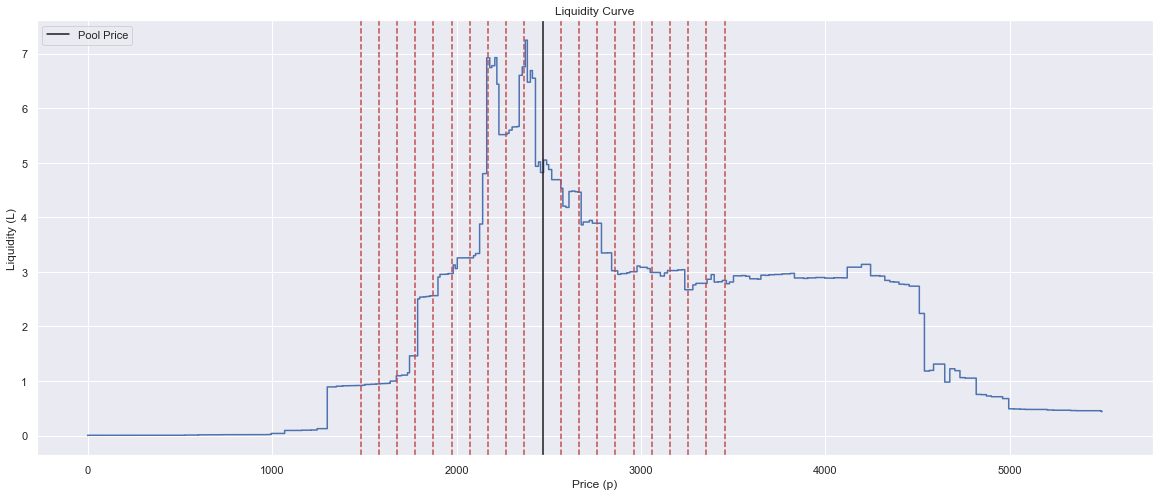

In [14]:
example_day = '2022-01-27'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(0, 5000), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

In [15]:
%%time
numeraire_token = 1
sigma = 0.04
all_returns = {}

for day, start_pool in pool_snapshots.items():
    price_bins = np.array(
        [0]
        + [start_pool.price * (1 + i * sigma) for i in range(-10, 11)]
        + [np.inf]
    )
    day_txn = all_txn.loc[all_txn['txn_time'].dt.date == pd.to_datetime(day)]
    irrs = calc_irr_per_bin(start_pool, price_bins, day_txn, liquidity, swaps,
                            numeraire_token=numeraire_token, position_id='generic_LP')
    all_returns[day] = irrs
    
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)

CPU times: user 8min 34s, sys: 16.4 s, total: 8min 50s
Wall time: 9min 1s


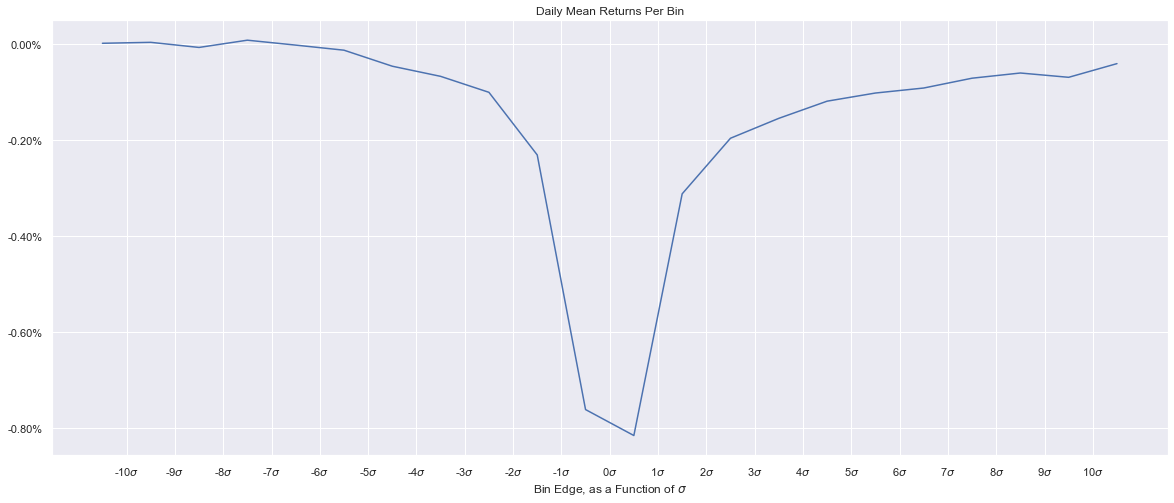

In [16]:
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [17]:
pd.to_pickle(all_returns, SAVED_RETURNS)